# Setup

In [1]:
#From CS231n assgn 3 Spring 2018
import os 
import cv2 as cv
import pandas as pd 
from skimage import io,transform
import torch
import torch.nn as nn 
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import time
import numpy as np 
from tqdm import tqdm_notebook as tqdm


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


#Flatten module from CS231n assign 3 Pytorch-GAN
class Flatten(nn.Module):
    def forward(self,x):
        N,H,W,C = x.size()
        return x.view(N,-1)
    
#Unflatten module from CS231n assign 3 Pytorch-GAN
class Unflatten(nn.Module):
    "Unflattens module receiving (N,C*H*W) and reshapes into (N,H,W,C)"
    def __init__(self,N=-1,H=7,W=7,C=128):
        super(Unflatten,self).__init__()
        self.N = N
        self.C = C 
        self.H = H 
        self.W = W 
    def forward(self,x):
        return x.view(self.N,self.H,self.W,self.C)

#initialize module from CS231n assign 3 Pytorch-GAN
def initialize_weights(m):
     if isinstance(m,nn.Linear) or isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d) or isinstance(m,nn.Conv1d):
        nn.init.xavier_uniform(m.weight.data)
    
    

## Constants

In [2]:
dtype = torch.cuda.FloatTensor
input_img_size = (419,419,3)
BATCH_SIZE = 32
batch_size = BATCH_SIZE
BRDF_DIM = 21 
image_new_size = (64,64,3)
N = BATCH_SIZE

H,W,C = image_new_size

# Data Loading

In [3]:
brdf_frame = pd.read_table('./train-set/output_empty.txt',delim_whitespace = True,header=None)
n = 999
image_name = str(brdf_frame.iloc[n, 0])

print("image name: {} ".format(image_name))
def show_image(images,brdf): #works on reshaped dataset in C H W order 
    images = np.transpose(images,(1,2,0))
    plt.imshow(images)
    plt.pause(0.001)

image name: 1000 


In [4]:
#from loading data tutorial pytorch: 
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class GMSDataset(Dataset):
    def __init__(self,txt_file,root_dir,transform =None,image_size=64):
        """
        Args: 
            txt_file (string): path to string file with annotations for imgs
            root_dir (string): Directory with imgs
            transform (callable, optional): Optional transform on a sample
            image_size(int): resizes image to image_size if image_size != 419 
        """
        self.brdf_frame = pd.read_table(txt_file, delim_whitespace = True,header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.image_size =image_size
        
    def __len__(self):
        return len(self.brdf_frame)
    
    def __getitem__(self,idx):
        output_name = 'output' + str(self.brdf_frame.iloc[idx,0]).zfill(7)
        img_name = os.path.join(self.root_dir,
                                output_name+'.png')
        image = io.imread(img_name)
        if(image.shape[1]!=self.image_size):
            image = cv.resize(image,(self.image_size, self.image_size), interpolation = cv.INTER_AREA)
        image = np.transpose(image,axes = (2,0,1))
        image = torch.from_numpy(image)
        
        brdf = self.brdf_frame.iloc[idx,1:]
        brdf = (torch.from_numpy(brdf.values)).float()
        sample = {'image': image, 'brdf': brdf}
        if self.transform: 
            sample = self.transform(sample)
        return sample 

0 torch.Size([3, 64, 64]) torch.Size([21])


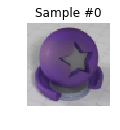

1 torch.Size([3, 64, 64]) torch.Size([21])


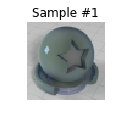

2 torch.Size([3, 64, 64]) torch.Size([21])


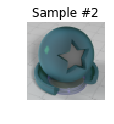

3 torch.Size([3, 64, 64]) torch.Size([21])


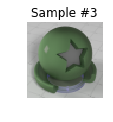

In [5]:
sphere_dataset_train = GMSDataset(txt_file = './train-set/output_empty.txt',
                                  root_dir = './train-set',image_size = 64)
fig = plt.figure()

for i in range(len(sphere_dataset_train)):
    sample = sphere_dataset_train[i]

    print(i, sample['image'].shape, sample['brdf'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(sample['image'],sample['brdf'])

    if i == 3:
        plt.show()
        break

0 torch.Size([3, 64, 64]) torch.Size([21])


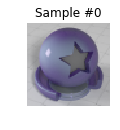

1 torch.Size([3, 64, 64]) torch.Size([21])


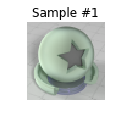

2 torch.Size([3, 64, 64]) torch.Size([21])


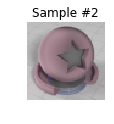

3 torch.Size([3, 64, 64]) torch.Size([21])


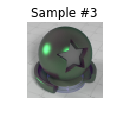

In [6]:
sphere_dataset_test = GMSDataset(txt_file = './val-set/output_empty.txt',
                                 root_dir = './val-set',image_size = 64)
fig = plt.figure()

for i in range(len(sphere_dataset_test)):
    sample = sphere_dataset_test[i]

    print(i, sample['image'].shape, sample['brdf'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(sample['image'],sample['brdf'])

    if i == 3:
        plt.show()
        break

torch.Size([32, 3, 64, 64])
torch.Size([32, 21])


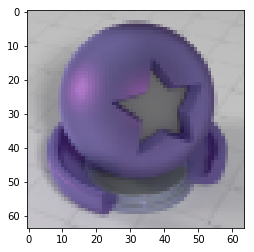

In [13]:
def sphere_model_batch(index,batch_size=BATCH_SIZE,train_or_val='train'):
#     ""
#     Takes in an index and produces a batch_size of images and brdfs for sphere_dataset_train
#     or sphere_dataset_test
#     ""
    batch_image = None
    batch_brdf = None

    if train_or_val == 'train':
        if(index+batch_size >len(sphere_dataset_train)):
            batch_size = len(sphere_dataset_train) - index
            
        batch_image = sphere_dataset_train[index]['image'].unsqueeze(0)
        batch_brdf = sphere_dataset_train[index]['brdf'].unsqueeze(0)
        for i in range(index+1,index+batch_size):
            x = sphere_dataset_train[i]
            batch_image = torch.cat((batch_image,x['image'].unsqueeze(0)),dim=0)
            batch_brdf = torch.cat((batch_brdf,x['brdf'].unsqueeze(0)),dim=0)
    else:
        if(index+batch_size >len(sphere_dataset_test)):
            batch_size = len(sphere_dataset_test) - index
                
        batch_image = sphere_dataset_test[index]['image'].unsqueeze(0)
        batch_brdf = sphere_dataset_test[index]['brdf'].unsqueeze(0)
        for i in range(index+1,index+batch_size): 
            x = sphere_dataset_test[i]
            batch_image = torch.cat((batch_image,x['image'].unsqueeze(0)),dim=0)
            batch_brdf = torch.cat((batch_brdf,x['brdf'].unsqueeze(0)),dim=0)
    return batch_image,batch_brdf
y = sphere_model_batch(200,train_or_val='test')
print(y[0].shape)
print(y[1].shape)
show_image(y[0][0],y[1][0])
        

## Image Display

In [9]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# Models

## Generators

In [7]:
def CNN_generator(brdf_dim=BRDF_DIM,batch_size=BATCH_SIZE,image_size=64):
    #model derived from GMS paper
    model = nn.Sequential(nn.Conv1d(1,64,3), # output = (N,64,21)
                          nn.ELU(),
                          nn.Upsample(scale_factor = 2), # output = (N,64,42)
                          nn.Conv1d(64,64,3),            # output = (N,64,42)
                          nn.ELU(),
                          nn.Upsample(scale_factor = 2), 
                          nn.Conv1d(64,64,3),            # output = (N,64,84)
                          nn.ELU(),
                          nn.Upsample(scale_factor = 2),
                          nn.Conv1d(64,64,3),           
                          nn.ELU(),
                          nn.Upsample(scale_factor = 2),
                          nn.Conv1d(64,3,3),             #added one more conv layer to resize channels to allow
                          nn.ELU(),                      #arbitrary image size
                          nn.Linear(274,1000),
                          nn.Linear(1000,image_size*image_size),
                          nn.ELU(),
                          Unflatten(batch_size,3,image_size,image_size)
    )
    return model
test_CNN = CNN_generator().type(dtype)
test_CNN.apply(initialize_weights)

fake_seed = torch.randn(BATCH_SIZE, BRDF_DIM).type(dtype).unsqueeze(1)
print("input size: ",fake_seed.shape)
fake_images = test_CNN.forward(fake_seed)
print("output_size: ", fake_images.size())


input size:  torch.Size([32, 1, 21])
output_size:  torch.Size([32, 3, 64, 64])


/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [8]:
def DCNN_generator(brdf_dim=BRDF_DIM,image_size=64):
    #model derived from intuition regarding the spatial locality of data and standardized normalization techniques
    model = nn.Sequential(nn.ConvTranspose1d(1,64,kernel_size = 32,padding=1,stride = 1), # output = (N,64,16)
                          nn.ELU(),
                          nn.BatchNorm1d(64),
                          nn.ConvTranspose1d(64,64,kernel_size = 64,padding=1,stride = 1),
                          nn.ELU(),
                          nn.BatchNorm1d(64),
                          nn.ConvTranspose1d(64,64,kernel_size = 64,padding=1,stride = 1),
                          nn.ELU(),
                          nn.BatchNorm1d(64),
                          nn.ConvTranspose1d(64,64,kernel_size = 64,padding=1,stride = 1),
                          nn.ELU(),
                          nn.BatchNorm1d(64),
                          nn.ConvTranspose1d(64,64,kernel_size = 64,padding=1,stride = 1 ),
                          nn.ELU(),
                          nn.BatchNorm1d(64),
                          nn.ConvTranspose1d(64,3,kernel_size = 64,padding=1,stride = 1 ),
                          nn.ELU(),
                          nn.BatchNorm1d(3),
                          nn.Linear(355,1000),
                          nn.Linear(1000,image_size*image_size),
                          nn.ELU(),
                          Unflatten(batch_size,3,image_size,image_size)
    )
    return model
test_CNN = DCNN_generator().type(dtype)
test_CNN.apply(initialize_weights)

fake_seed = torch.randn(BATCH_SIZE, BRDF_DIM).type(dtype).unsqueeze(1)
print("input size: ",fake_seed.shape)
fake_images = test_CNN.forward(fake_seed)
print("output_size: ", fake_images.size())

input size:  torch.Size([32, 1, 21])
output_size:  torch.Size([32, 3, 64, 64])


/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [383]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    
    optimizer = optim.Adam(model.parameters(),lr =1e-3,betas=(0.5,0.999))
    return optimizer

## Train CNN

In [10]:
def run_CNN(CNN,CNN_solver,
            loss_fn,
            show_every = 100, 
            batch_size = BATCH_SIZE,
            num_epochs = 5,loss_type = "SmoothL1_loss"):
    loss_hist = []
    iter_count = 0
    for epoch in range(num_epochs):
        for i in range(0,len(sphere_dataset_train),batch_size):            
            x = sphere_model_batch(i,batch_size=batch_size)
            if x[0].shape[0] != batch_size:
                continue
            
            CNN_solver.zero_grad()
            images = x[0].type(dtype)
            brdfs  = x[1].type(dtype).unsqueeze(1)
            gen_images = CNN(brdfs)
            
            total_error = loss_fn(gen_images,images)
            
            loss_hist.append(total_error.item())
            total_error.backward()        
            CNN_solver.step()
            
            
            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, {}: {:.4}'.format(epoch,iter_count,loss_type,loss_hist[len(loss_hist)-1]))
                gen_imgs_numpy = gen_images.data.cpu().numpy().transpose(0,2,3,1)
                real_imgs_numpy = images.data.cpu().numpy().transpose(0,2,3,1)
                img_0 = np.uint8(gen_imgs_numpy[0])
                img_1 = np.uint8(real_imgs_numpy[0])
                
                show_images([img_0,img_1], cols = 1, titles = ["_generated_"+str(i+1),
                                                           '_target_'+str(i+1)])
                print()
                plt.gcf().clear()
                if not iter_count == 0:
                    pbar.close()
                pbar = tqdm(total=show_every)
            iter_count += 1
            pbar.update(1)
            
    return loss_hist
   


## Experiments

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0, Iter: 0, MSE_loss: 2.004e+04


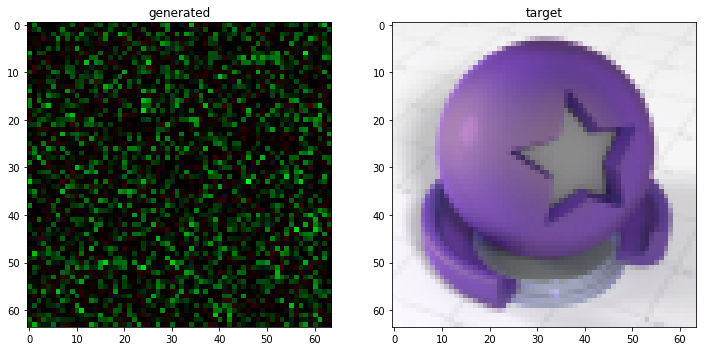

Epoch: 16, Iter: 500, MSE_loss: 522.3


<Figure size 432x288 with 0 Axes>

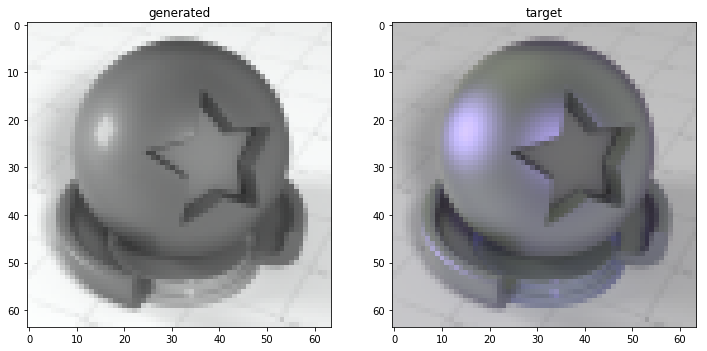

Epoch: 32, Iter: 1000, MSE_loss: 611.1


<Figure size 432x288 with 0 Axes>

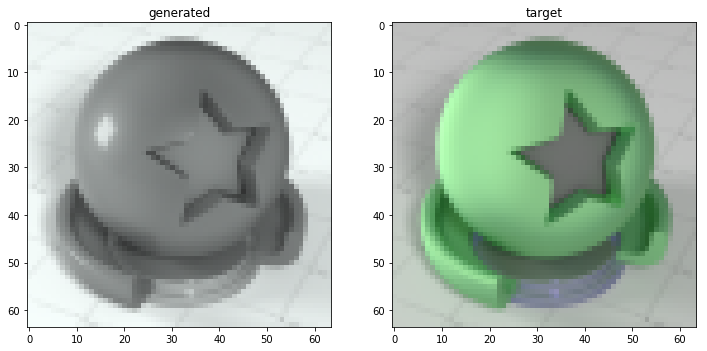

Epoch: 48, Iter: 1500, MSE_loss: 503.7


<Figure size 432x288 with 0 Axes>

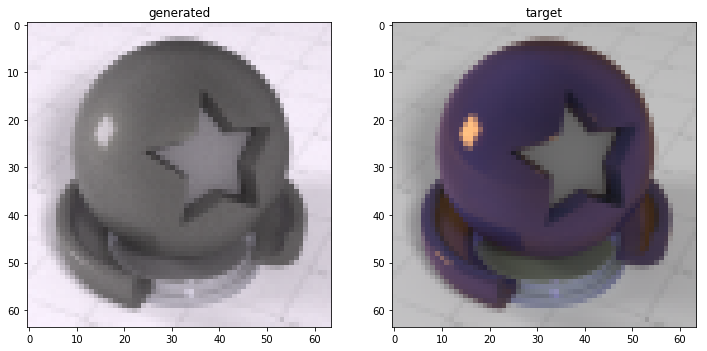

Epoch: 64, Iter: 2000, MSE_loss: 286.1


<Figure size 432x288 with 0 Axes>

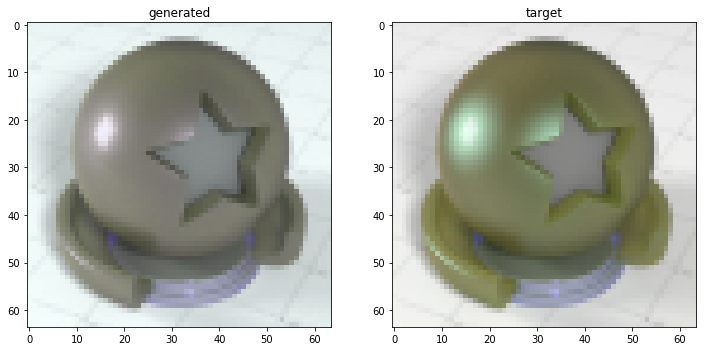

Epoch: 80, Iter: 2500, MSE_loss: 219.1


<Figure size 432x288 with 0 Axes>

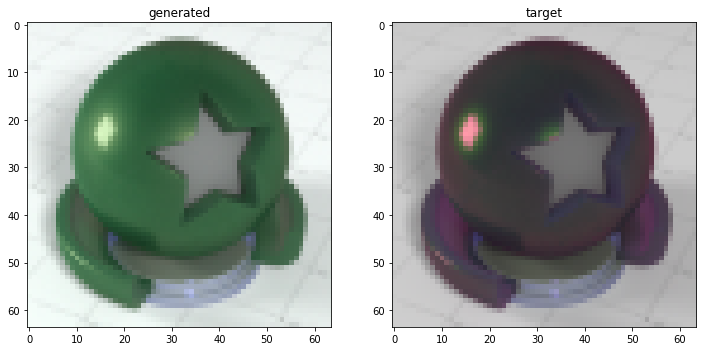

Epoch: 96, Iter: 3000, MSE_loss: 180.0


<Figure size 432x288 with 0 Axes>

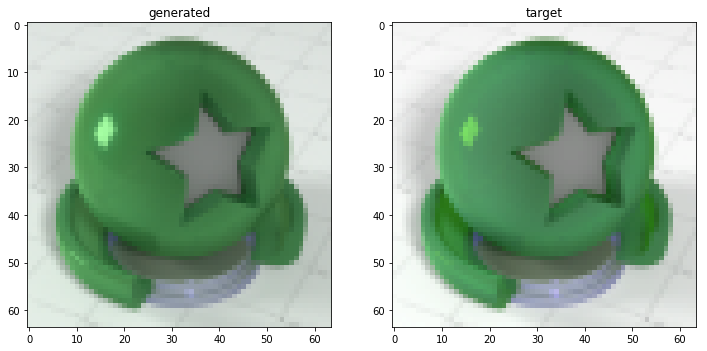

Epoch: 112, Iter: 3500, MSE_loss: 161.7


<Figure size 432x288 with 0 Axes>

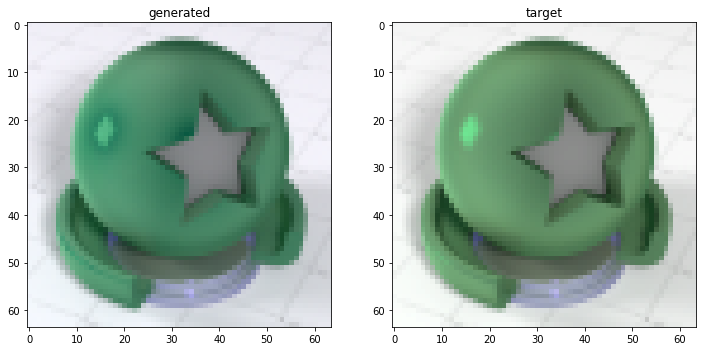

Epoch: 129, Iter: 4000, MSE_loss: 177.4


<Figure size 432x288 with 0 Axes>

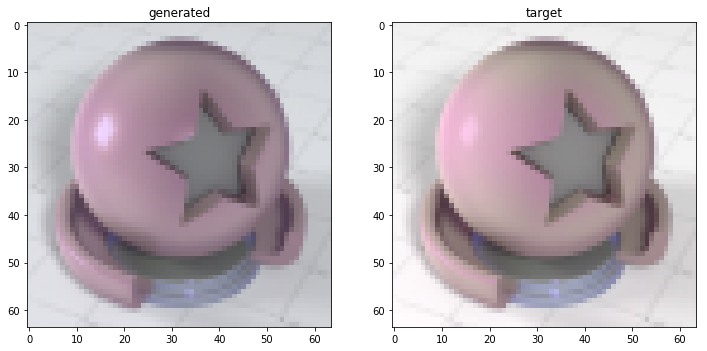

Epoch: 145, Iter: 4500, MSE_loss: 156.1


<Figure size 432x288 with 0 Axes>

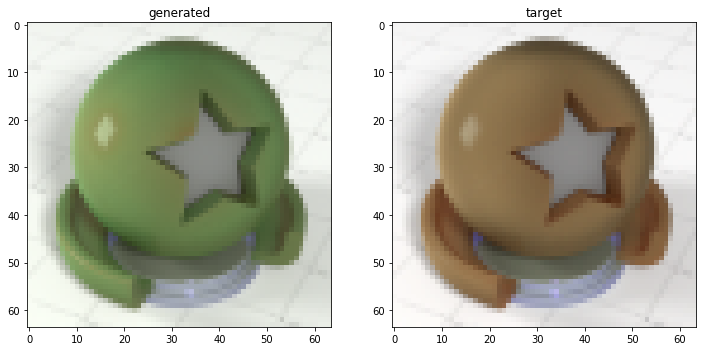

Epoch: 161, Iter: 5000, MSE_loss: 143.3


<Figure size 432x288 with 0 Axes>

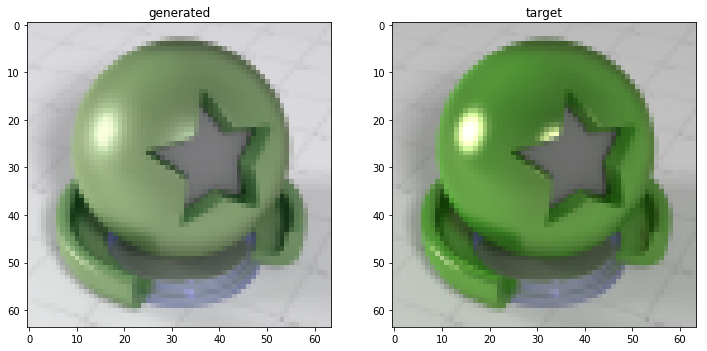

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 177, Iter: 5500, MSE_loss: 105.5


<Figure size 432x288 with 0 Axes>

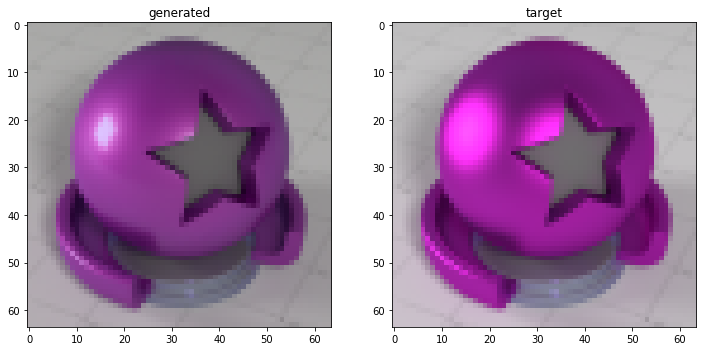

Epoch: 193, Iter: 6000, MSE_loss: 125.8


<Figure size 432x288 with 0 Axes>

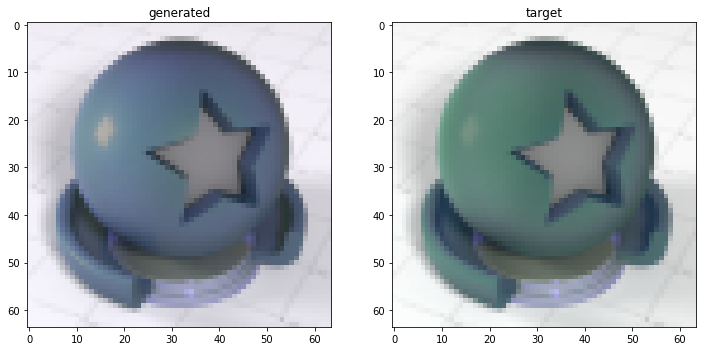

Epoch: 209, Iter: 6500, MSE_loss: 177.0


<Figure size 432x288 with 0 Axes>

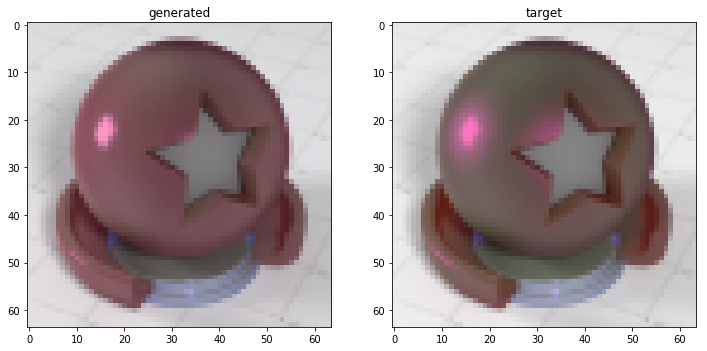

Epoch: 225, Iter: 7000, MSE_loss: 99.91


<Figure size 432x288 with 0 Axes>

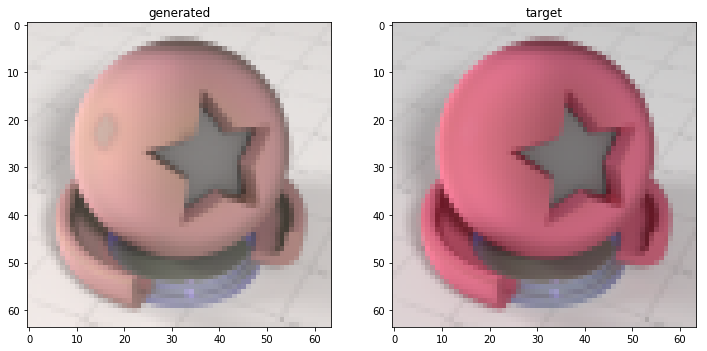

Epoch: 241, Iter: 7500, MSE_loss: 89.9


<Figure size 432x288 with 0 Axes>

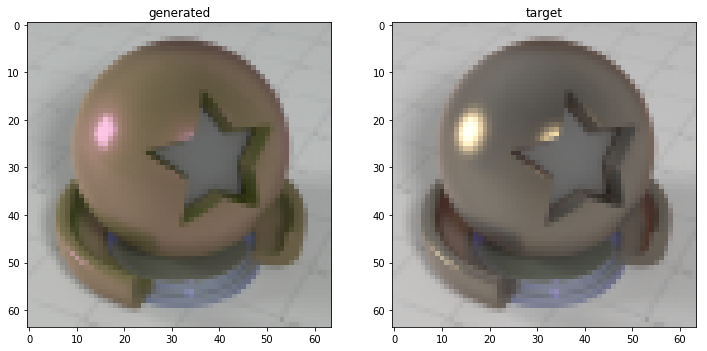

Epoch: 258, Iter: 8000, MSE_loss: 82.56


<Figure size 432x288 with 0 Axes>

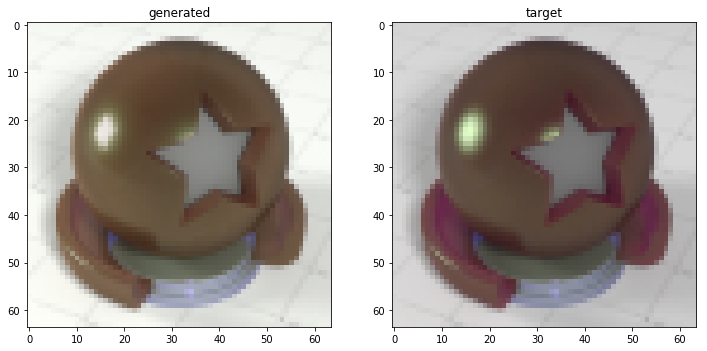

Epoch: 274, Iter: 8500, MSE_loss: 101.2


<Figure size 432x288 with 0 Axes>

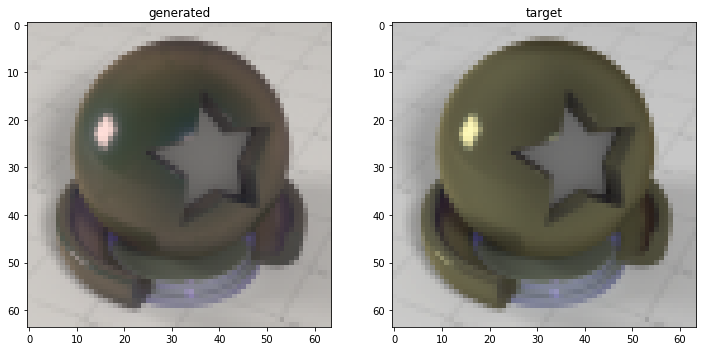

Epoch: 290, Iter: 9000, MSE_loss: 87.86


<Figure size 432x288 with 0 Axes>

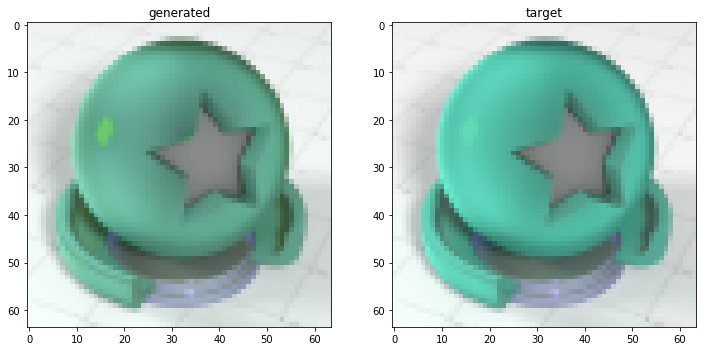

Epoch: 306, Iter: 9500, MSE_loss: 63.47


<Figure size 432x288 with 0 Axes>

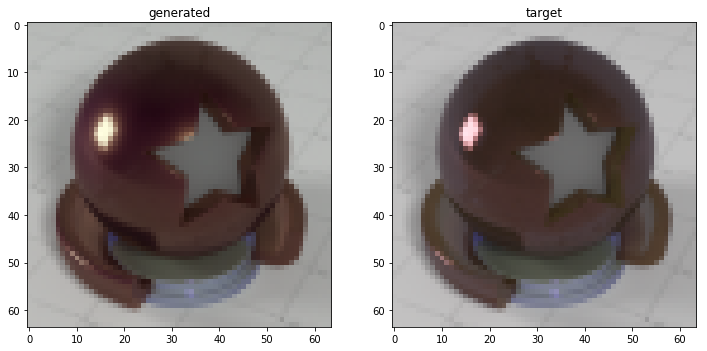

Epoch: 322, Iter: 10000, MSE_loss: 79.02


<Figure size 432x288 with 0 Axes>

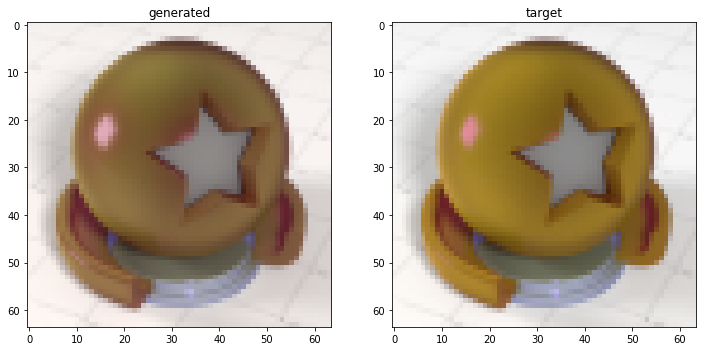

Epoch: 338, Iter: 10500, MSE_loss: 93.66


<Figure size 432x288 with 0 Axes>

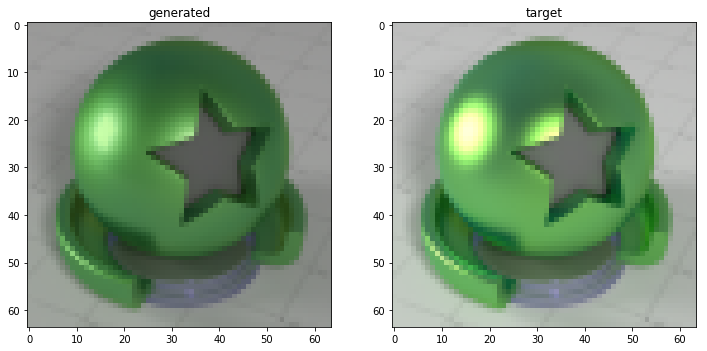

Epoch: 354, Iter: 11000, MSE_loss: 64.73


<Figure size 432x288 with 0 Axes>

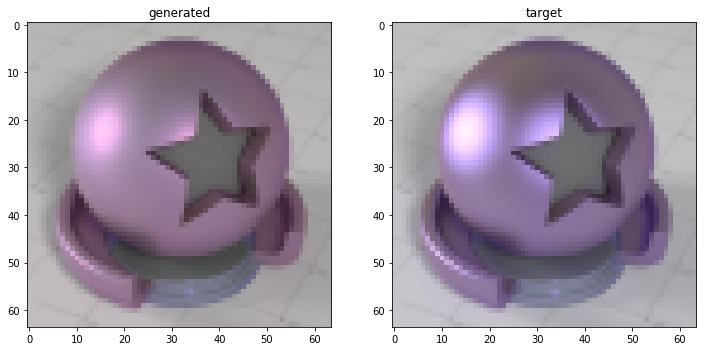

Epoch: 370, Iter: 11500, MSE_loss: 47.63


<Figure size 432x288 with 0 Axes>

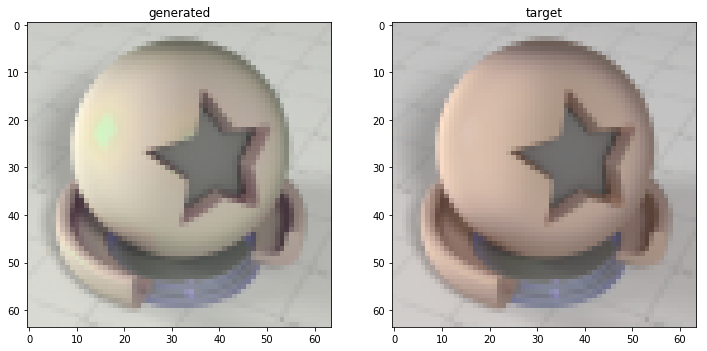

Epoch: 387, Iter: 12000, MSE_loss: 44.31


<Figure size 432x288 with 0 Axes>

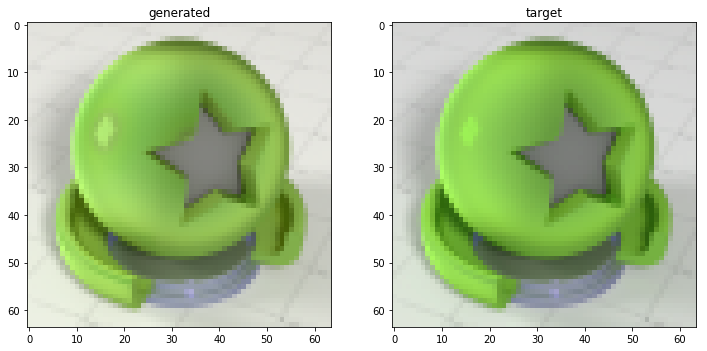

Epoch: 403, Iter: 12500, MSE_loss: 54.86


<Figure size 432x288 with 0 Axes>

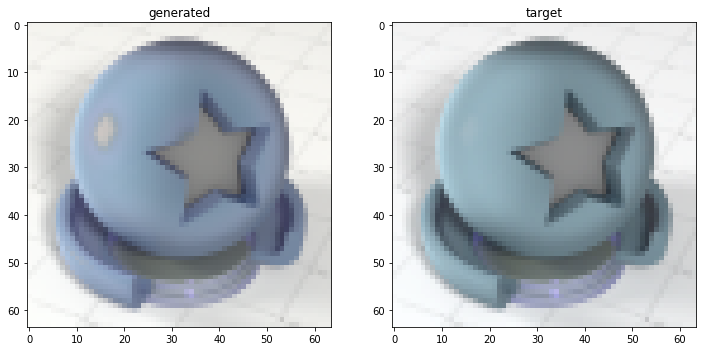

Epoch: 419, Iter: 13000, MSE_loss: 125.3


<Figure size 432x288 with 0 Axes>

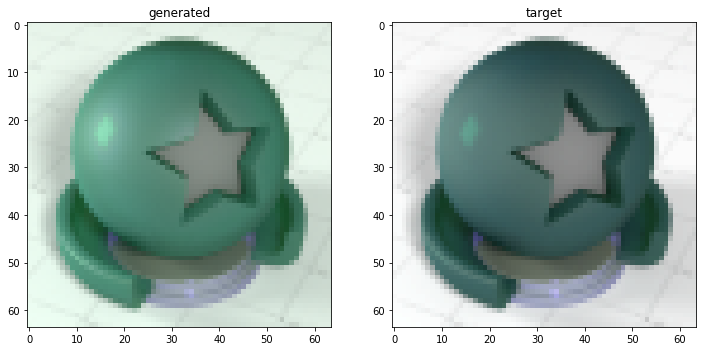

Epoch: 435, Iter: 13500, MSE_loss: 80.01


<Figure size 432x288 with 0 Axes>

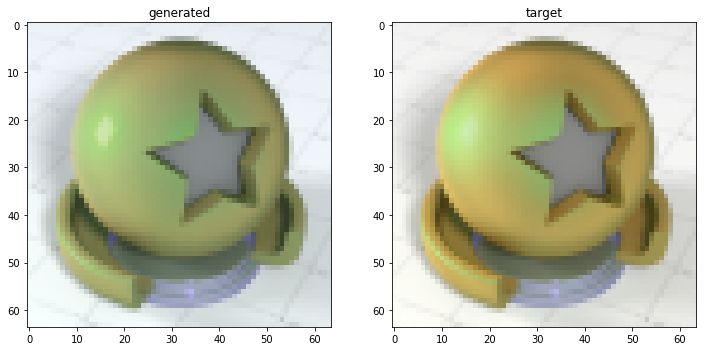

Epoch: 451, Iter: 14000, MSE_loss: 50.7


<Figure size 432x288 with 0 Axes>

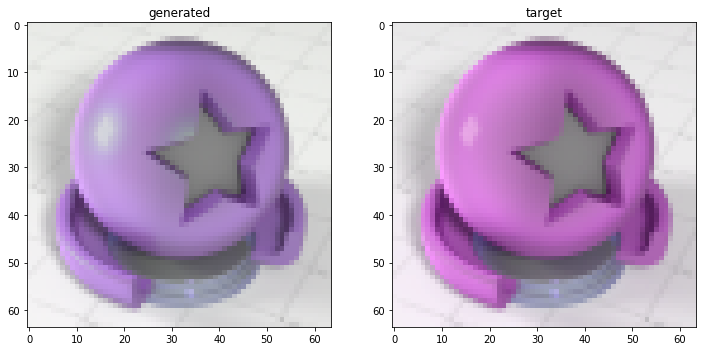

Epoch: 467, Iter: 14500, MSE_loss: 55.11


<Figure size 432x288 with 0 Axes>

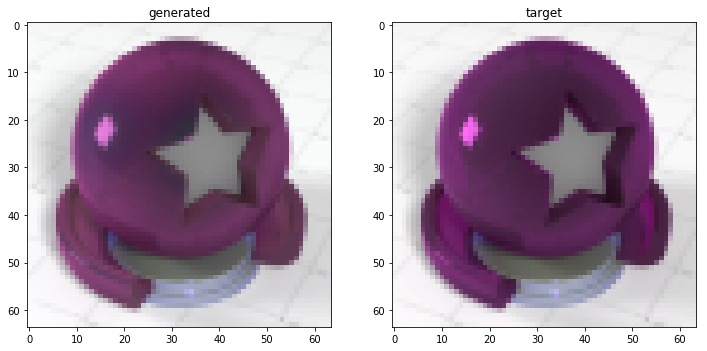

Epoch: 483, Iter: 15000, MSE_loss: 54.55


<Figure size 432x288 with 0 Axes>

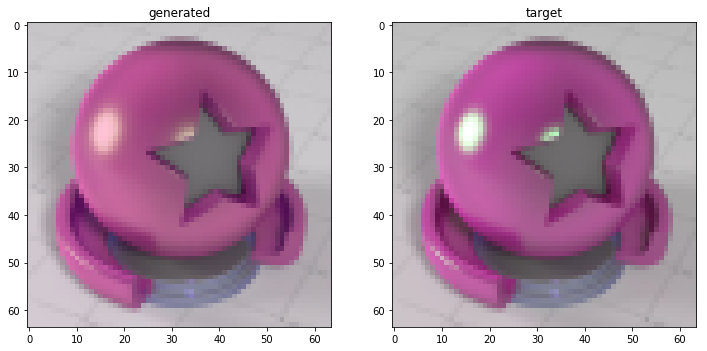

Epoch: 500, Iter: 15500, MSE_loss: 52.11


<Figure size 432x288 with 0 Axes>

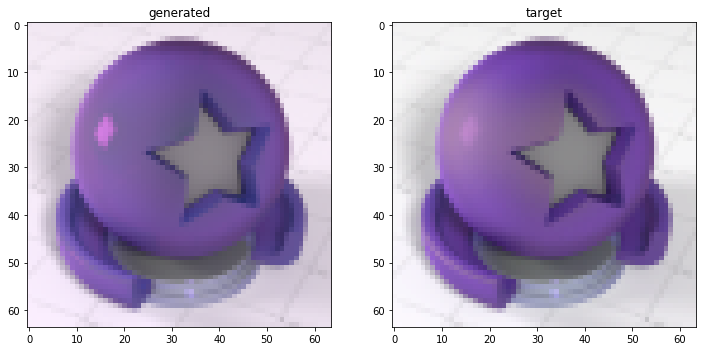

Epoch: 516, Iter: 16000, MSE_loss: 56.19


<Figure size 432x288 with 0 Axes>

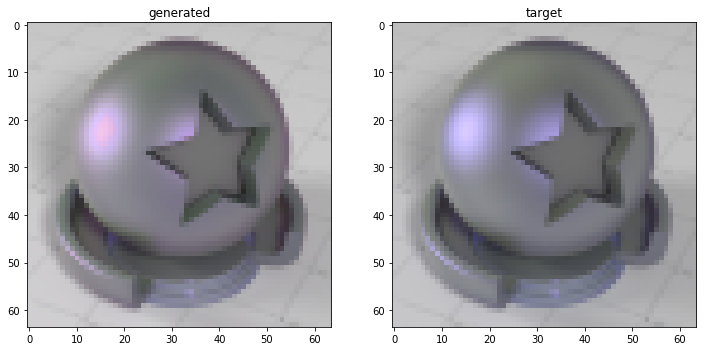

Epoch: 532, Iter: 16500, MSE_loss: 48.17


<Figure size 432x288 with 0 Axes>

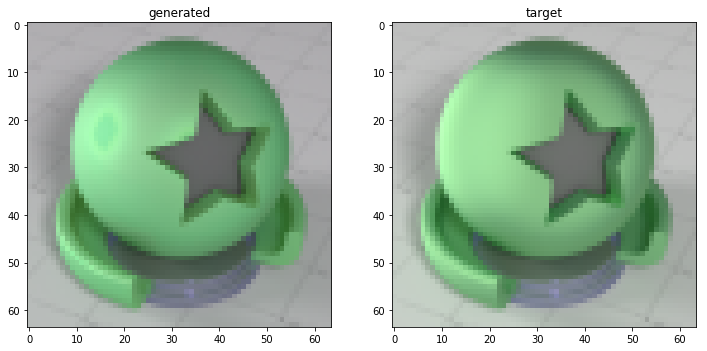

Epoch: 548, Iter: 17000, MSE_loss: 45.45


<Figure size 432x288 with 0 Axes>

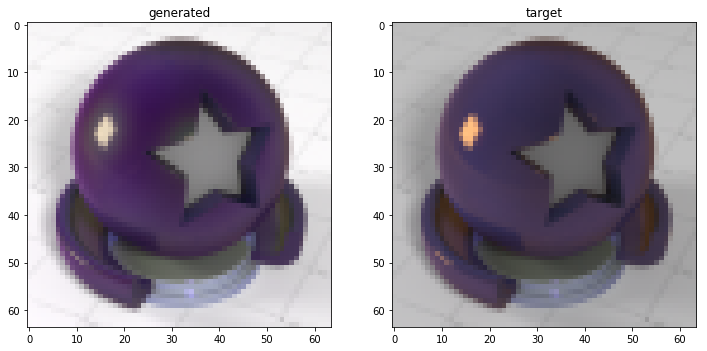

Epoch: 564, Iter: 17500, MSE_loss: 29.46


<Figure size 432x288 with 0 Axes>

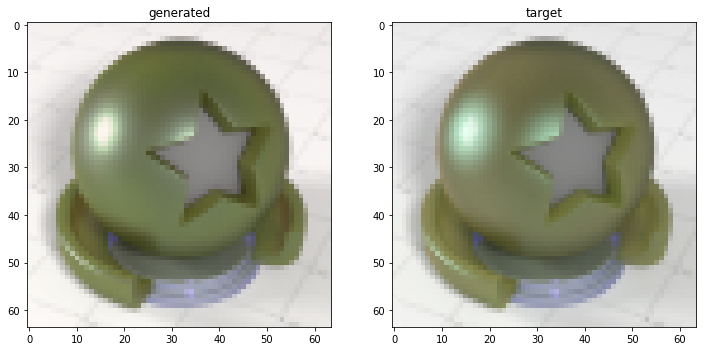

Epoch: 580, Iter: 18000, MSE_loss: 31.44


<Figure size 432x288 with 0 Axes>

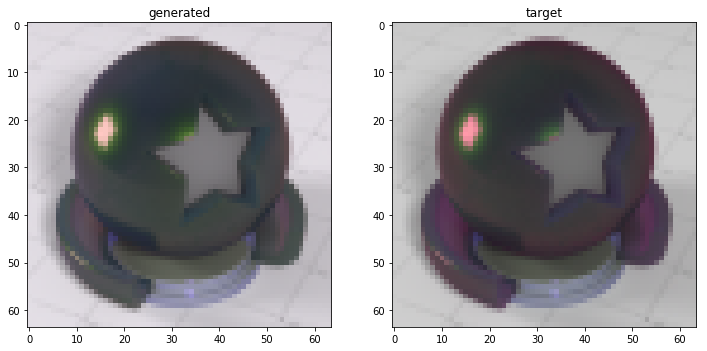

Epoch: 596, Iter: 18500, MSE_loss: 25.87


<Figure size 432x288 with 0 Axes>

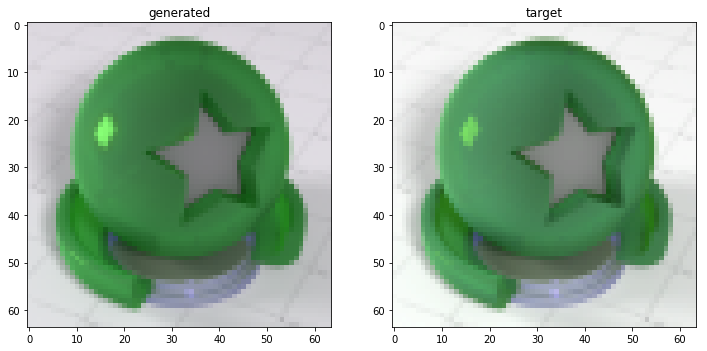

Epoch: 612, Iter: 19000, MSE_loss: 27.03


<Figure size 432x288 with 0 Axes>

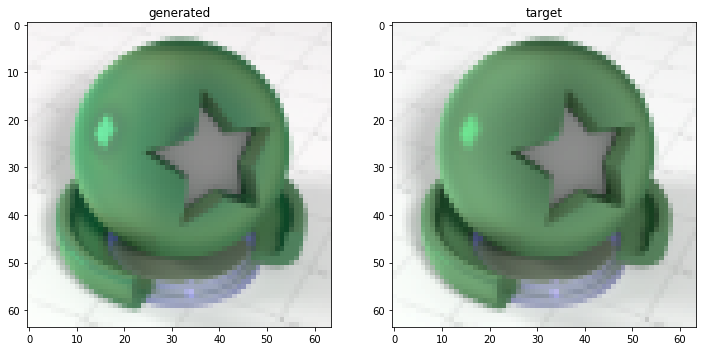

Epoch: 629, Iter: 19500, MSE_loss: 25.23


<Figure size 432x288 with 0 Axes>

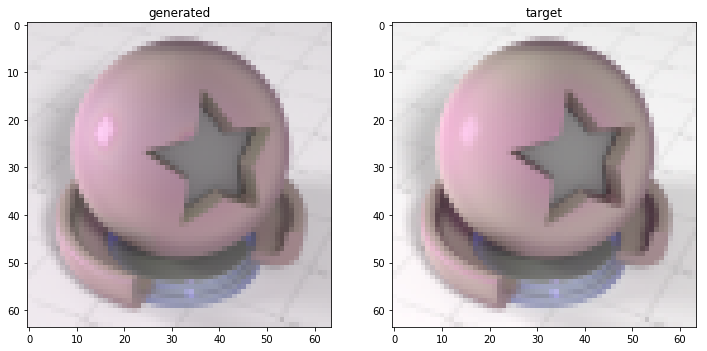

Epoch: 645, Iter: 20000, MSE_loss: 23.73


<Figure size 432x288 with 0 Axes>

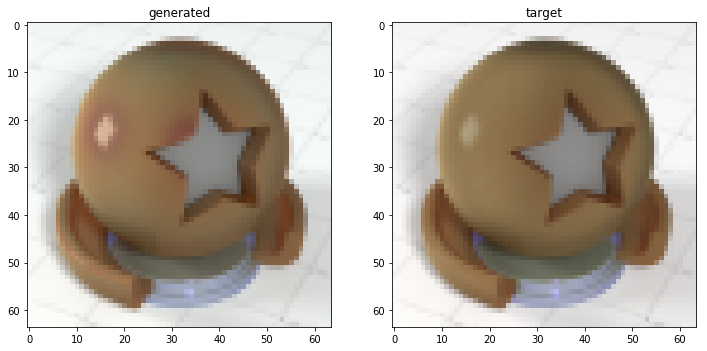

Epoch: 661, Iter: 20500, MSE_loss: 28.27


<Figure size 432x288 with 0 Axes>

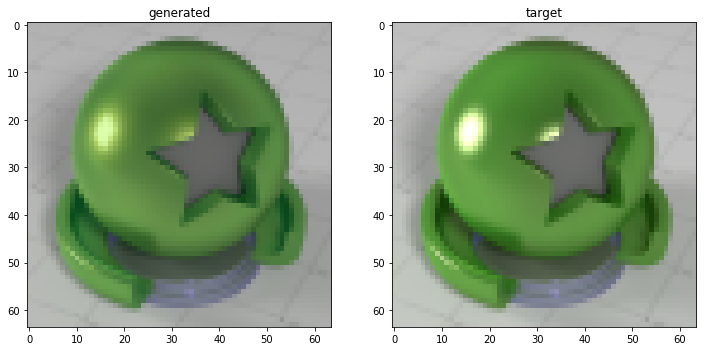

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 677, Iter: 21000, MSE_loss: 22.64


<Figure size 432x288 with 0 Axes>

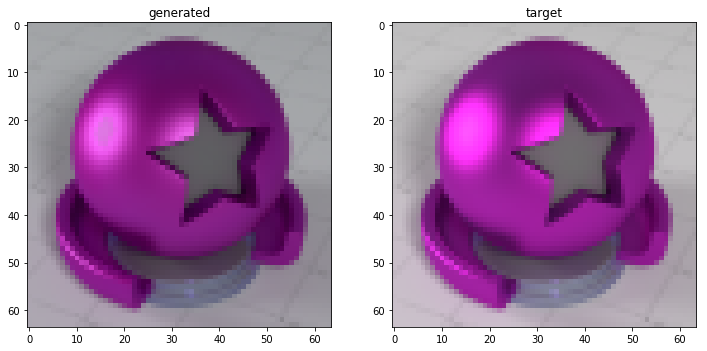

Epoch: 693, Iter: 21500, MSE_loss: 34.26


<Figure size 432x288 with 0 Axes>

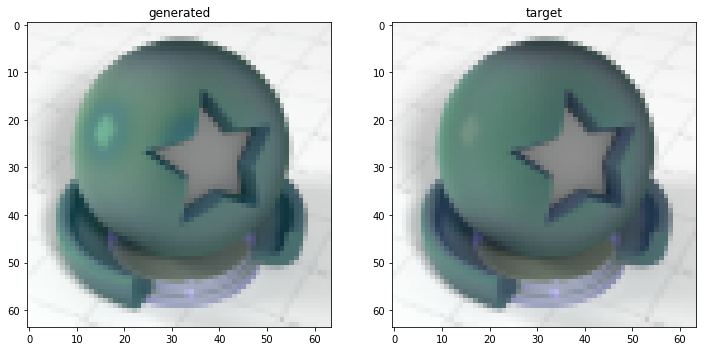

Epoch: 709, Iter: 22000, MSE_loss: 31.0


<Figure size 432x288 with 0 Axes>

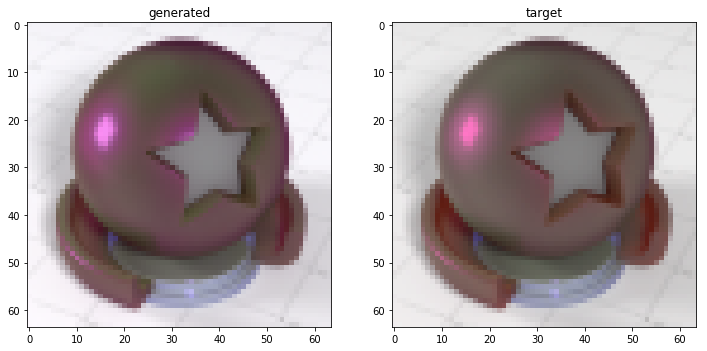

Epoch: 725, Iter: 22500, MSE_loss: 29.01


<Figure size 432x288 with 0 Axes>

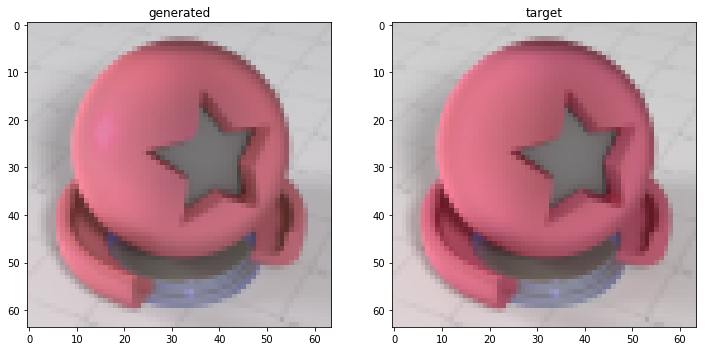

Epoch: 741, Iter: 23000, MSE_loss: 25.14


<Figure size 432x288 with 0 Axes>

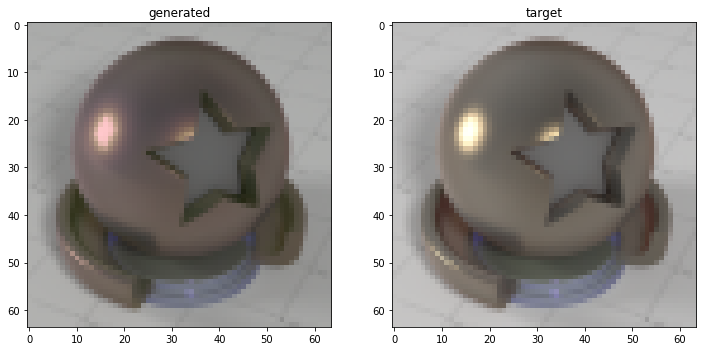

Epoch: 758, Iter: 23500, MSE_loss: 64.76


<Figure size 432x288 with 0 Axes>

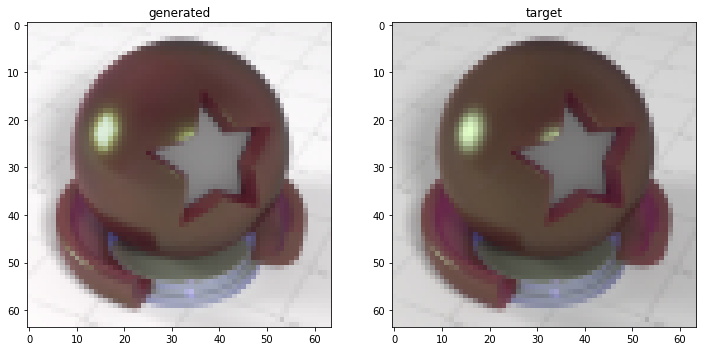

Epoch: 774, Iter: 24000, MSE_loss: 19.27


<Figure size 432x288 with 0 Axes>

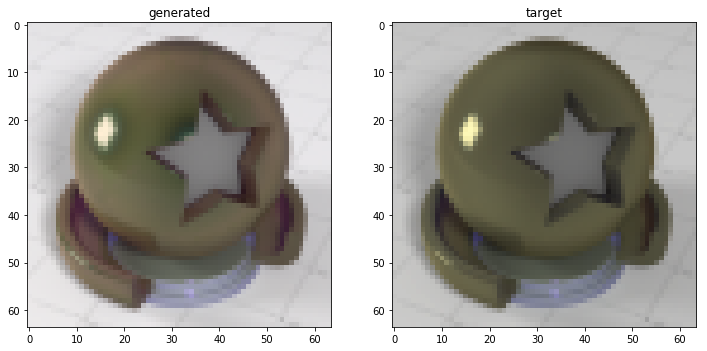

Epoch: 790, Iter: 24500, MSE_loss: 27.16


<Figure size 432x288 with 0 Axes>

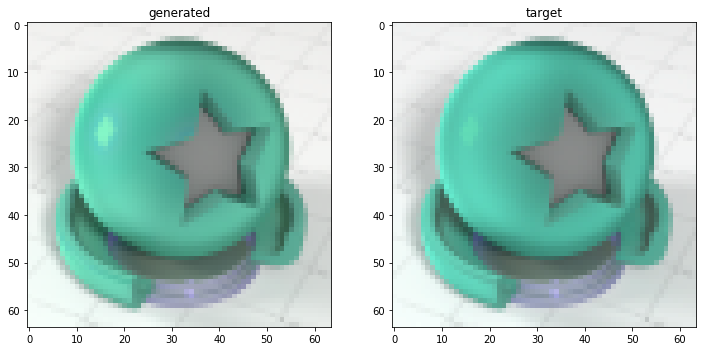

Epoch: 806, Iter: 25000, MSE_loss: 23.03


<Figure size 432x288 with 0 Axes>

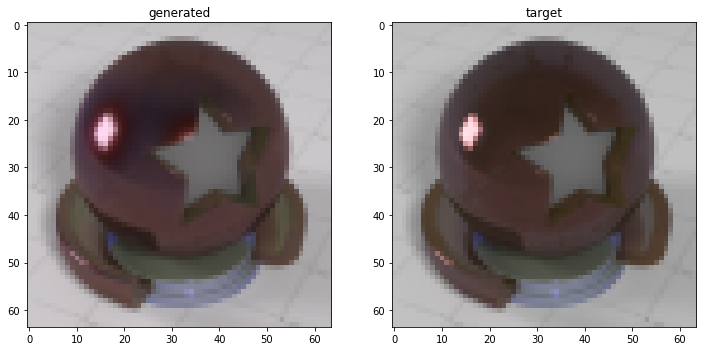

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 822, Iter: 25500, MSE_loss: 24.7


<Figure size 432x288 with 0 Axes>

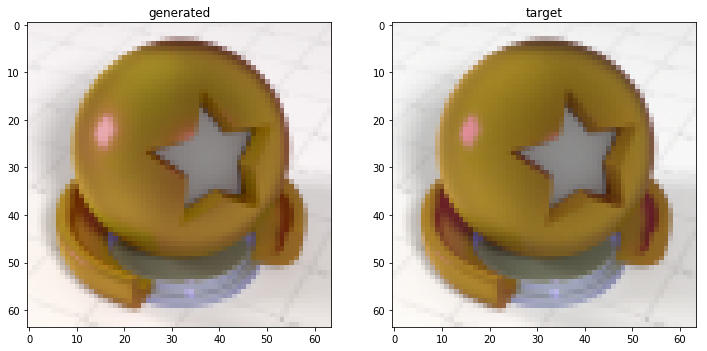

Epoch: 838, Iter: 26000, MSE_loss: 18.04


<Figure size 432x288 with 0 Axes>

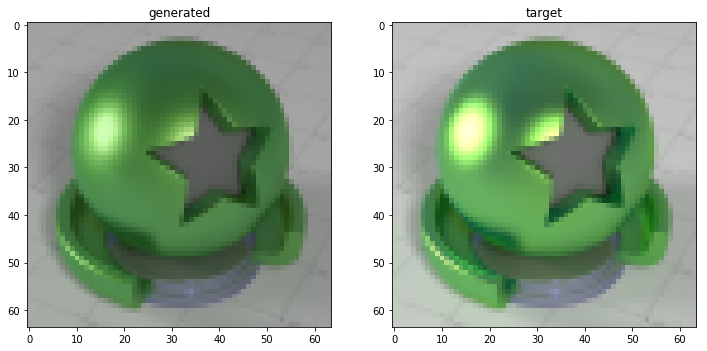

Epoch: 854, Iter: 26500, MSE_loss: 22.5


<Figure size 432x288 with 0 Axes>

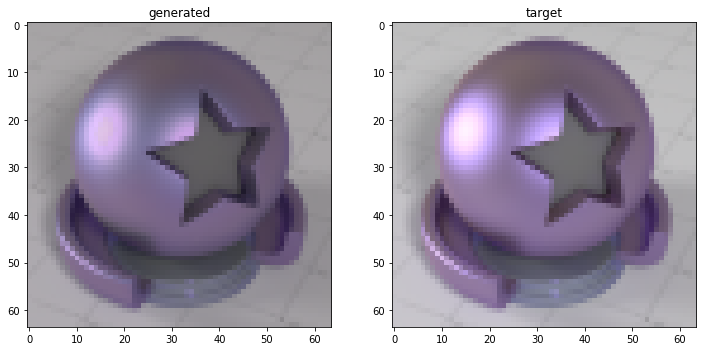

Epoch: 870, Iter: 27000, MSE_loss: 23.34


<Figure size 432x288 with 0 Axes>

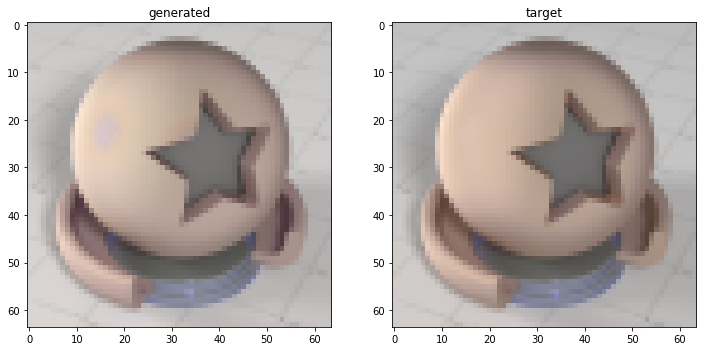

Epoch: 887, Iter: 27500, MSE_loss: 17.53


<Figure size 432x288 with 0 Axes>

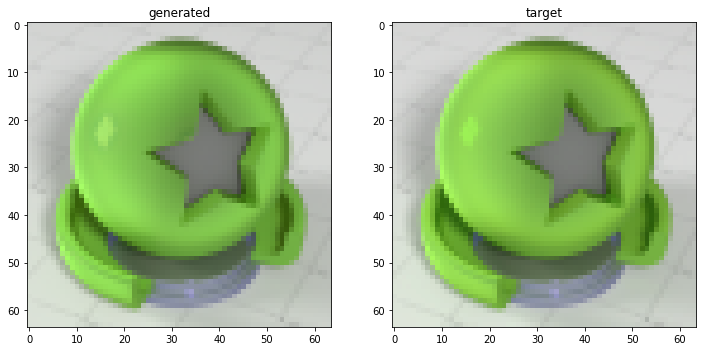

Epoch: 903, Iter: 28000, MSE_loss: 17.74


<Figure size 432x288 with 0 Axes>

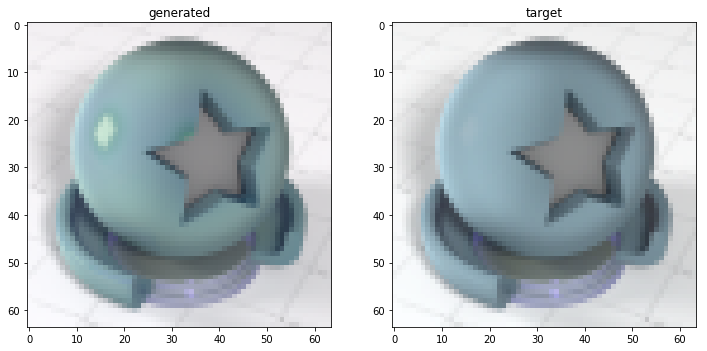

Epoch: 919, Iter: 28500, MSE_loss: 19.06


<Figure size 432x288 with 0 Axes>

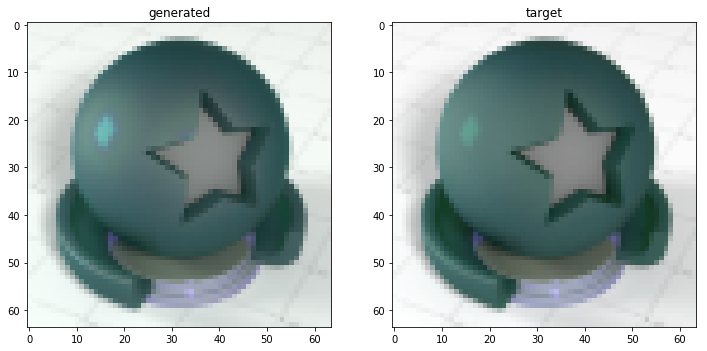

Epoch: 935, Iter: 29000, MSE_loss: 25.14


<Figure size 432x288 with 0 Axes>

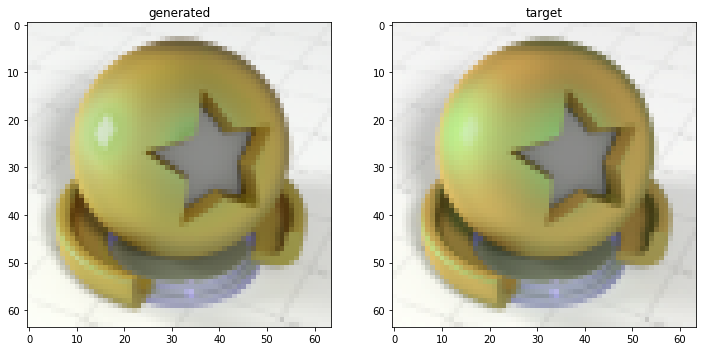

Epoch: 951, Iter: 29500, MSE_loss: 14.41


<Figure size 432x288 with 0 Axes>

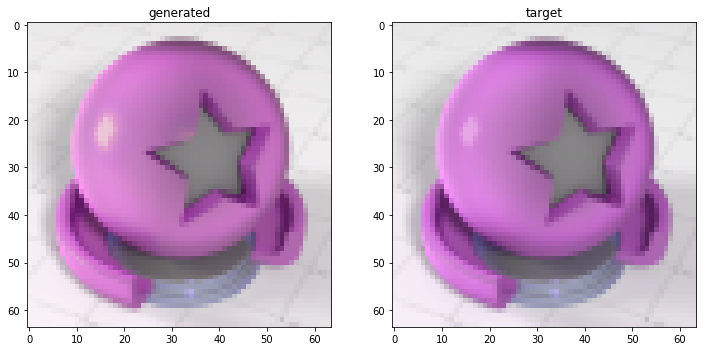

Epoch: 967, Iter: 30000, MSE_loss: 21.17


<Figure size 432x288 with 0 Axes>

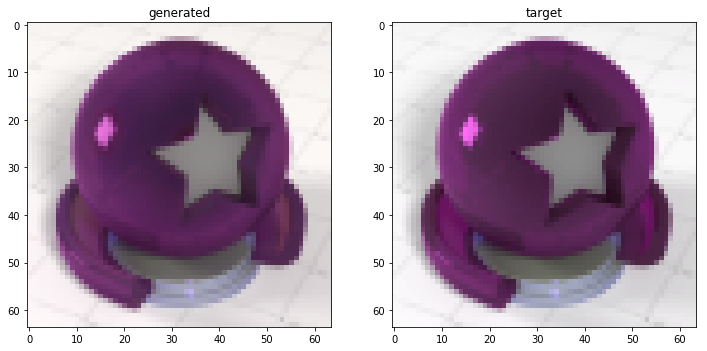

Epoch: 983, Iter: 30500, MSE_loss: 16.85


<Figure size 432x288 with 0 Axes>

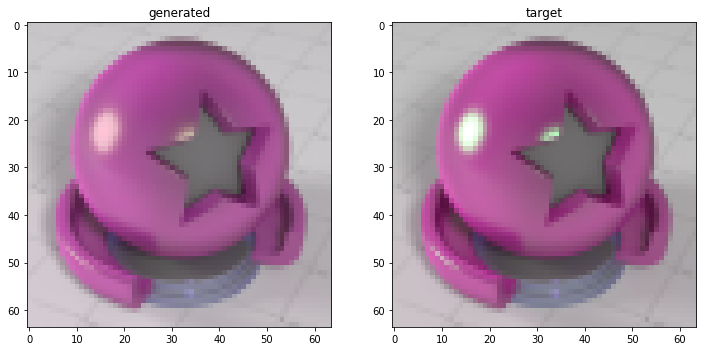

Epoch: 1000, Iter: 31000, MSE_loss: 14.83


<Figure size 432x288 with 0 Axes>

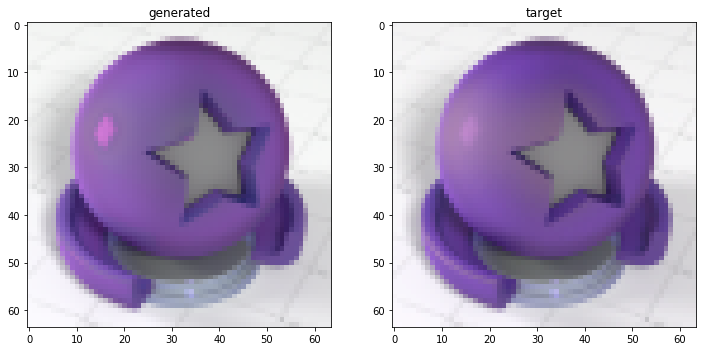

Epoch: 1016, Iter: 31500, MSE_loss: 23.15


<Figure size 432x288 with 0 Axes>

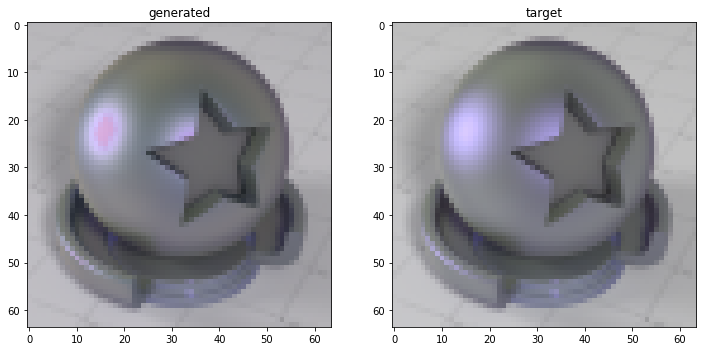

Epoch: 1032, Iter: 32000, MSE_loss: 14.89


<Figure size 432x288 with 0 Axes>

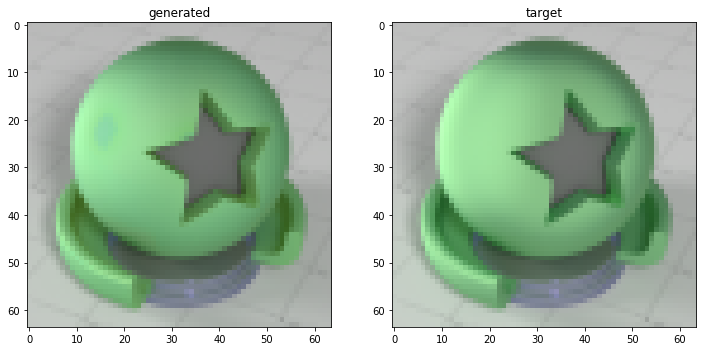

Epoch: 1048, Iter: 32500, MSE_loss: 15.98


<Figure size 432x288 with 0 Axes>

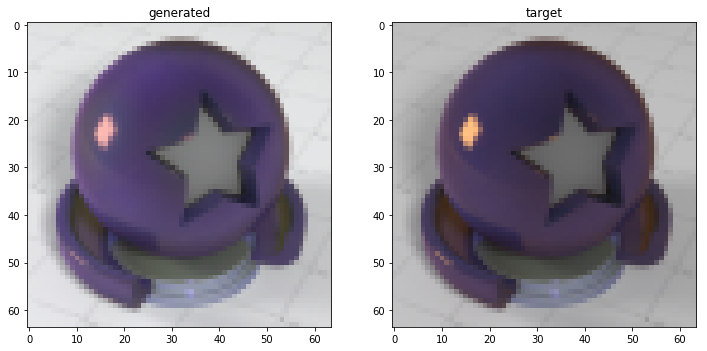

Epoch: 1064, Iter: 33000, MSE_loss: 14.39


<Figure size 432x288 with 0 Axes>

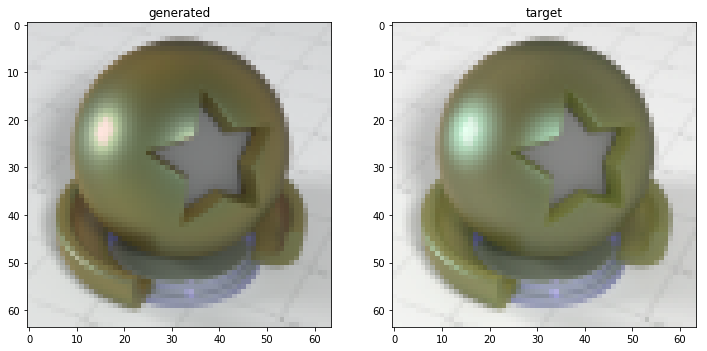

Epoch: 1080, Iter: 33500, MSE_loss: 15.02


<Figure size 432x288 with 0 Axes>

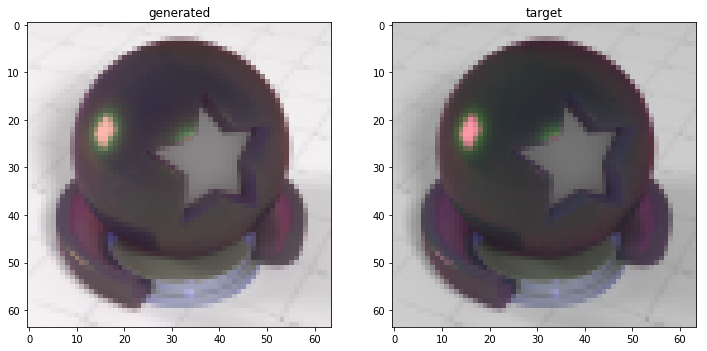

Epoch: 1096, Iter: 34000, MSE_loss: 16.25


<Figure size 432x288 with 0 Axes>

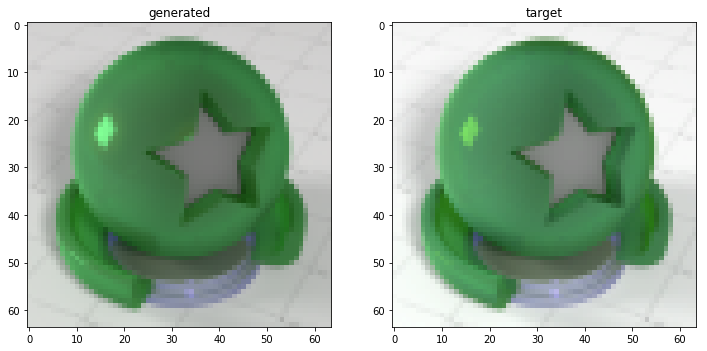

Epoch: 1112, Iter: 34500, MSE_loss: 14.06


<Figure size 432x288 with 0 Axes>

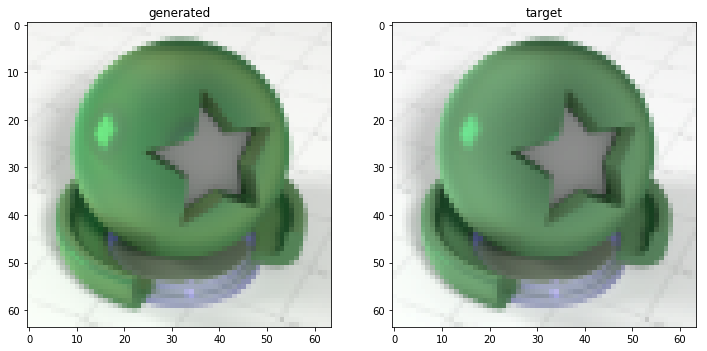

Epoch: 1129, Iter: 35000, MSE_loss: 17.24


<Figure size 432x288 with 0 Axes>

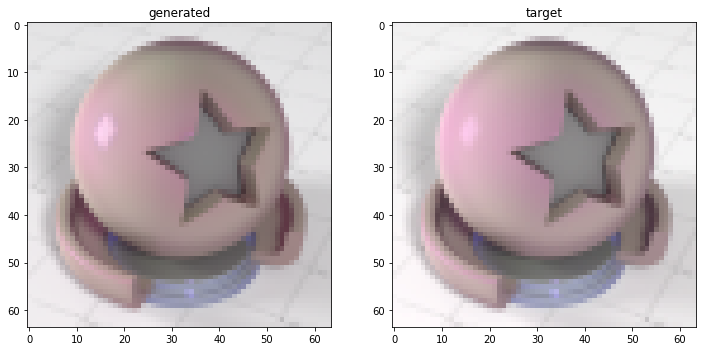

Epoch: 1145, Iter: 35500, MSE_loss: 15.19


<Figure size 432x288 with 0 Axes>

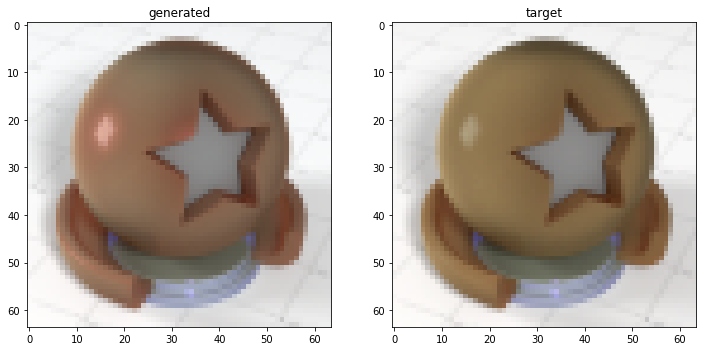

Epoch: 1161, Iter: 36000, MSE_loss: 19.22


<Figure size 432x288 with 0 Axes>

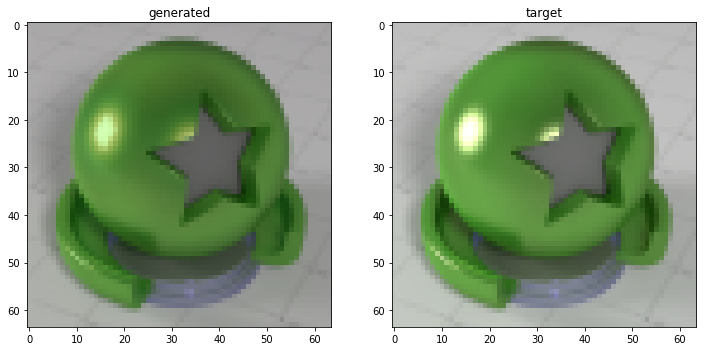

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1177, Iter: 36500, MSE_loss: 15.89


<Figure size 432x288 with 0 Axes>

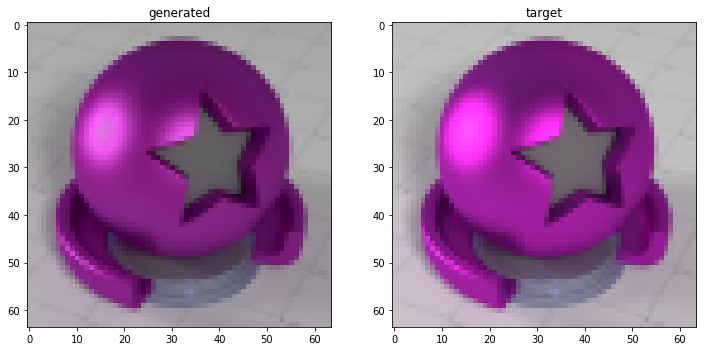

Epoch: 1193, Iter: 37000, MSE_loss: 14.76


<Figure size 432x288 with 0 Axes>

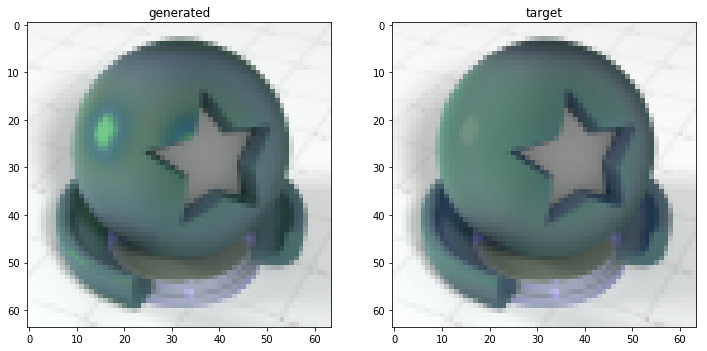

Epoch: 1209, Iter: 37500, MSE_loss: 15.86


<Figure size 432x288 with 0 Axes>

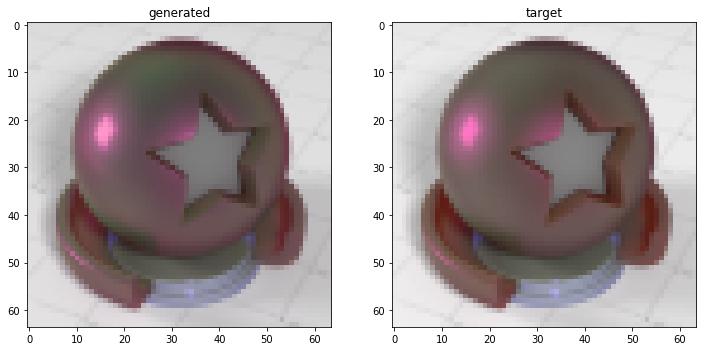

Epoch: 1225, Iter: 38000, MSE_loss: 14.93


<Figure size 432x288 with 0 Axes>

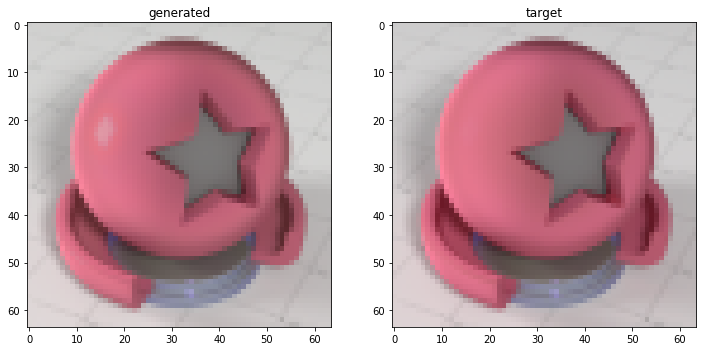

Epoch: 1241, Iter: 38500, MSE_loss: 10.11


<Figure size 432x288 with 0 Axes>

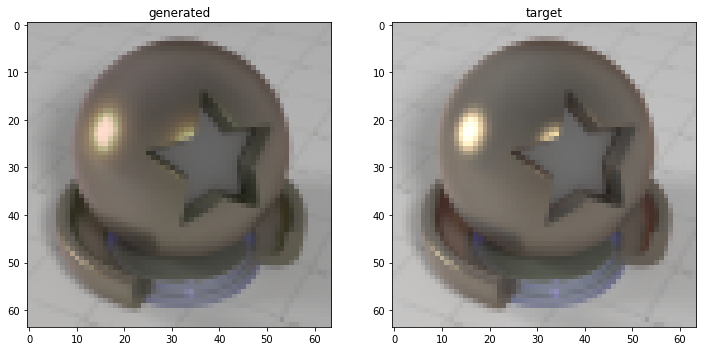

Epoch: 1258, Iter: 39000, MSE_loss: 14.94


<Figure size 432x288 with 0 Axes>

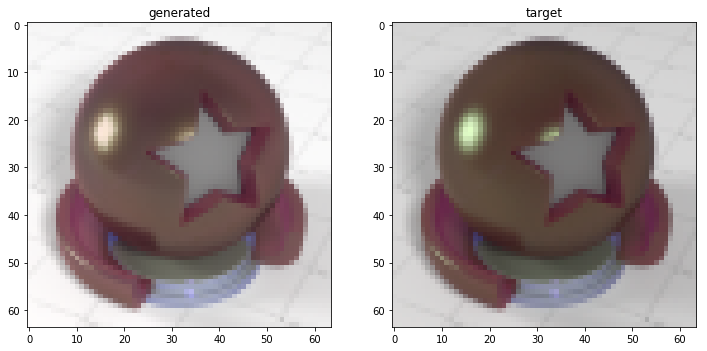

Epoch: 1274, Iter: 39500, MSE_loss: 12.93


<Figure size 432x288 with 0 Axes>

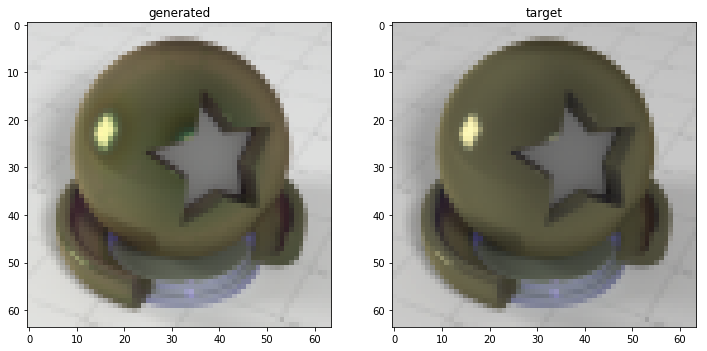

Epoch: 1290, Iter: 40000, MSE_loss: 14.77


<Figure size 432x288 with 0 Axes>

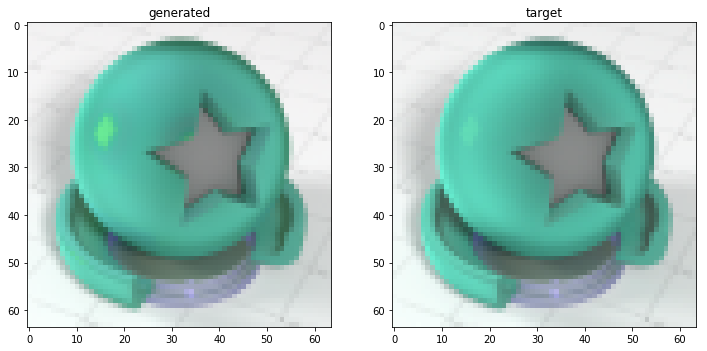

Epoch: 1306, Iter: 40500, MSE_loss: 13.83


<Figure size 432x288 with 0 Axes>

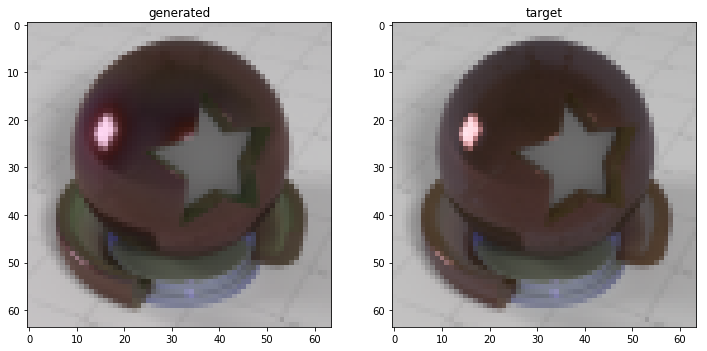

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1322, Iter: 41000, MSE_loss: 14.08


<Figure size 432x288 with 0 Axes>

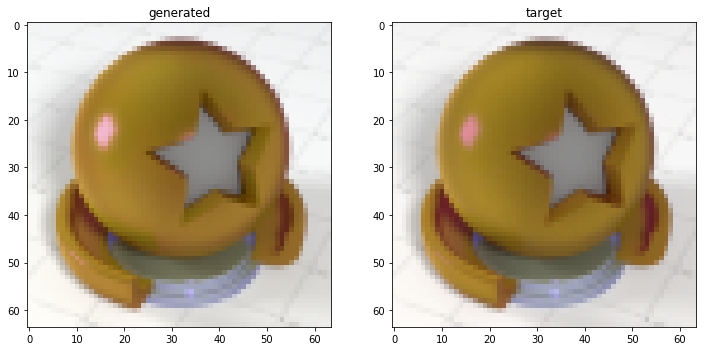

Epoch: 1338, Iter: 41500, MSE_loss: 12.1


<Figure size 432x288 with 0 Axes>

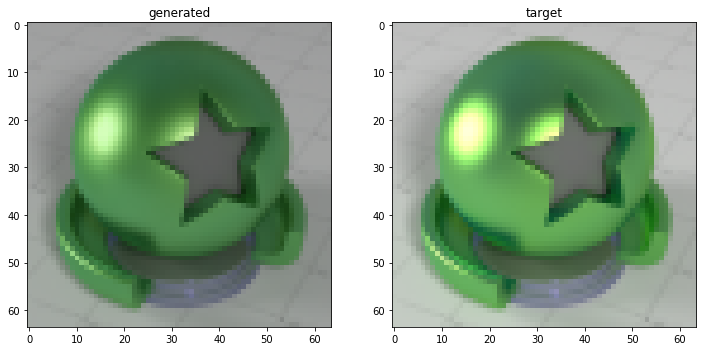

Epoch: 1354, Iter: 42000, MSE_loss: 15.05


<Figure size 432x288 with 0 Axes>

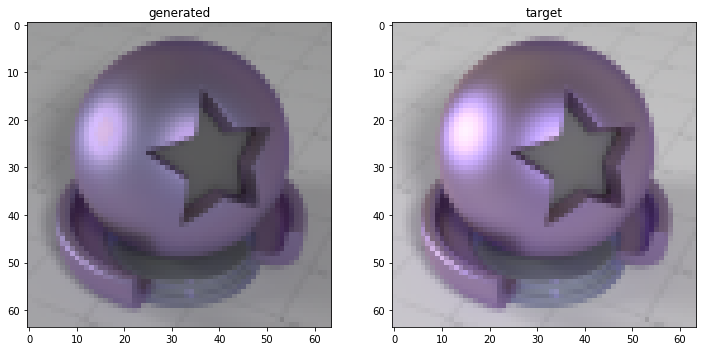

Epoch: 1370, Iter: 42500, MSE_loss: 12.49


<Figure size 432x288 with 0 Axes>

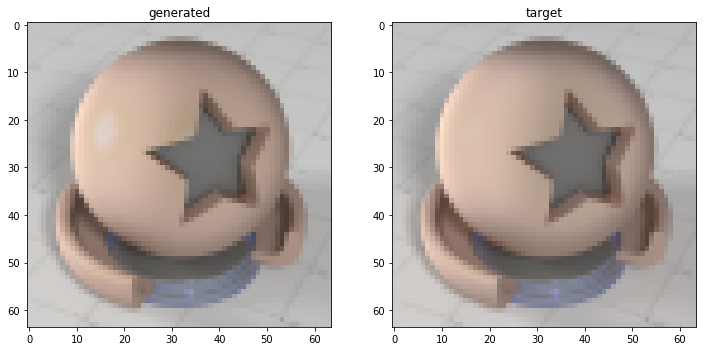

Epoch: 1387, Iter: 43000, MSE_loss: 13.0


<Figure size 432x288 with 0 Axes>

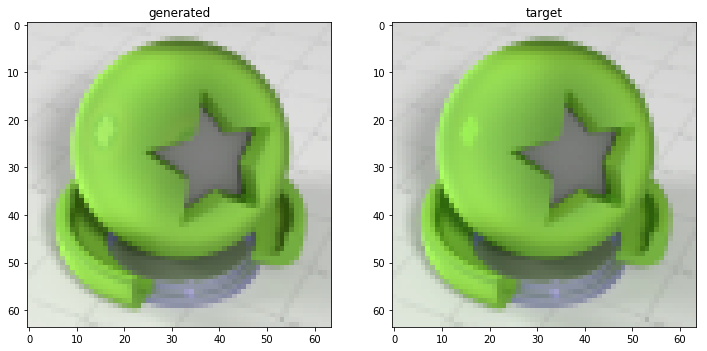

Epoch: 1403, Iter: 43500, MSE_loss: 11.77


<Figure size 432x288 with 0 Axes>

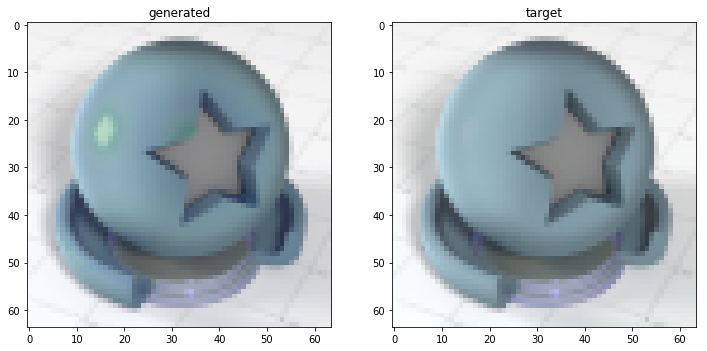

Epoch: 1419, Iter: 44000, MSE_loss: 15.0


<Figure size 432x288 with 0 Axes>

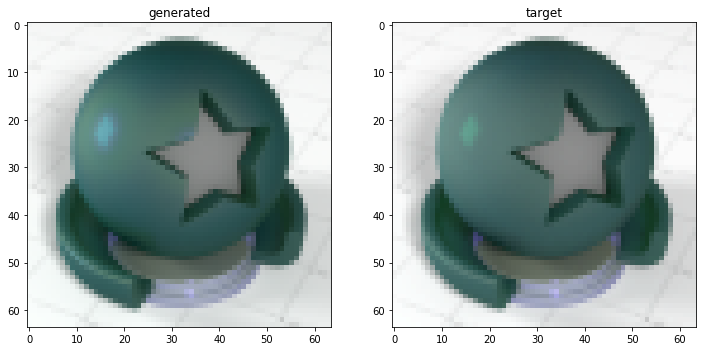

Epoch: 1435, Iter: 44500, MSE_loss: 12.81


<Figure size 432x288 with 0 Axes>

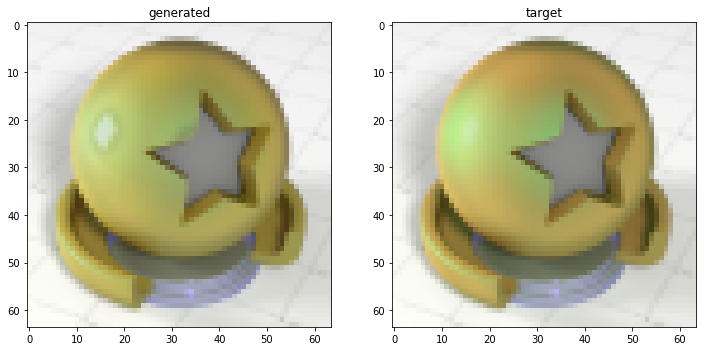

Epoch: 1451, Iter: 45000, MSE_loss: 9.338


<Figure size 432x288 with 0 Axes>

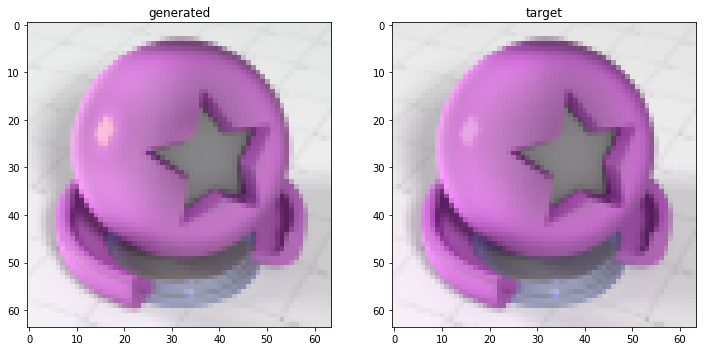

Epoch: 1467, Iter: 45500, MSE_loss: 16.37


<Figure size 432x288 with 0 Axes>

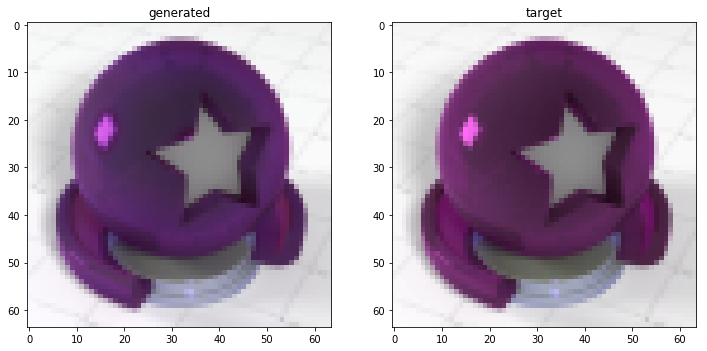

Epoch: 1483, Iter: 46000, MSE_loss: 12.95


<Figure size 432x288 with 0 Axes>

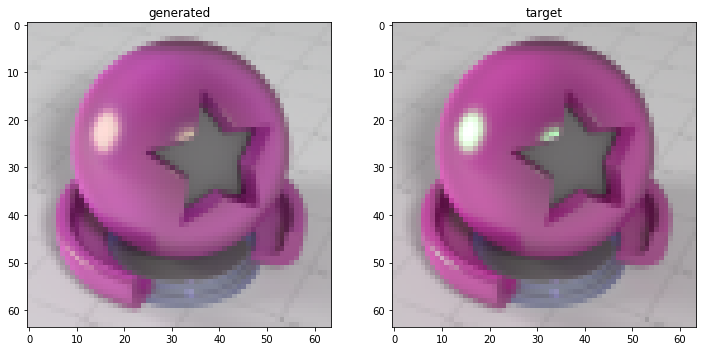

<Figure size 432x288 with 0 Axes>

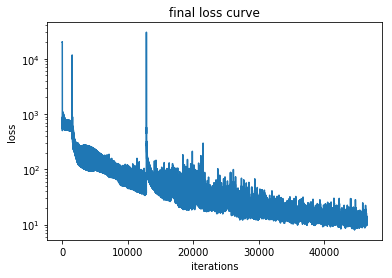

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Unflatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [193]:
##Experiment 1
#train model to learn 64 x 64 x 3 version of architecture of 1000 element train set.
#model is based on the original GMS paper (same number of 1D convs) but fewer upsample layers


CNN_Gen = CNN_generator().type(dtype)
CNN_Gen.apply(initialize_weights)

CNN_Gen_solver = get_optimizer(CNN_Gen)

loss_hist = run_CNN(CNN_Gen, CNN_Gen_solver,
                    loss_fn = nn.MSELoss(),
                    num_epochs=1500,
                    show_every = 500,loss_type="MSE_loss")
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.semilogy(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final loss curve")
plt.savefig('./../Models/CNN/Basemodel_final_loss_curve.png')
plt.show()
torch.save(CNN_Gen,"./../Models/CNN/Basemodel_Gen")

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch: 0, Iter: 0, MSE_loss: 2.004e+04


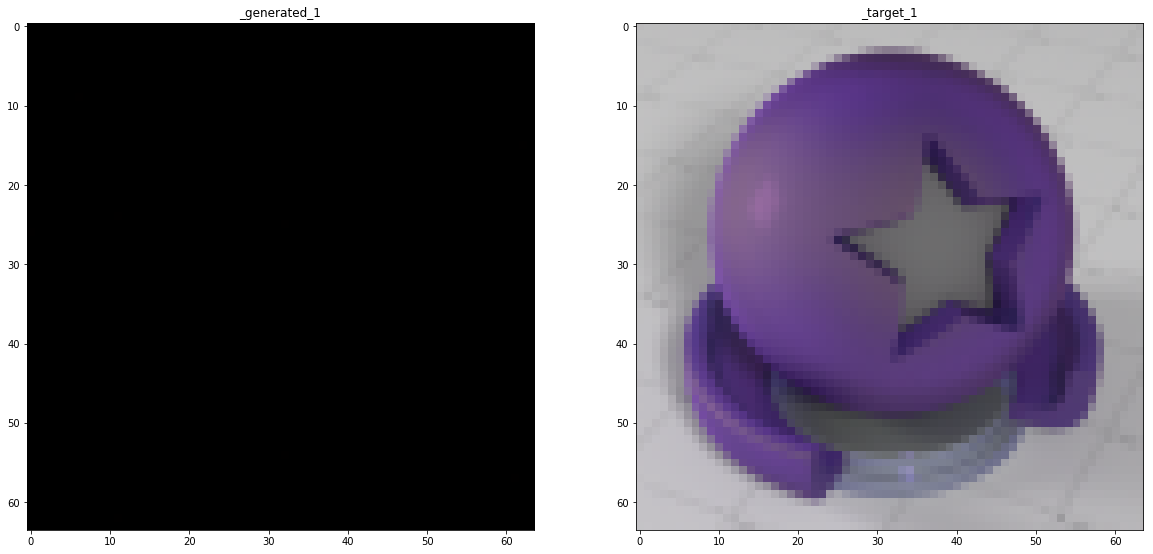

Epoch: 16, Iter: 500, MSE_loss: 196.5


<Figure size 720x576 with 0 Axes>

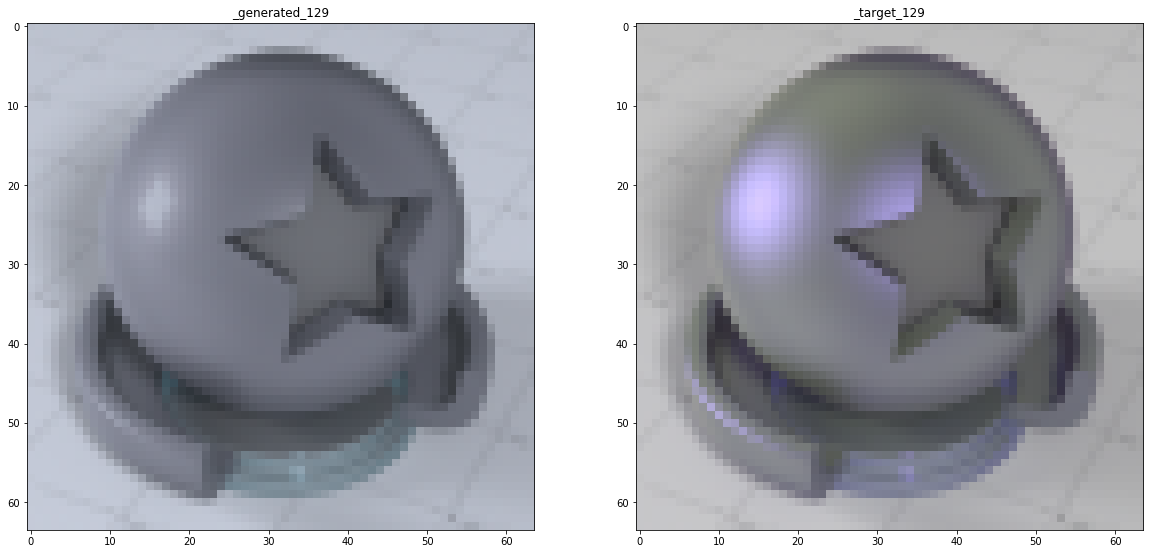

Epoch: 32, Iter: 1000, MSE_loss: 126.8


<Figure size 720x576 with 0 Axes>

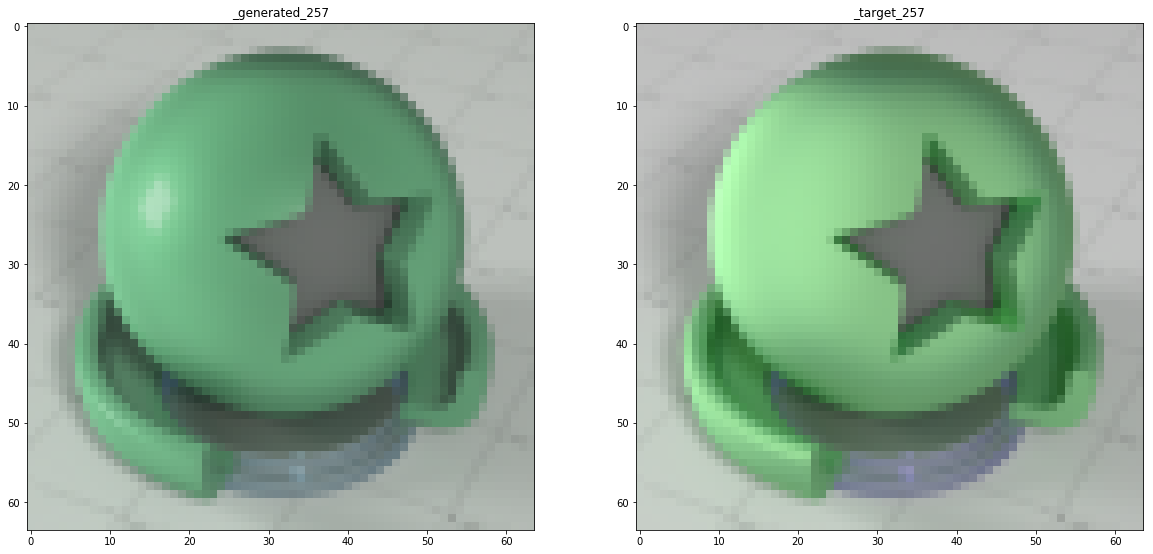

Epoch: 48, Iter: 1500, MSE_loss: 84.49


<Figure size 720x576 with 0 Axes>

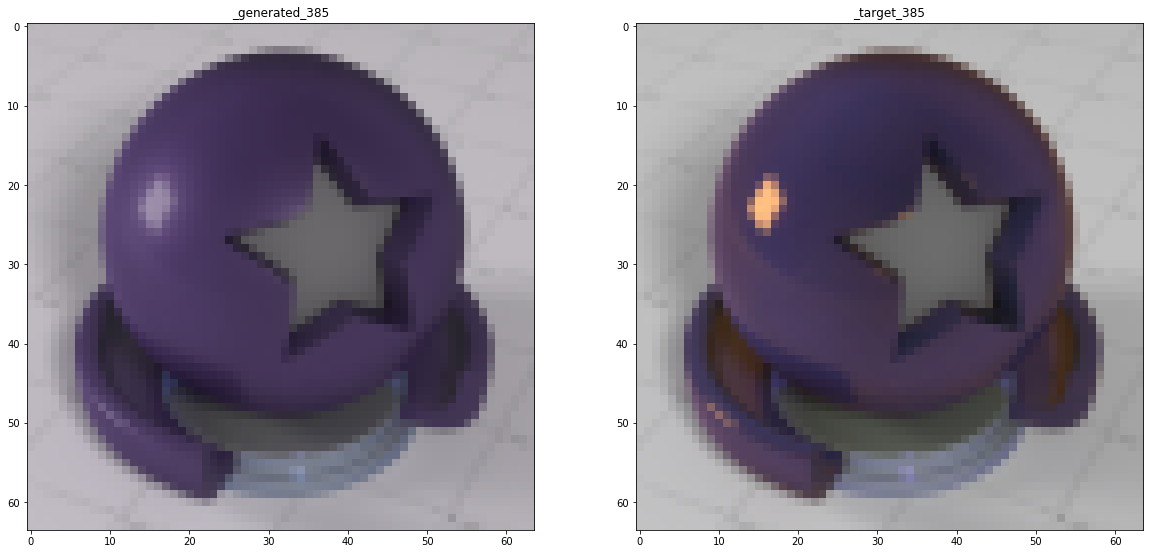

Epoch: 64, Iter: 2000, MSE_loss: 66.08


<Figure size 720x576 with 0 Axes>

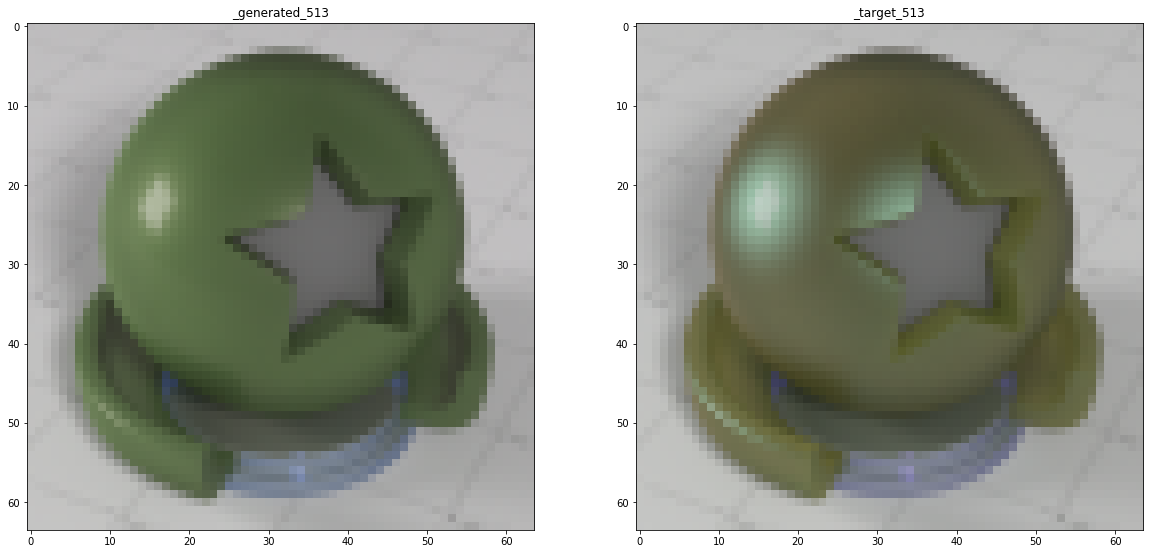

Epoch: 80, Iter: 2500, MSE_loss: 84.61


<Figure size 720x576 with 0 Axes>

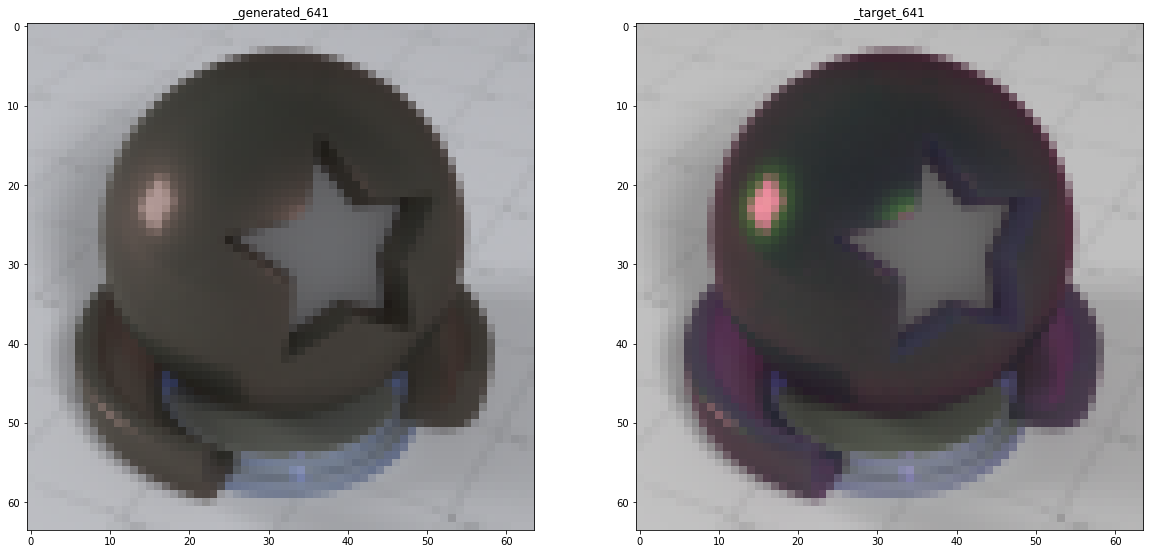

Epoch: 96, Iter: 3000, MSE_loss: 68.42


<Figure size 720x576 with 0 Axes>

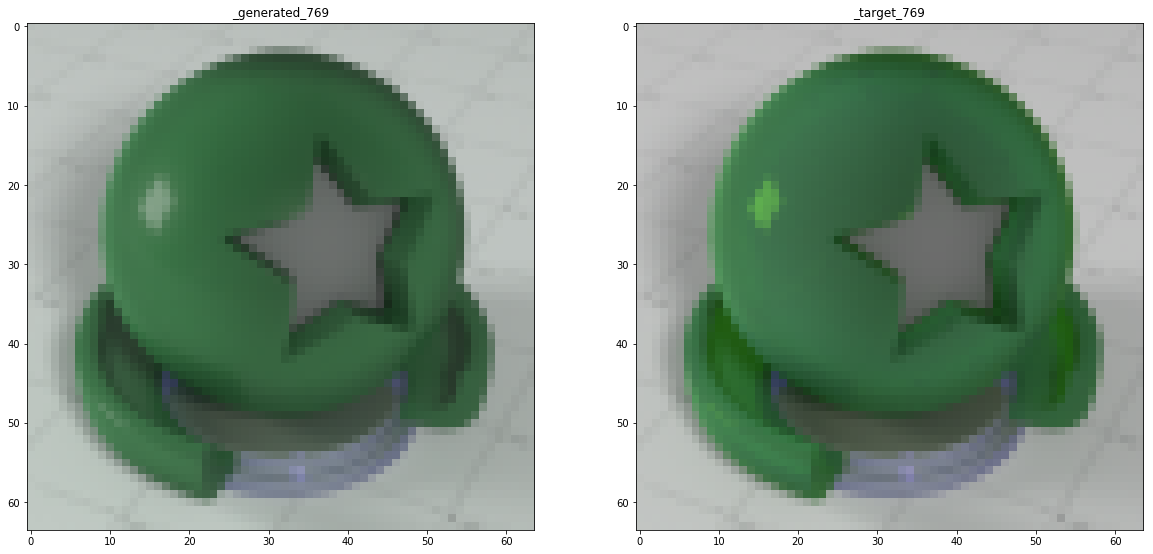

Epoch: 112, Iter: 3500, MSE_loss: 45.57


<Figure size 720x576 with 0 Axes>

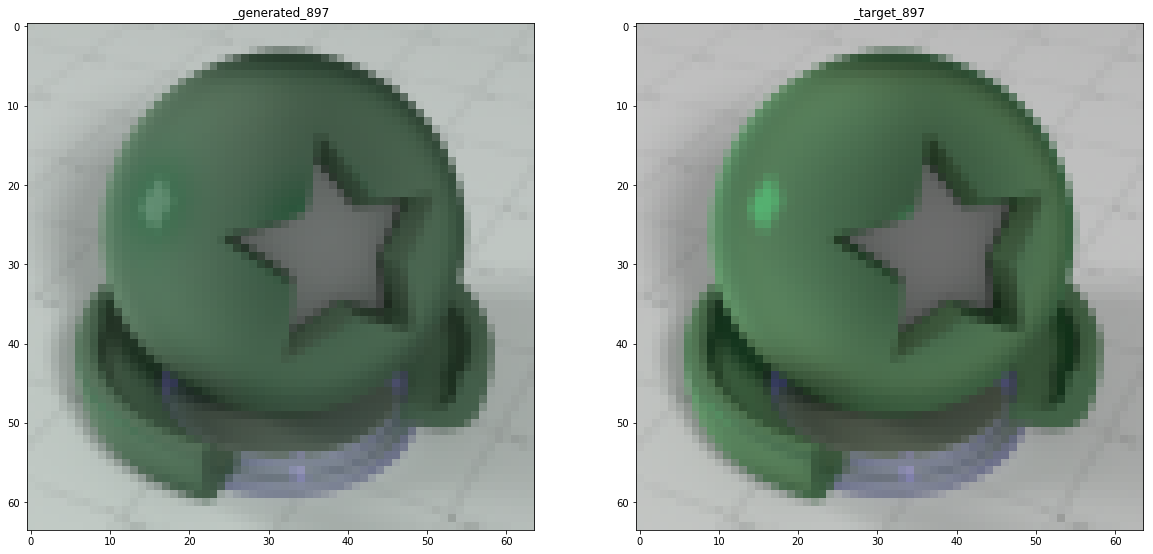

Epoch: 129, Iter: 4000, MSE_loss: 66.67


<Figure size 720x576 with 0 Axes>

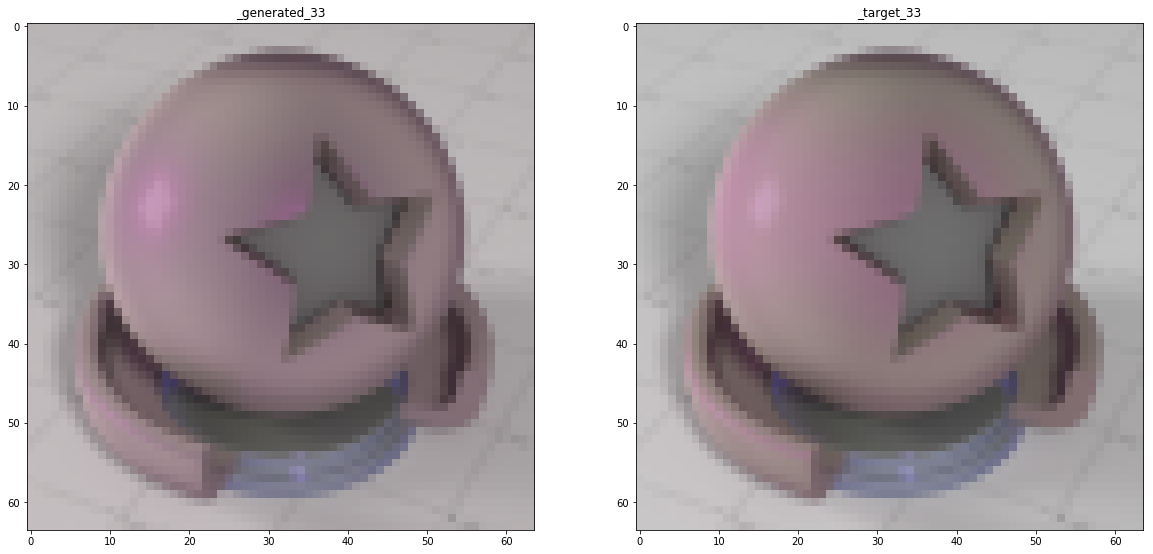

Epoch: 145, Iter: 4500, MSE_loss: 56.43


<Figure size 720x576 with 0 Axes>

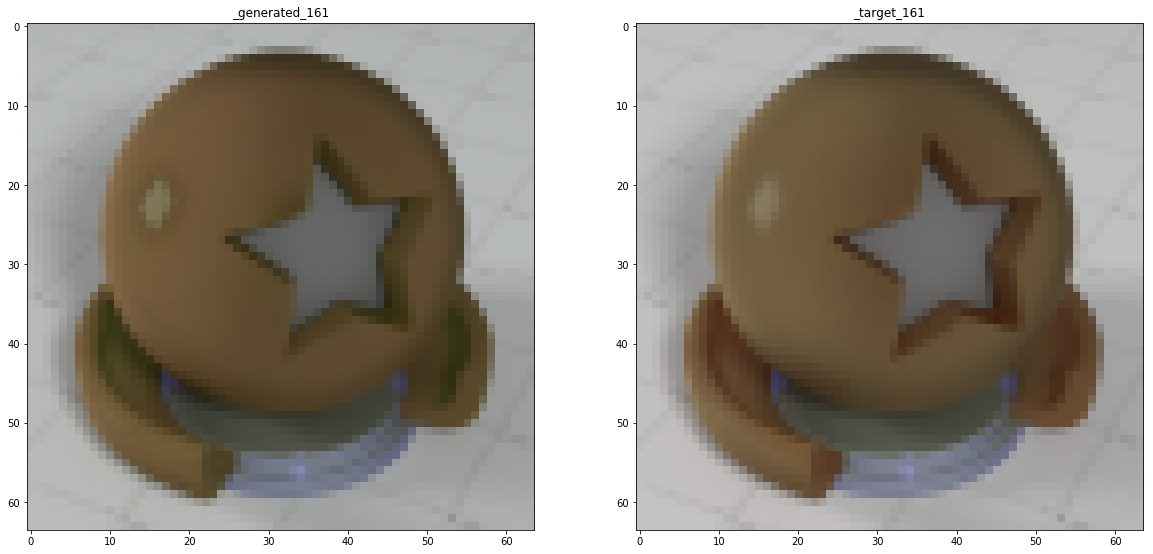

Epoch: 161, Iter: 5000, MSE_loss: 24.92


<Figure size 720x576 with 0 Axes>

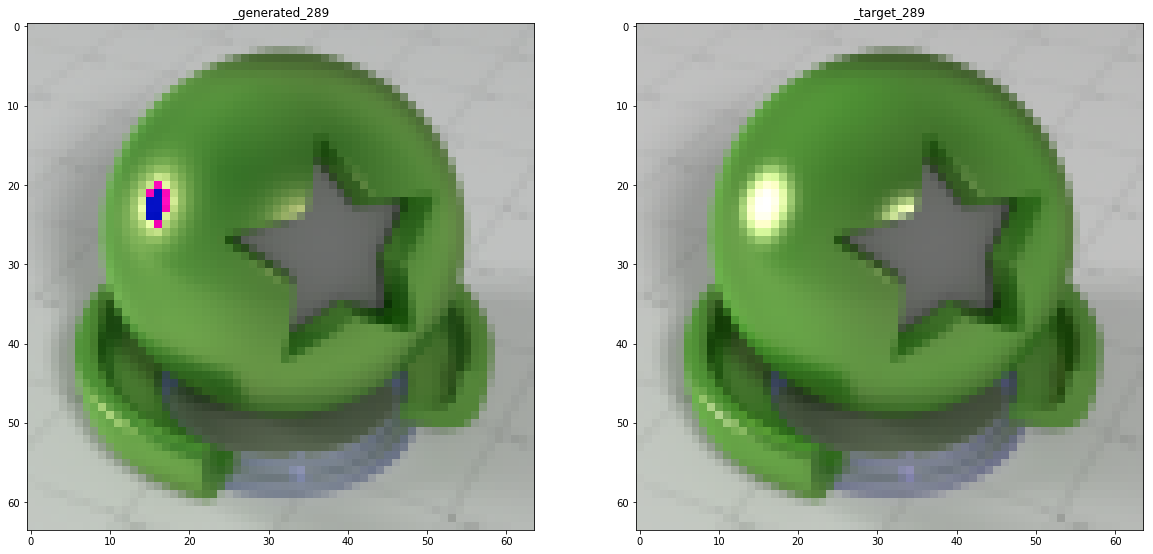

Epoch: 177, Iter: 5500, MSE_loss: 35.17


<Figure size 720x576 with 0 Axes>

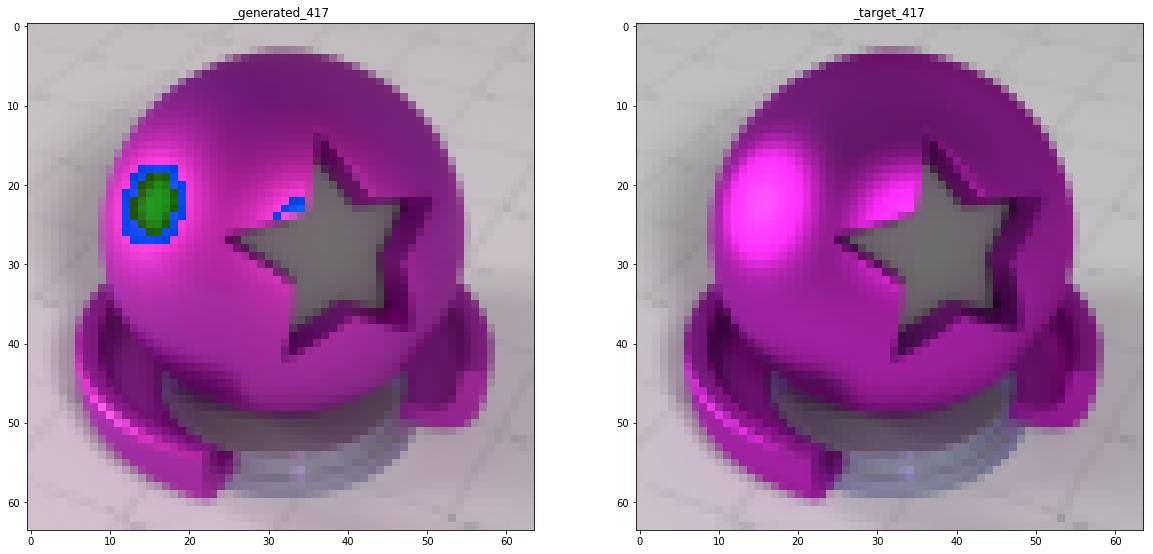

Epoch: 193, Iter: 6000, MSE_loss: 23.52


<Figure size 720x576 with 0 Axes>

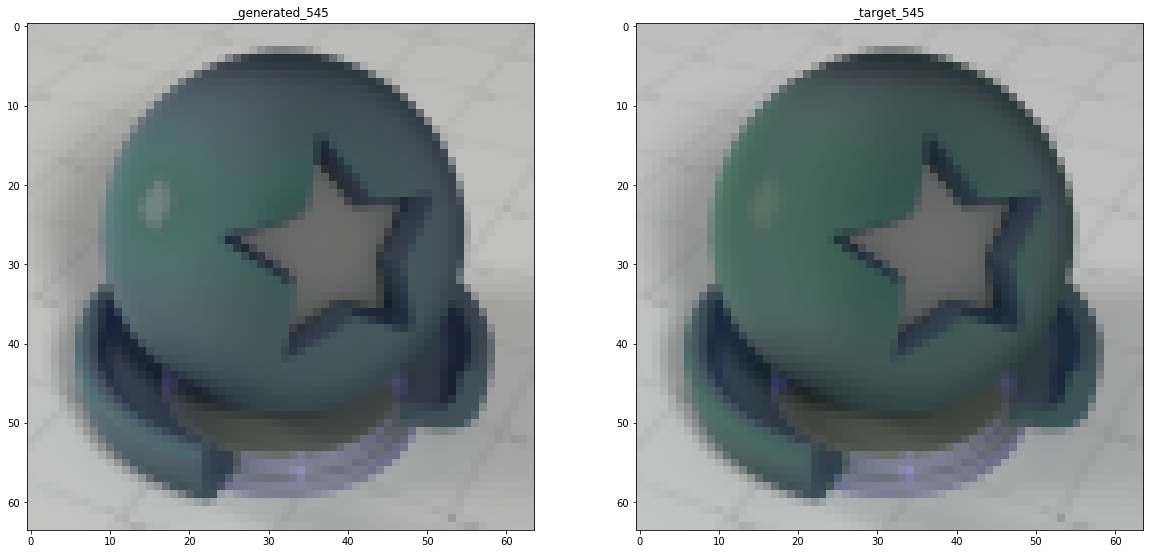

Epoch: 209, Iter: 6500, MSE_loss: 14.38


<Figure size 720x576 with 0 Axes>

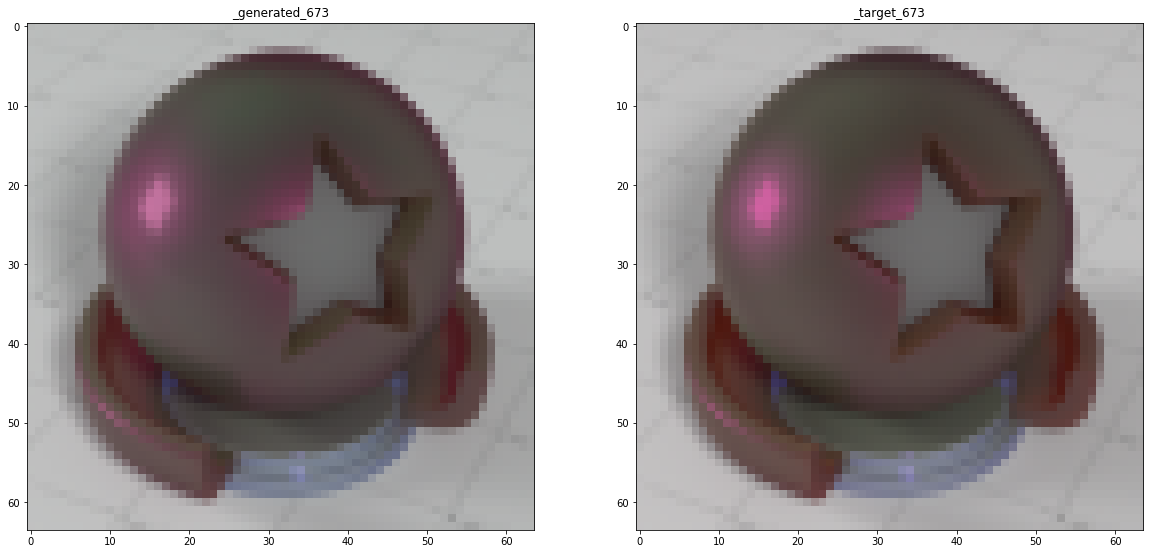

Epoch: 225, Iter: 7000, MSE_loss: 12.57


<Figure size 720x576 with 0 Axes>

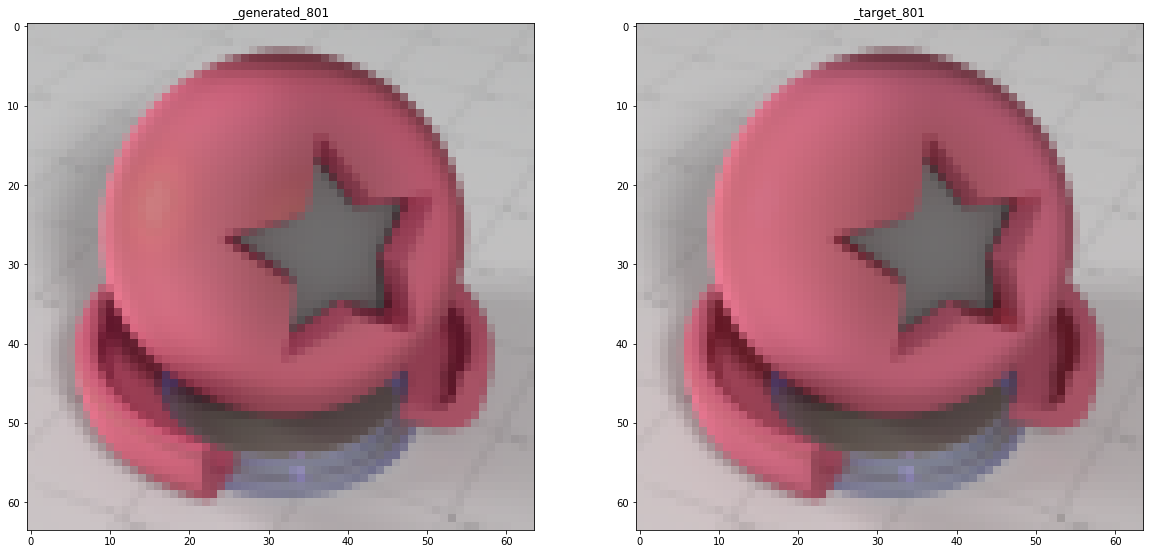

Epoch: 241, Iter: 7500, MSE_loss: 13.78


<Figure size 720x576 with 0 Axes>

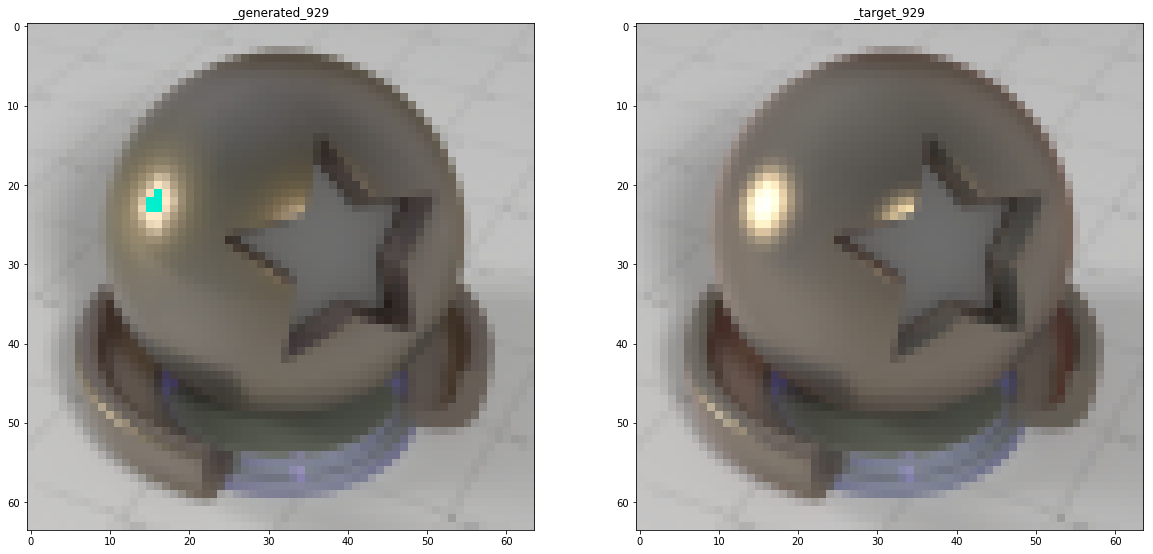

Epoch: 258, Iter: 8000, MSE_loss: 16.89


<Figure size 720x576 with 0 Axes>

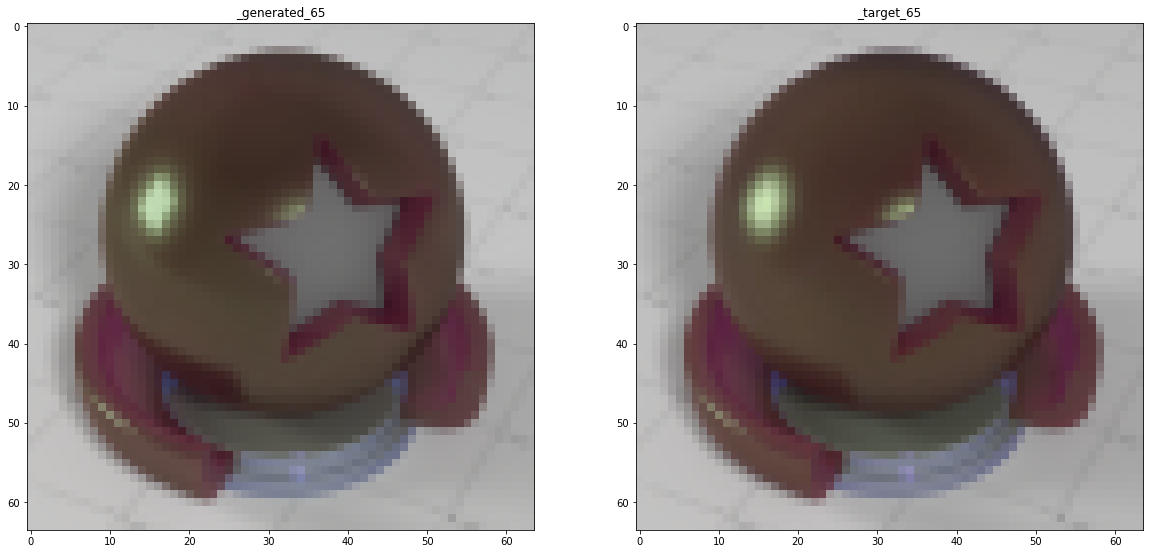

Epoch: 274, Iter: 8500, MSE_loss: 19.76


<Figure size 720x576 with 0 Axes>

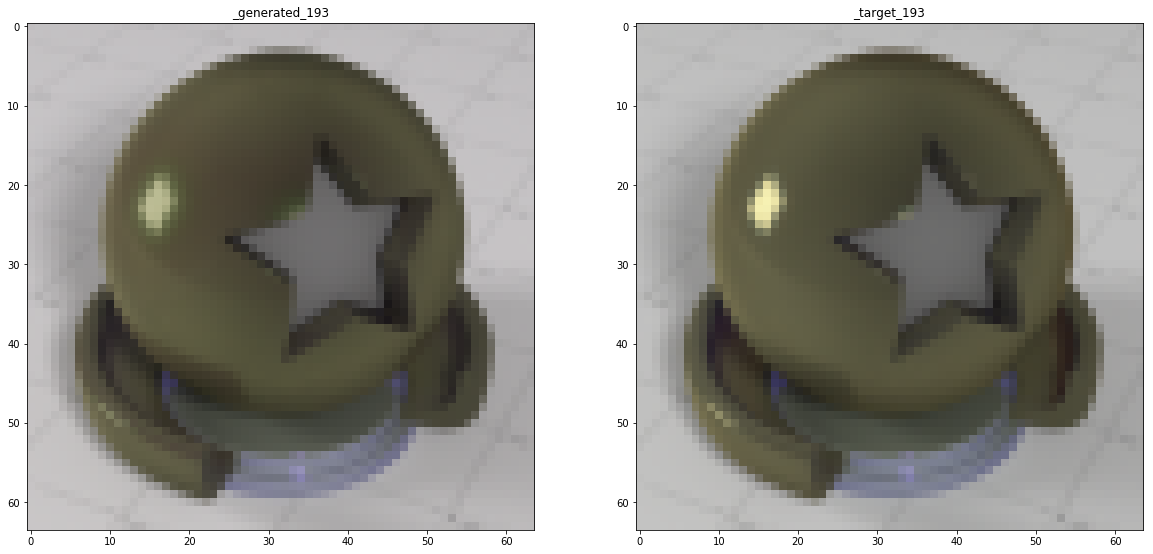

Epoch: 290, Iter: 9000, MSE_loss: 14.14


<Figure size 720x576 with 0 Axes>

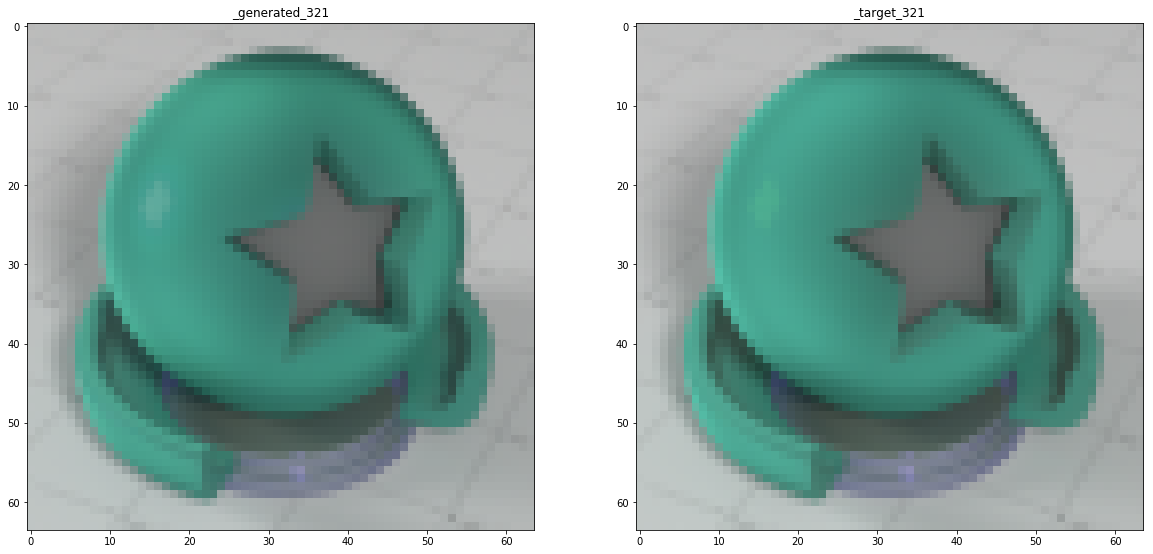

Epoch: 306, Iter: 9500, MSE_loss: 14.58


<Figure size 720x576 with 0 Axes>

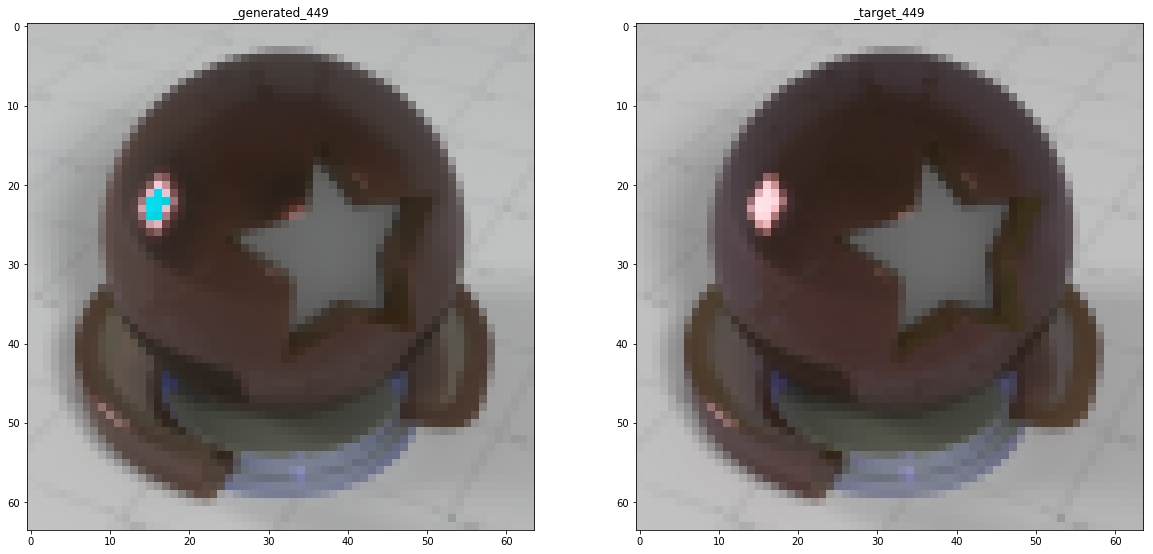

Epoch: 322, Iter: 10000, MSE_loss: 15.3


<Figure size 720x576 with 0 Axes>

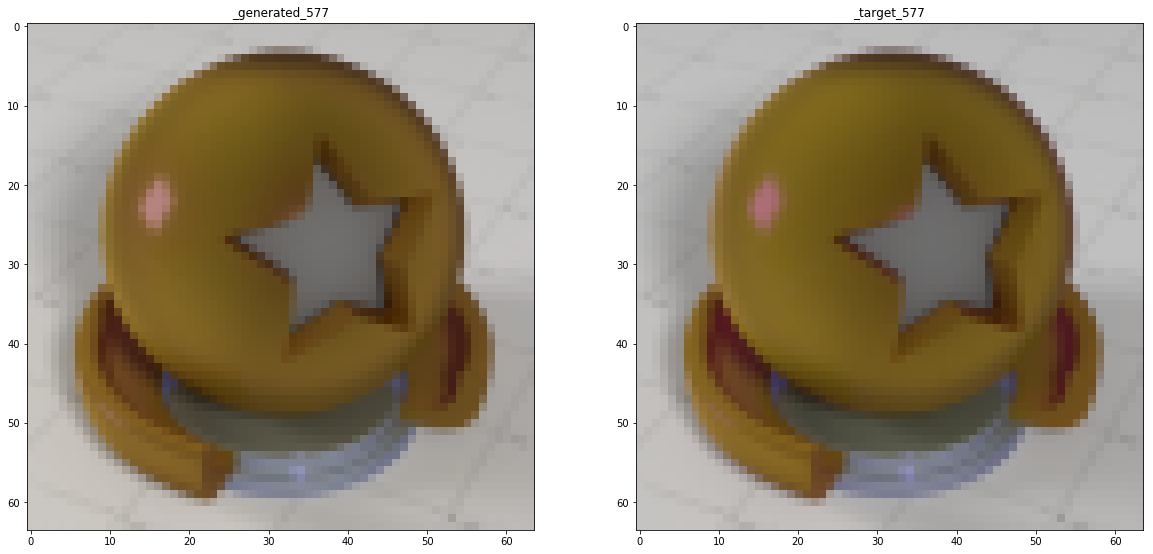

Epoch: 338, Iter: 10500, MSE_loss: 35.86


<Figure size 720x576 with 0 Axes>

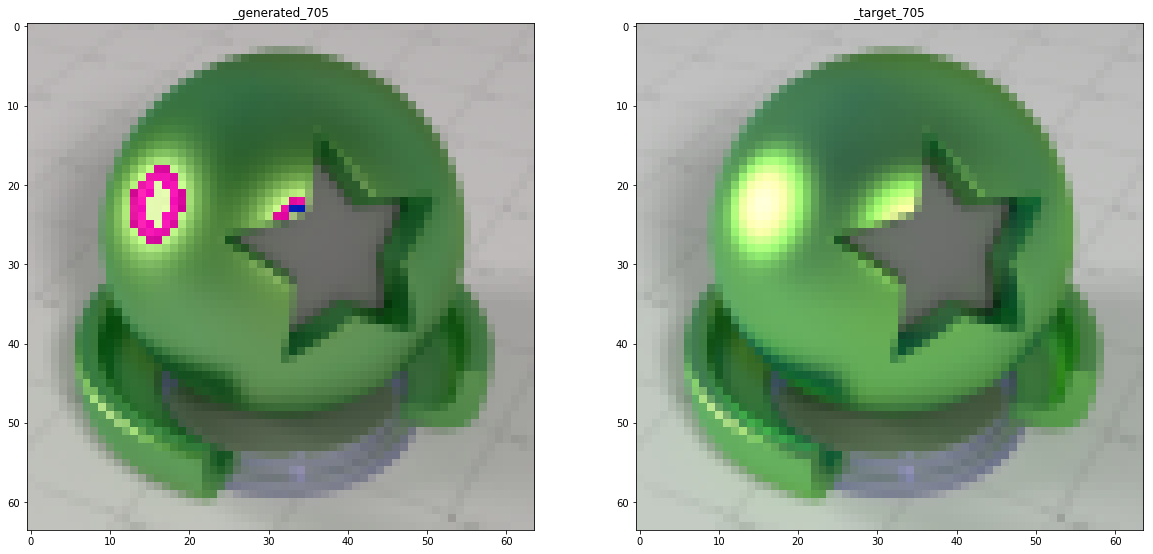

Epoch: 354, Iter: 11000, MSE_loss: 20.68


<Figure size 720x576 with 0 Axes>

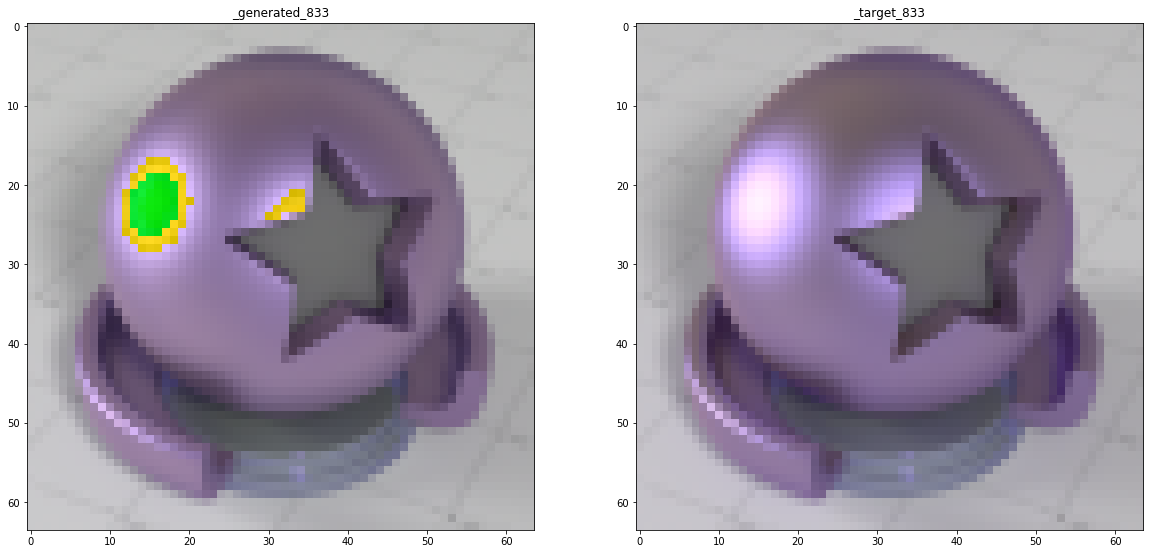

Epoch: 370, Iter: 11500, MSE_loss: 20.78


<Figure size 720x576 with 0 Axes>

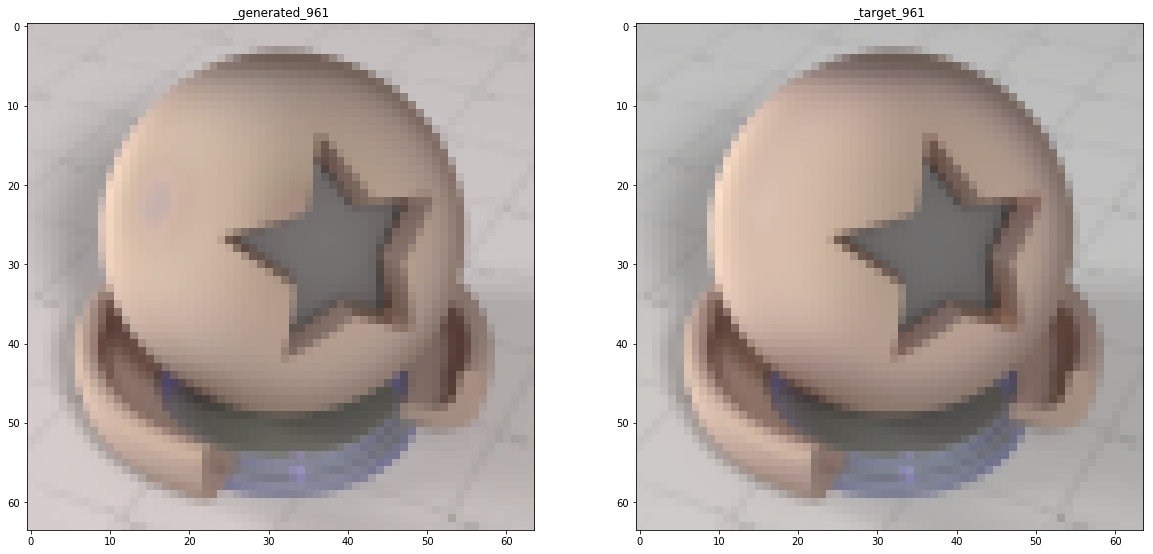

Epoch: 387, Iter: 12000, MSE_loss: 23.36


<Figure size 720x576 with 0 Axes>

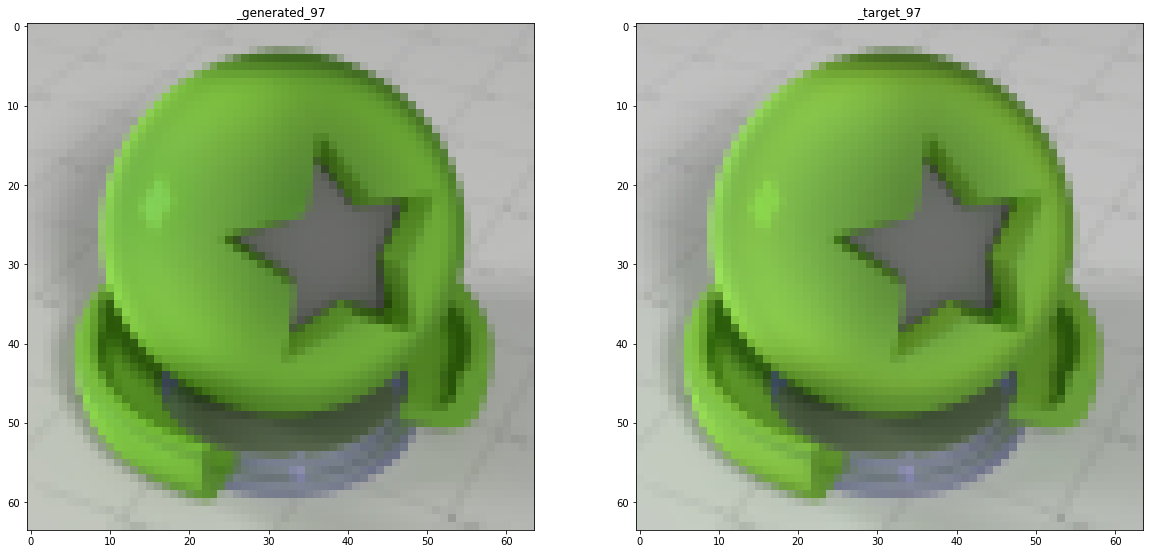

Epoch: 403, Iter: 12500, MSE_loss: 26.64


<Figure size 720x576 with 0 Axes>

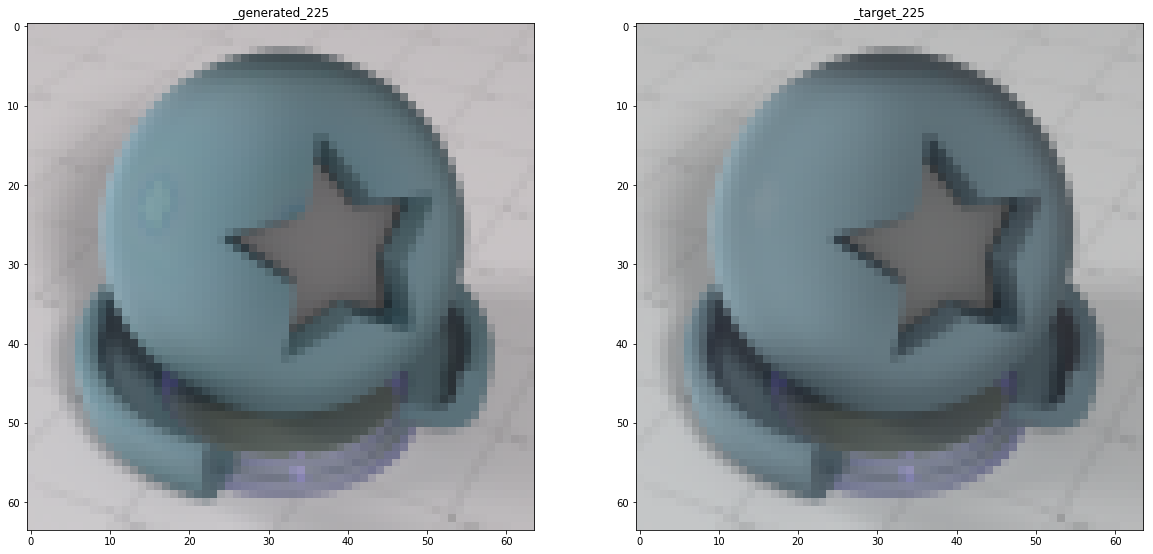

Epoch: 419, Iter: 13000, MSE_loss: 30.14


<Figure size 720x576 with 0 Axes>

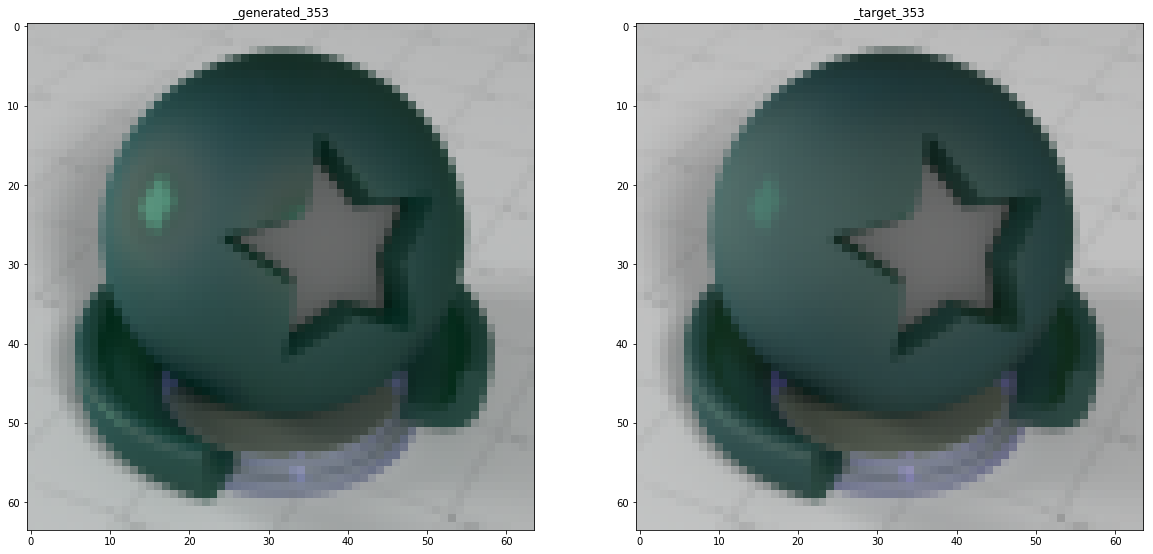

Epoch: 435, Iter: 13500, MSE_loss: 18.88


<Figure size 720x576 with 0 Axes>

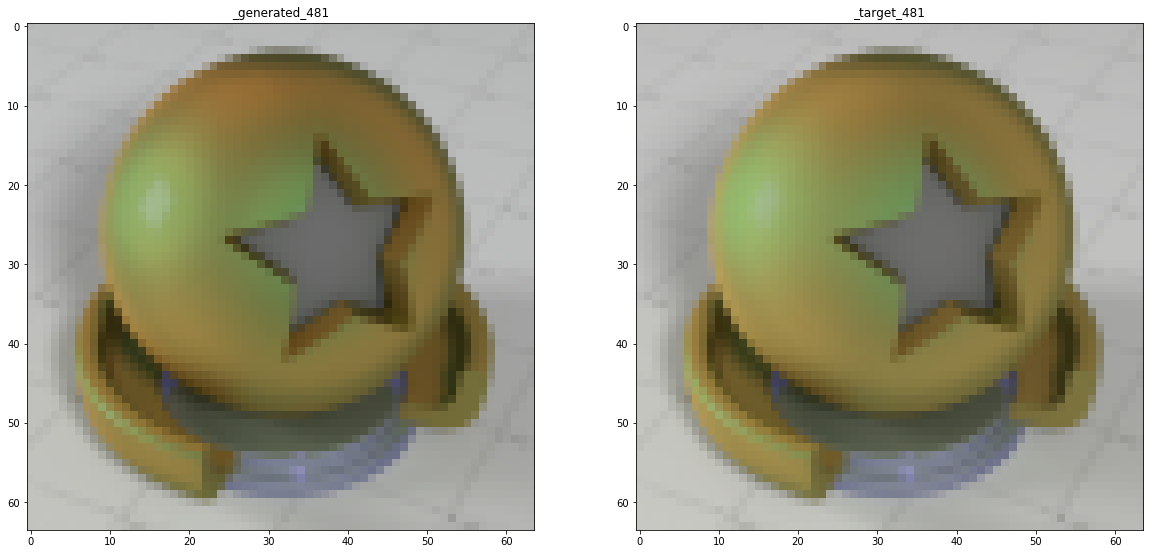

Epoch: 451, Iter: 14000, MSE_loss: 9.166


<Figure size 720x576 with 0 Axes>

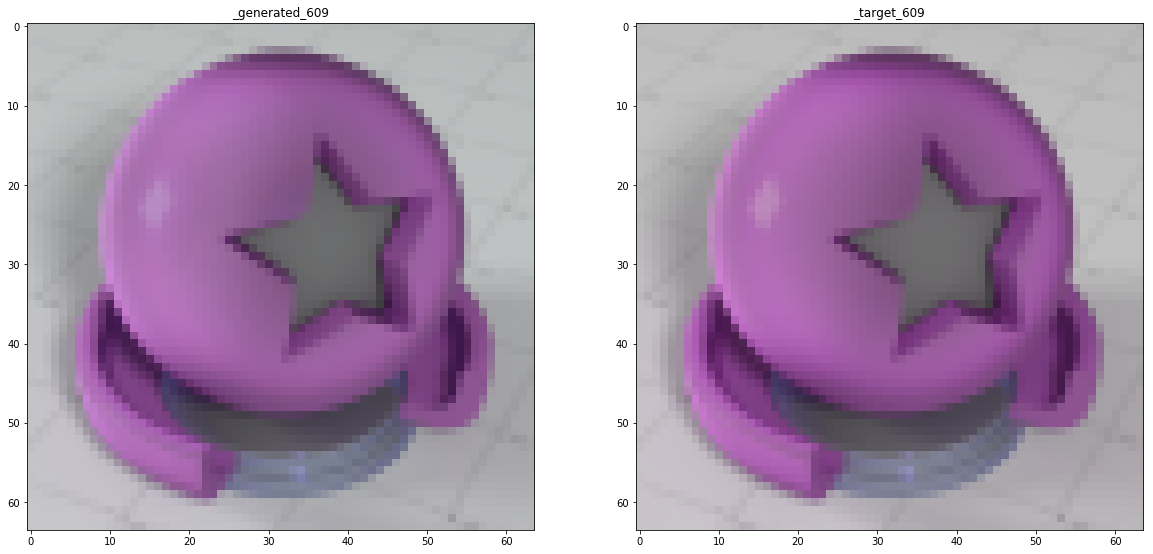

Epoch: 467, Iter: 14500, MSE_loss: 23.47


<Figure size 720x576 with 0 Axes>

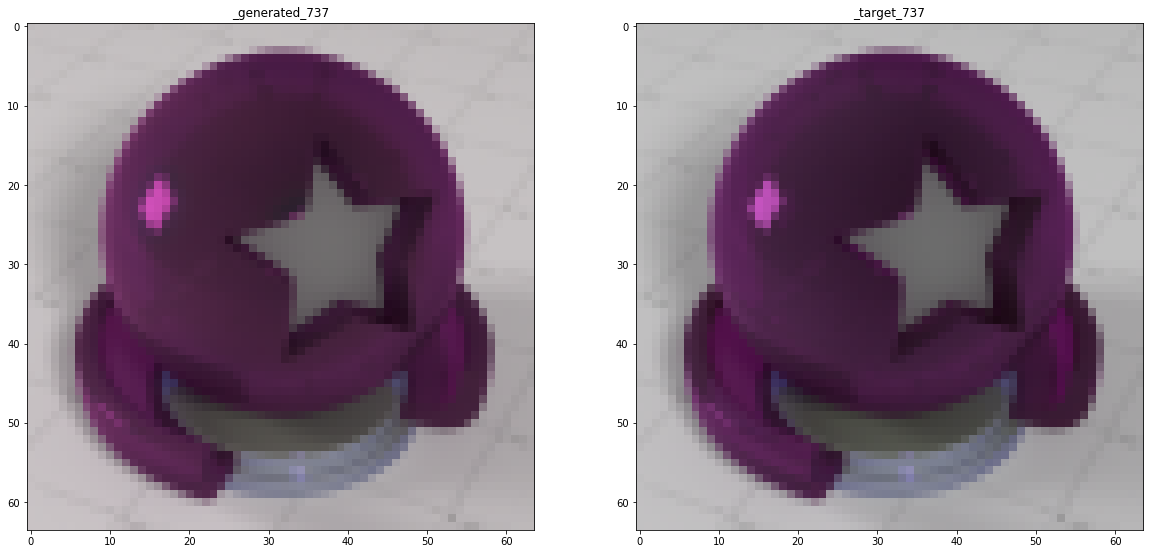

Epoch: 483, Iter: 15000, MSE_loss: 8.795


<Figure size 720x576 with 0 Axes>

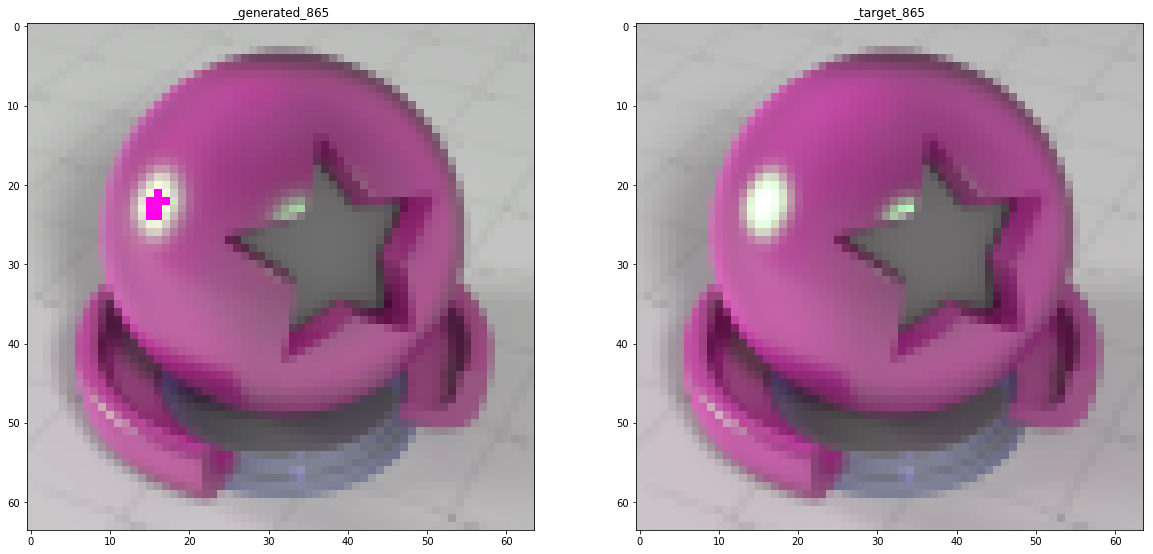

Epoch: 500, Iter: 15500, MSE_loss: 8.341


<Figure size 720x576 with 0 Axes>

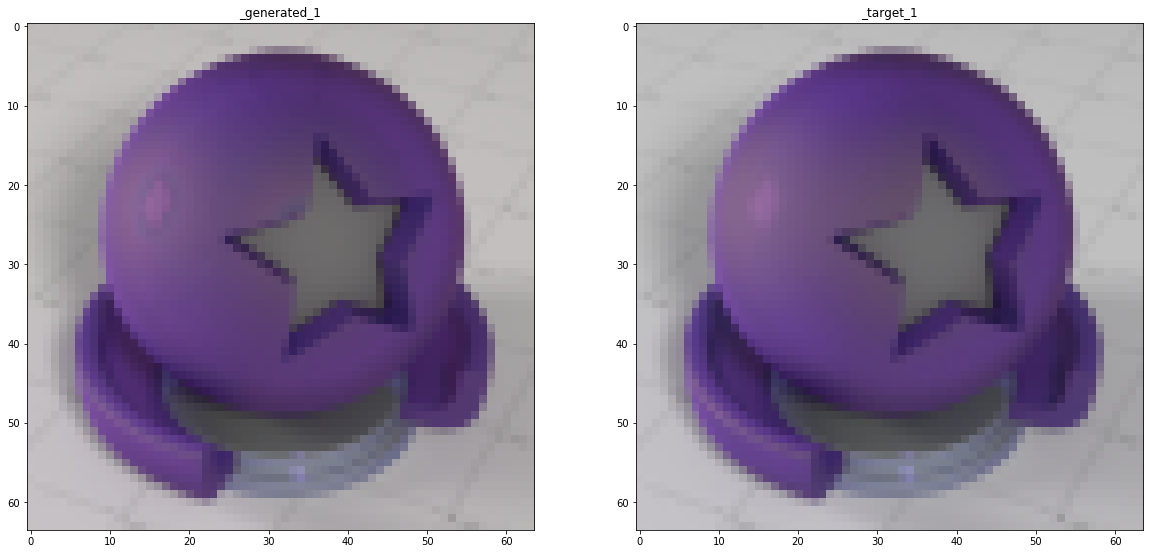

Epoch: 516, Iter: 16000, MSE_loss: 8.505


<Figure size 720x576 with 0 Axes>

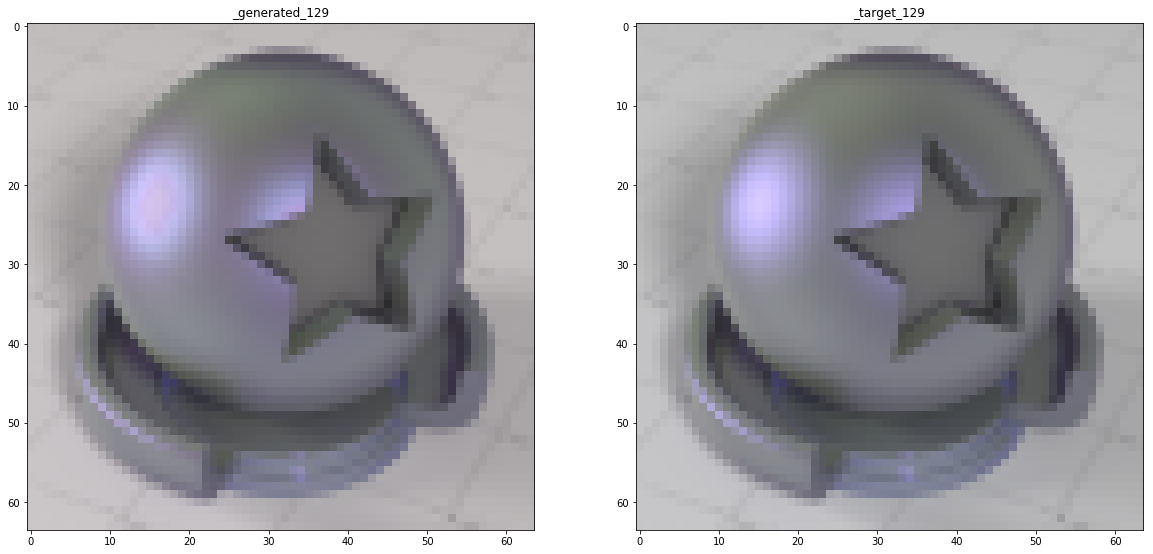

Epoch: 532, Iter: 16500, MSE_loss: 10.73


<Figure size 720x576 with 0 Axes>

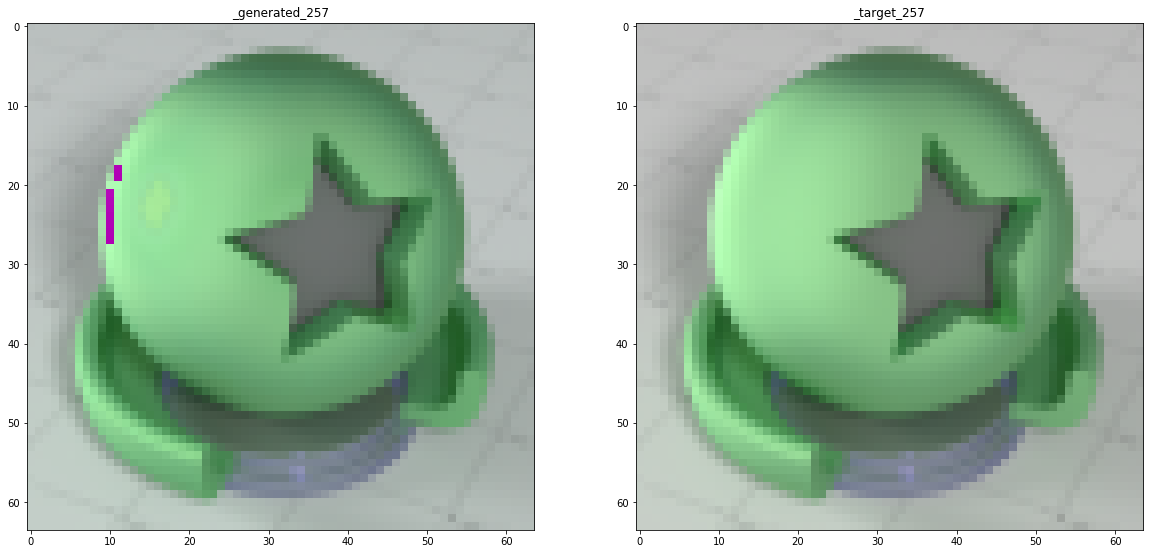

Epoch: 548, Iter: 17000, MSE_loss: 9.75


<Figure size 720x576 with 0 Axes>

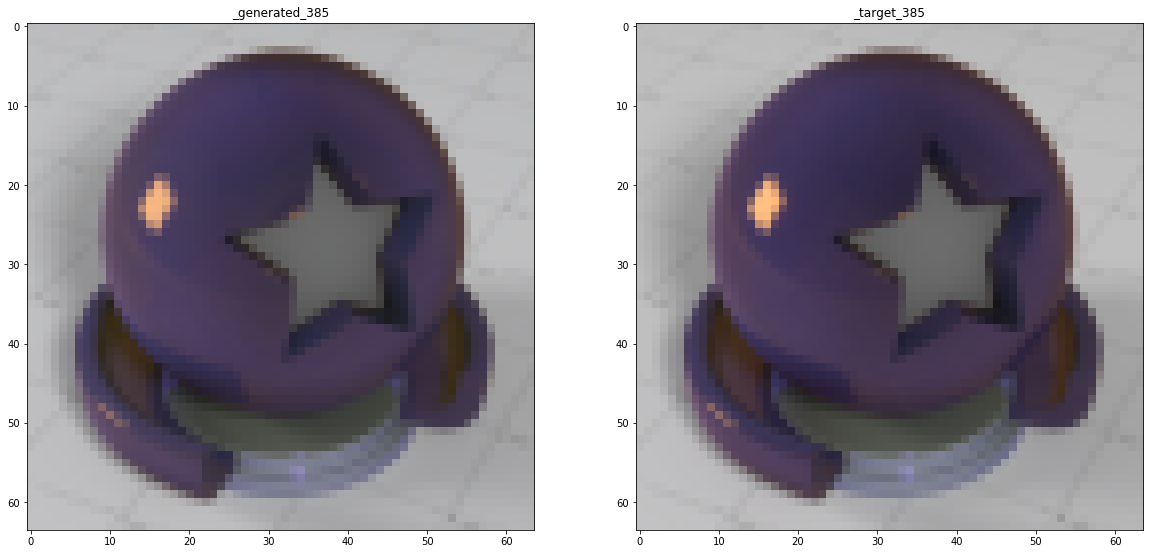

Epoch: 564, Iter: 17500, MSE_loss: 8.802


<Figure size 720x576 with 0 Axes>

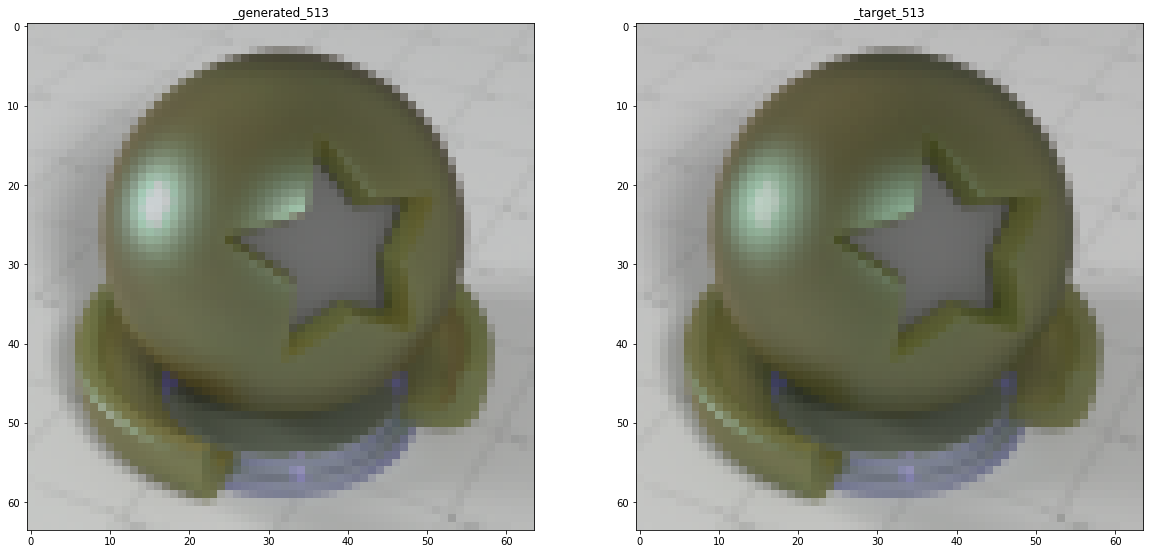

Epoch: 580, Iter: 18000, MSE_loss: 17.97


<Figure size 720x576 with 0 Axes>

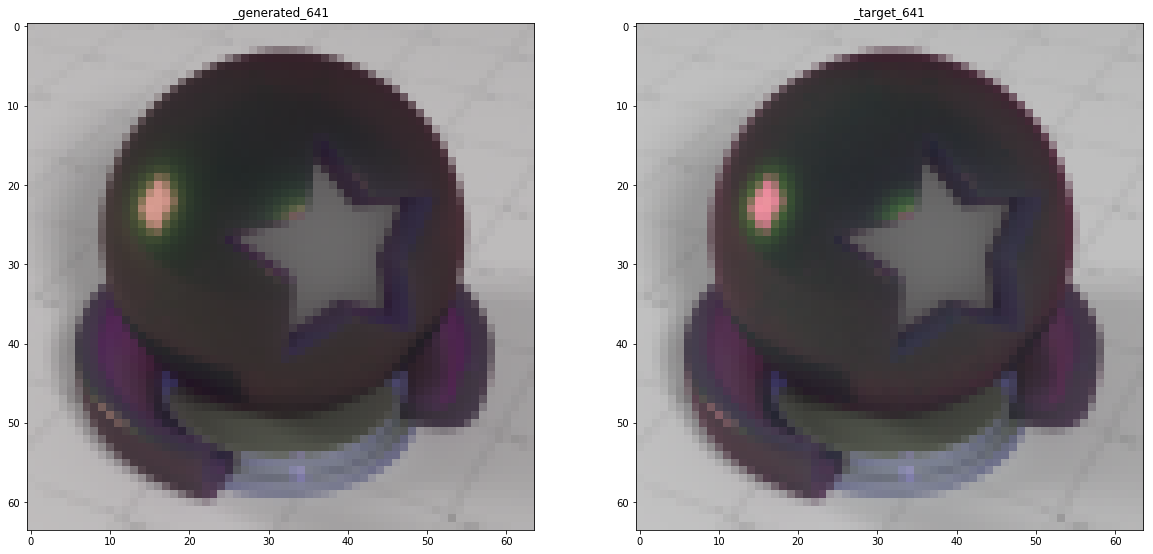

Epoch: 596, Iter: 18500, MSE_loss: 14.56


<Figure size 720x576 with 0 Axes>

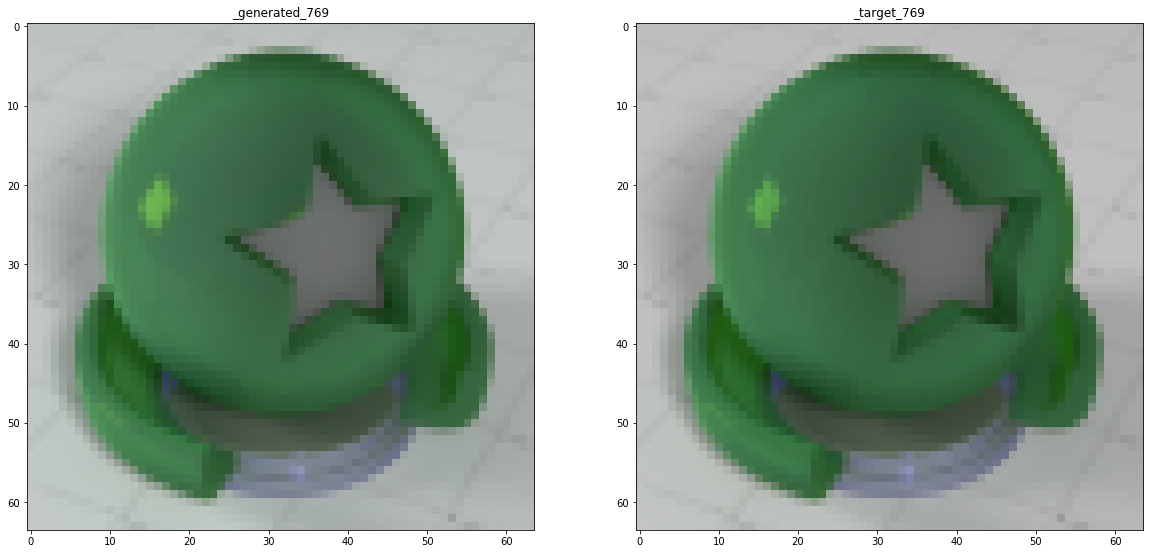

Epoch: 612, Iter: 19000, MSE_loss: 6.117


<Figure size 720x576 with 0 Axes>

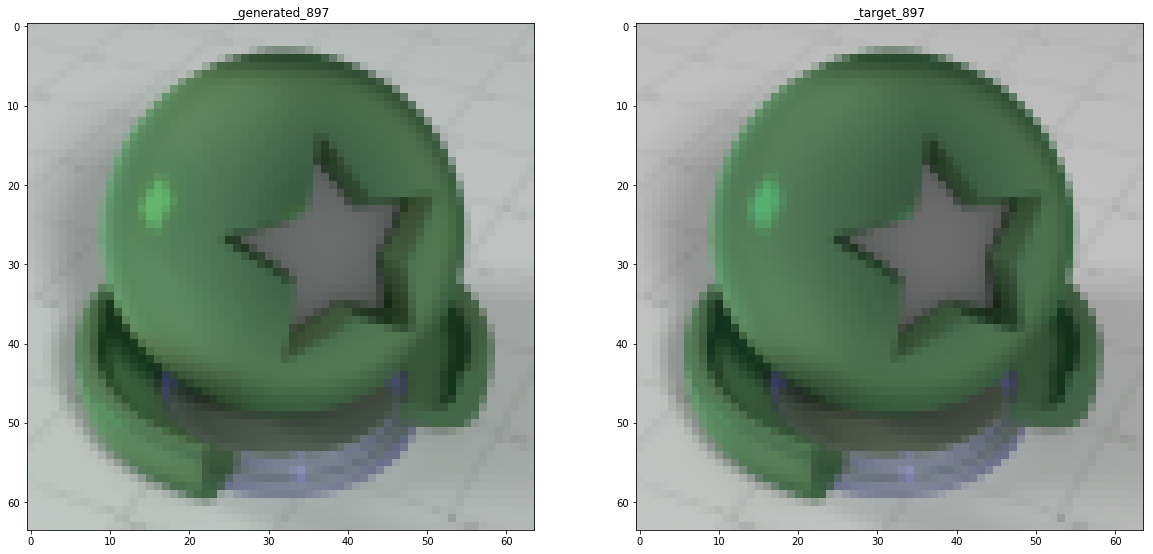

Epoch: 629, Iter: 19500, MSE_loss: 8.146


<Figure size 720x576 with 0 Axes>

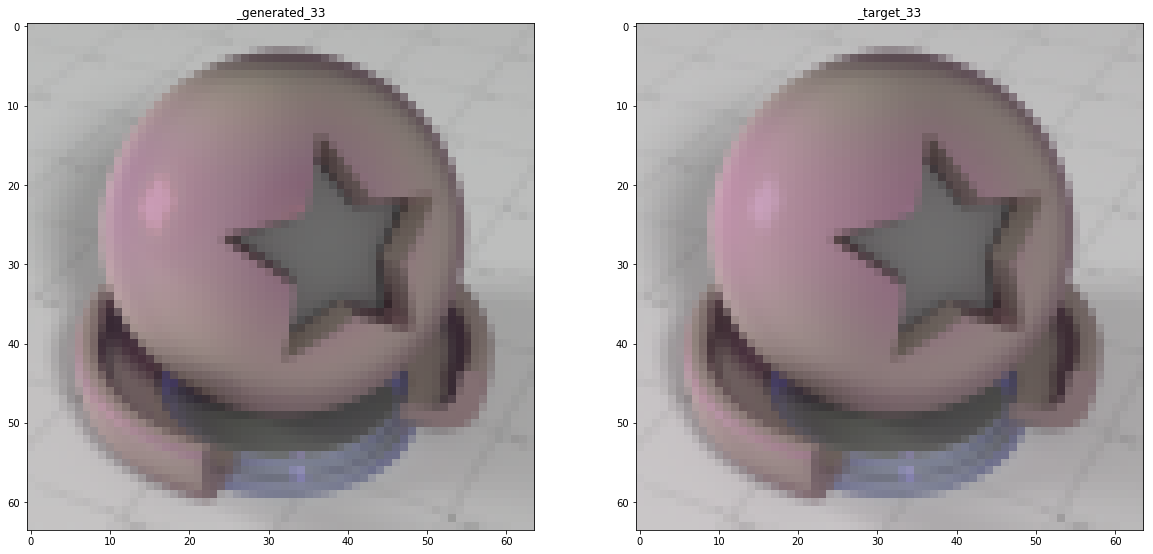

Epoch: 645, Iter: 20000, MSE_loss: 11.99


<Figure size 720x576 with 0 Axes>

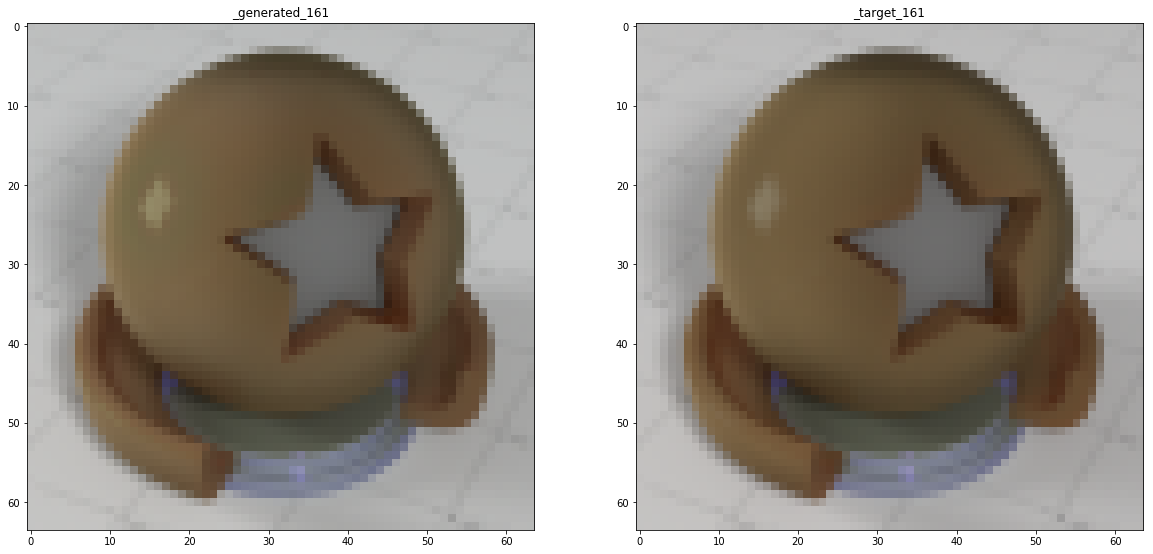

Epoch: 661, Iter: 20500, MSE_loss: 14.64


<Figure size 720x576 with 0 Axes>

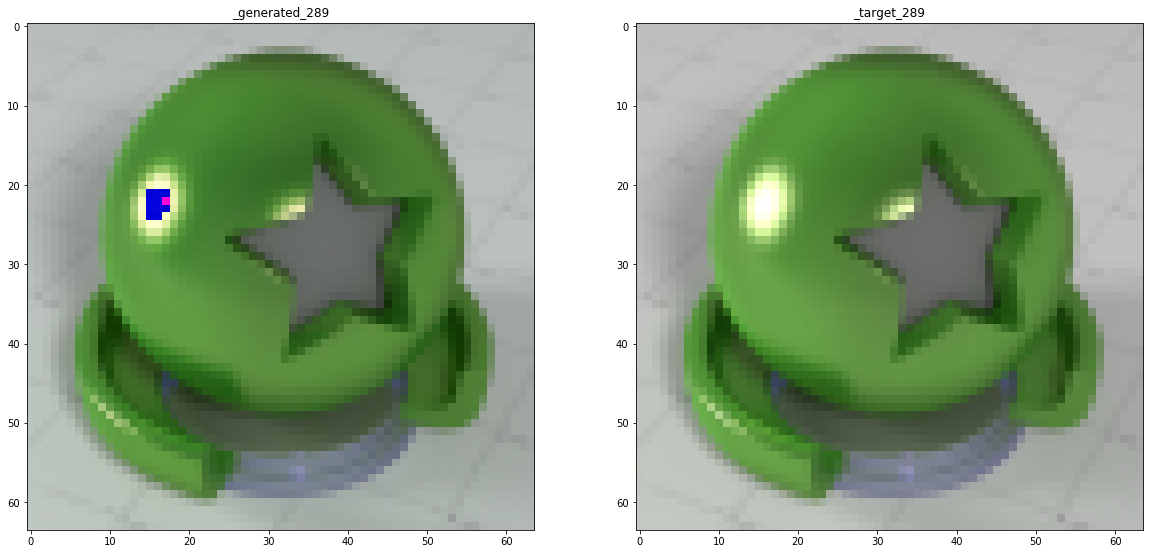

Epoch: 677, Iter: 21000, MSE_loss: 11.06


<Figure size 720x576 with 0 Axes>

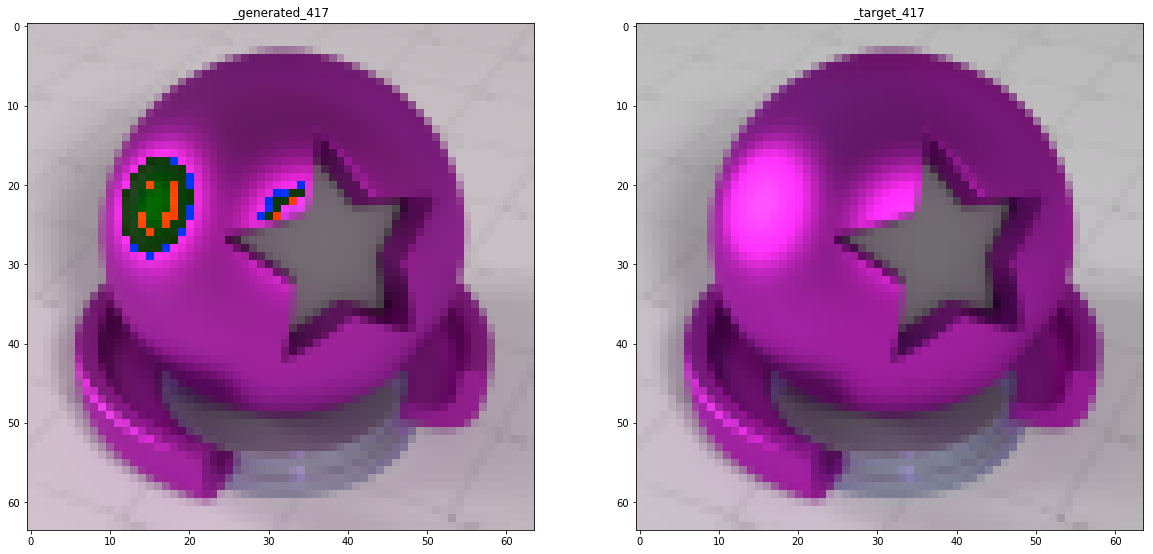

Epoch: 693, Iter: 21500, MSE_loss: 3.884


<Figure size 720x576 with 0 Axes>

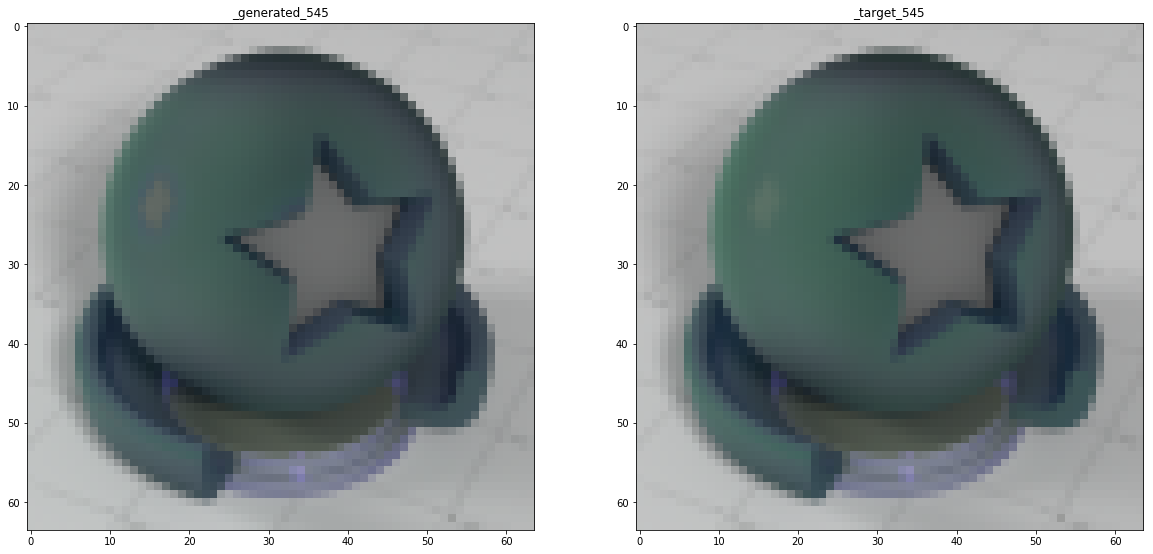

Epoch: 709, Iter: 22000, MSE_loss: 5.264


<Figure size 720x576 with 0 Axes>

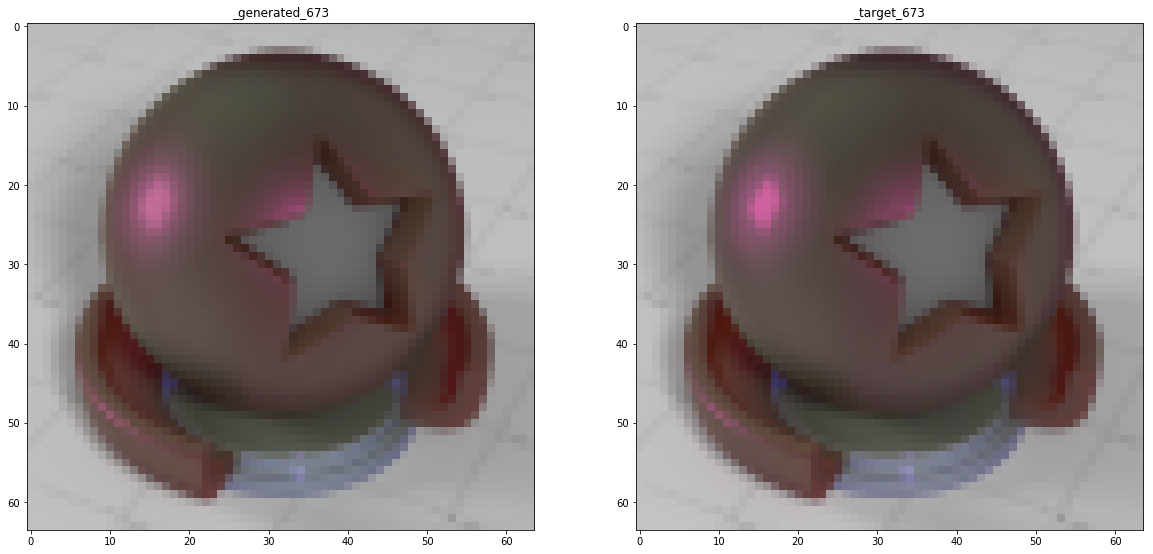

Epoch: 725, Iter: 22500, MSE_loss: 16.98


<Figure size 720x576 with 0 Axes>

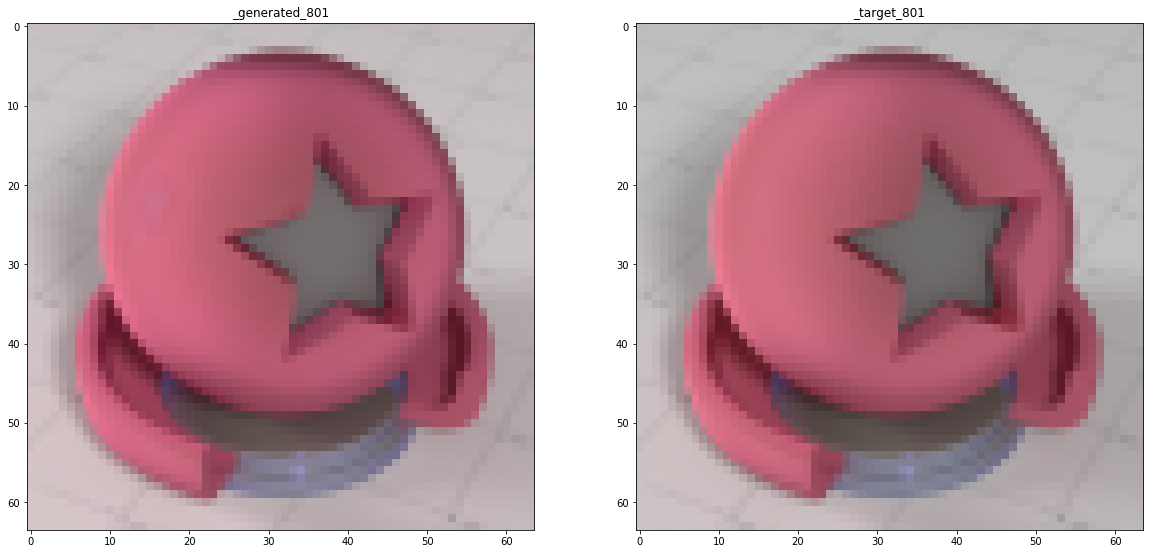

Epoch: 741, Iter: 23000, MSE_loss: 20.12


<Figure size 720x576 with 0 Axes>

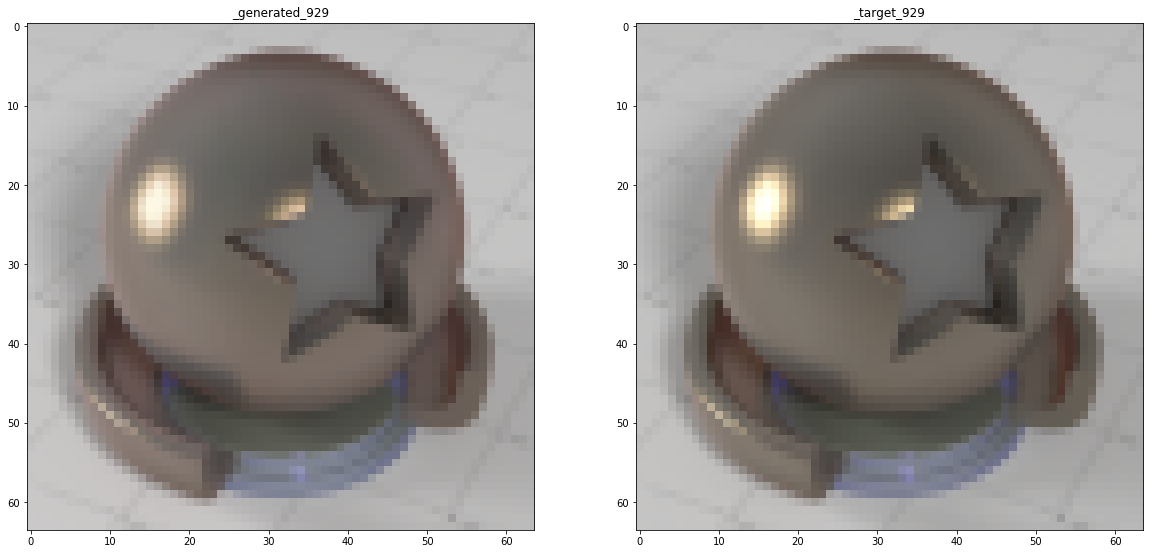

Epoch: 758, Iter: 23500, MSE_loss: 7.331


<Figure size 720x576 with 0 Axes>

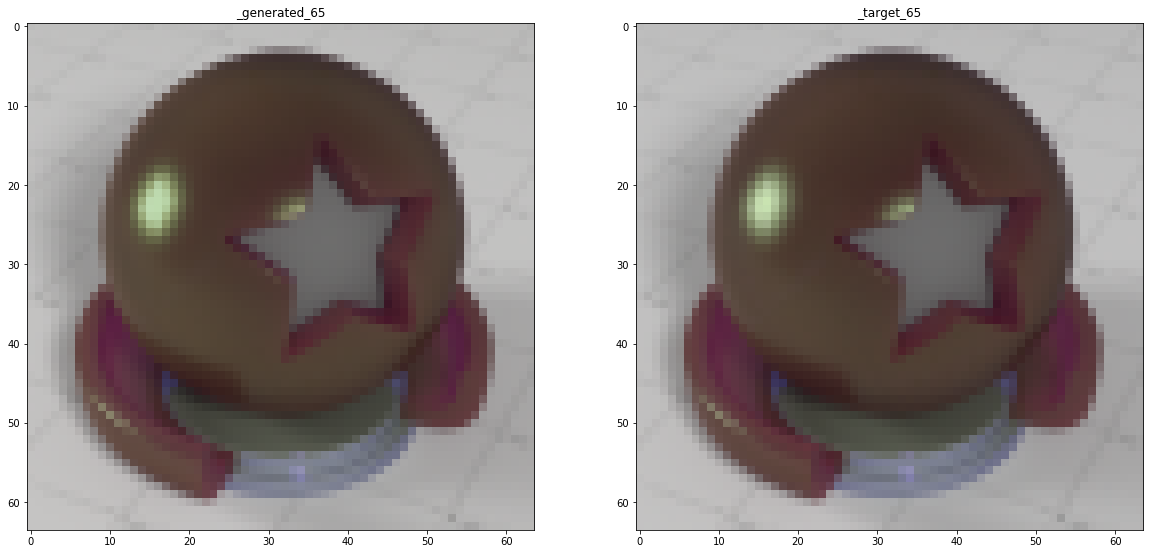

Epoch: 774, Iter: 24000, MSE_loss: 3.126


<Figure size 720x576 with 0 Axes>

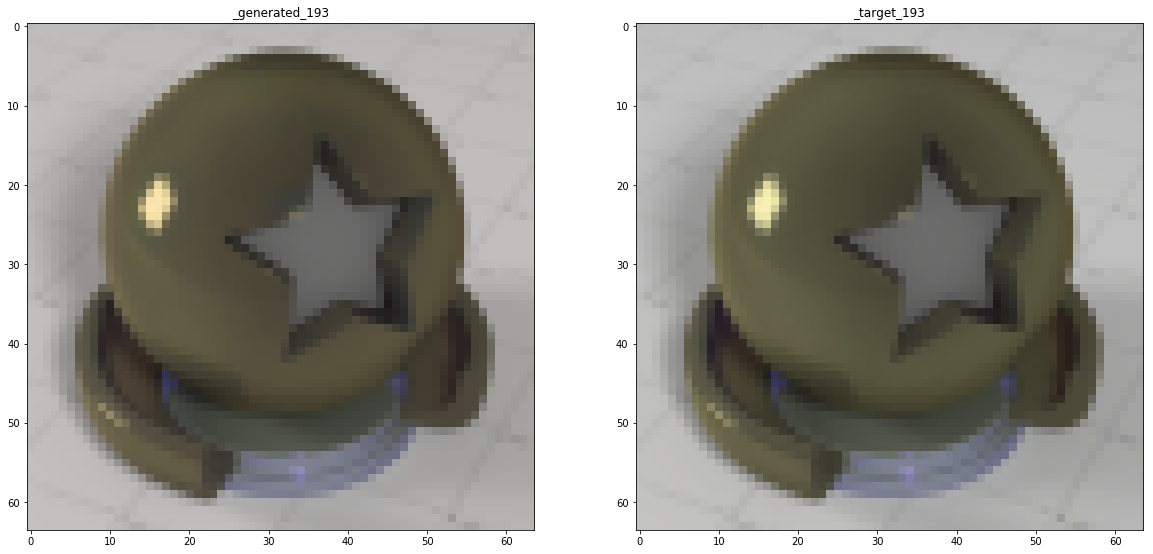

Epoch: 790, Iter: 24500, MSE_loss: 4.301


<Figure size 720x576 with 0 Axes>

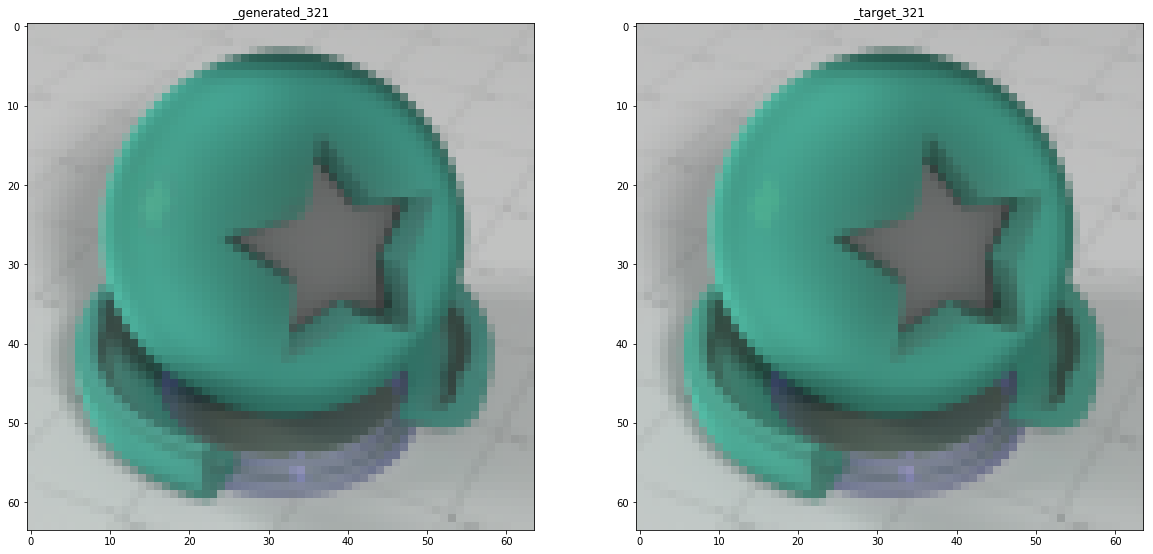

Epoch: 806, Iter: 25000, MSE_loss: 3.709


<Figure size 720x576 with 0 Axes>

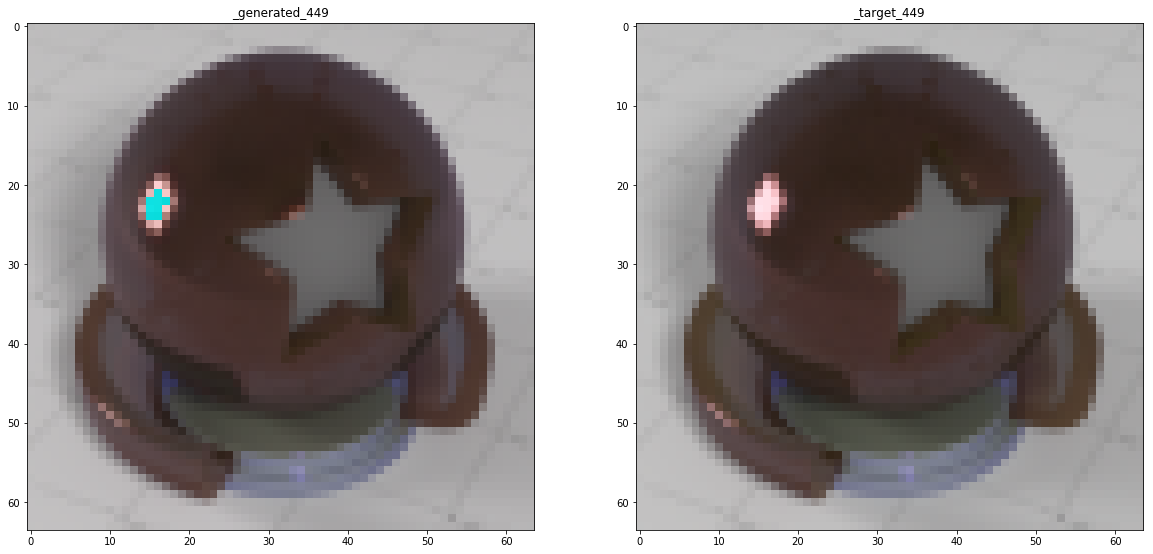

Epoch: 822, Iter: 25500, MSE_loss: 5.279


<Figure size 720x576 with 0 Axes>

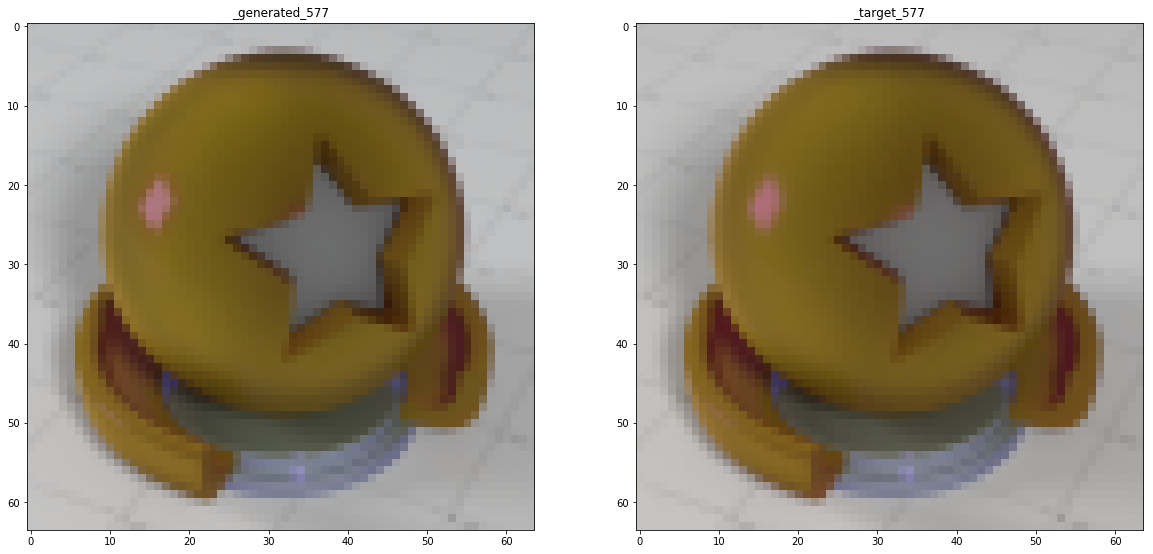

Epoch: 838, Iter: 26000, MSE_loss: 3.082


<Figure size 720x576 with 0 Axes>

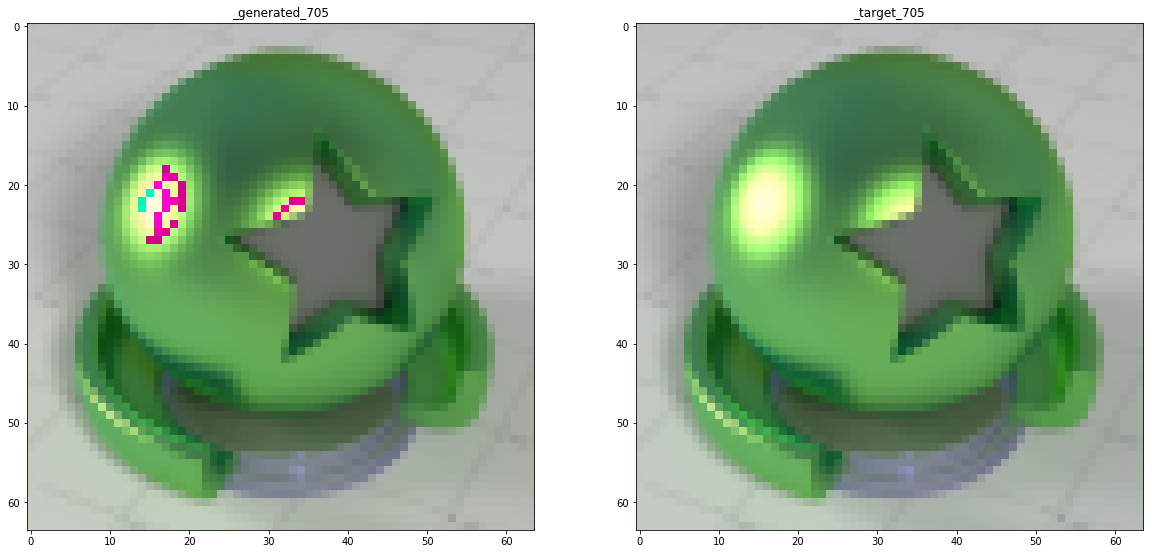

Epoch: 854, Iter: 26500, MSE_loss: 20.62


<Figure size 720x576 with 0 Axes>

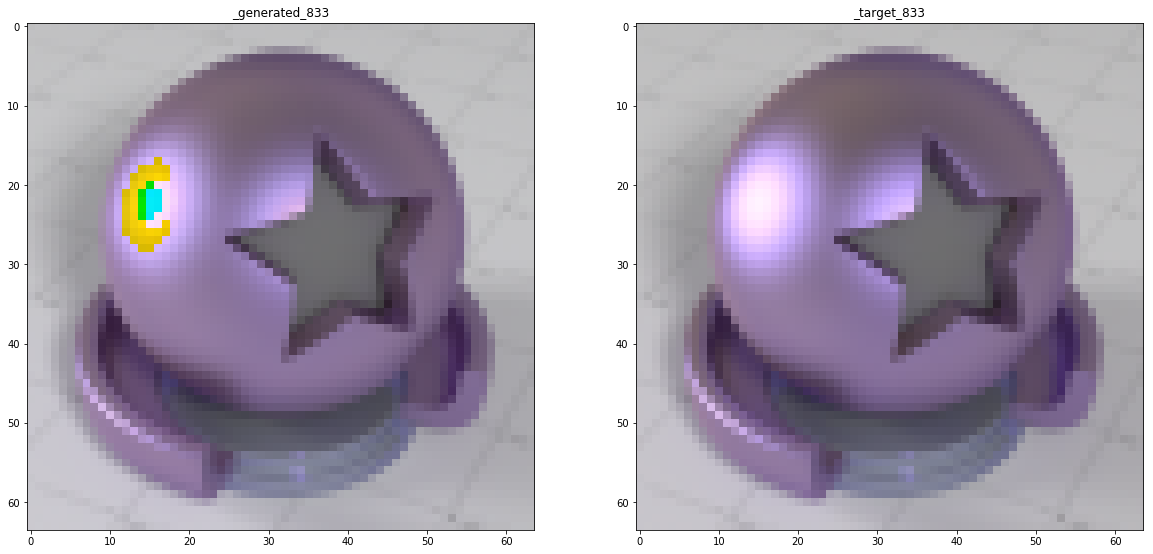

Epoch: 870, Iter: 27000, MSE_loss: 7.948


<Figure size 720x576 with 0 Axes>

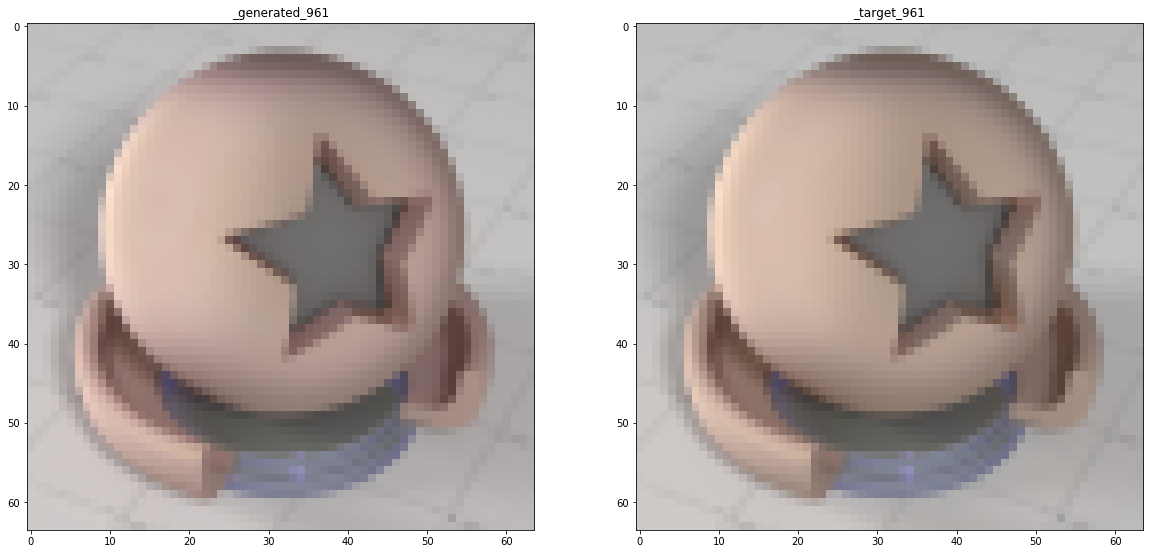

Epoch: 887, Iter: 27500, MSE_loss: 3.155


<Figure size 720x576 with 0 Axes>

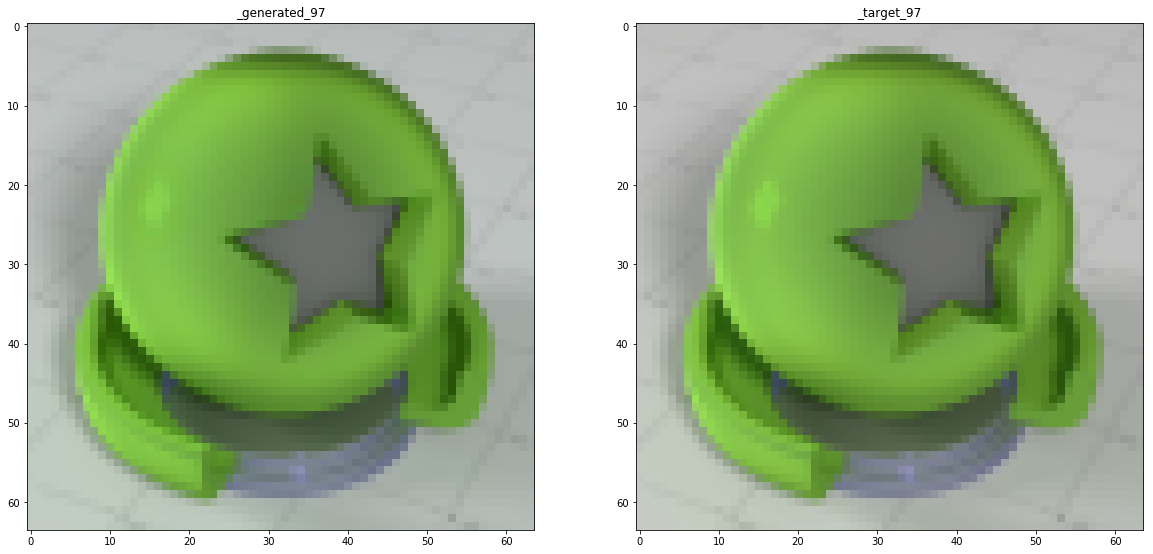

Epoch: 903, Iter: 28000, MSE_loss: 4.803


<Figure size 720x576 with 0 Axes>

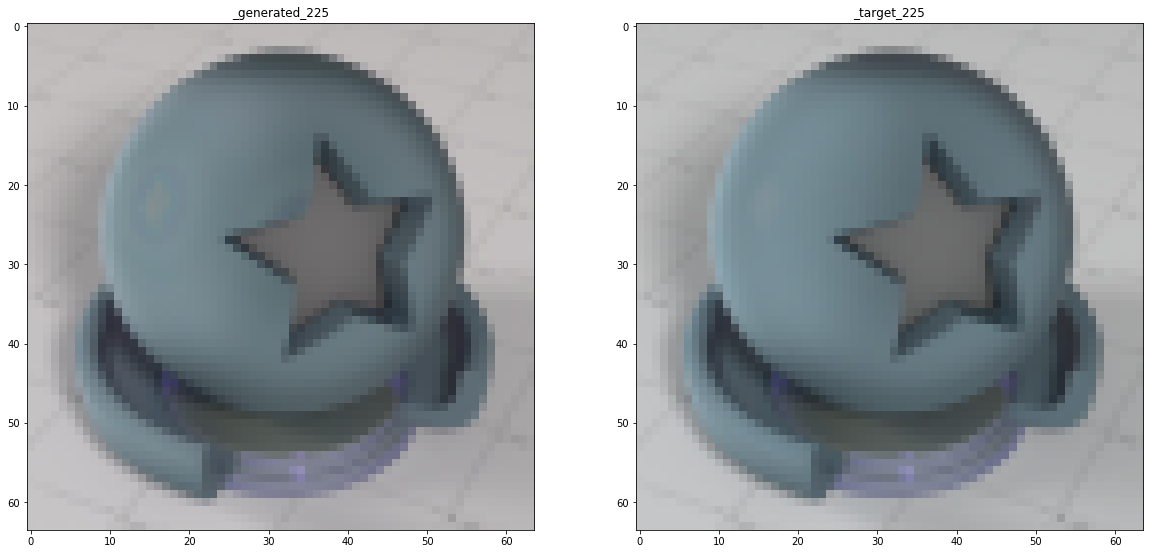

Epoch: 919, Iter: 28500, MSE_loss: 3.2


<Figure size 720x576 with 0 Axes>

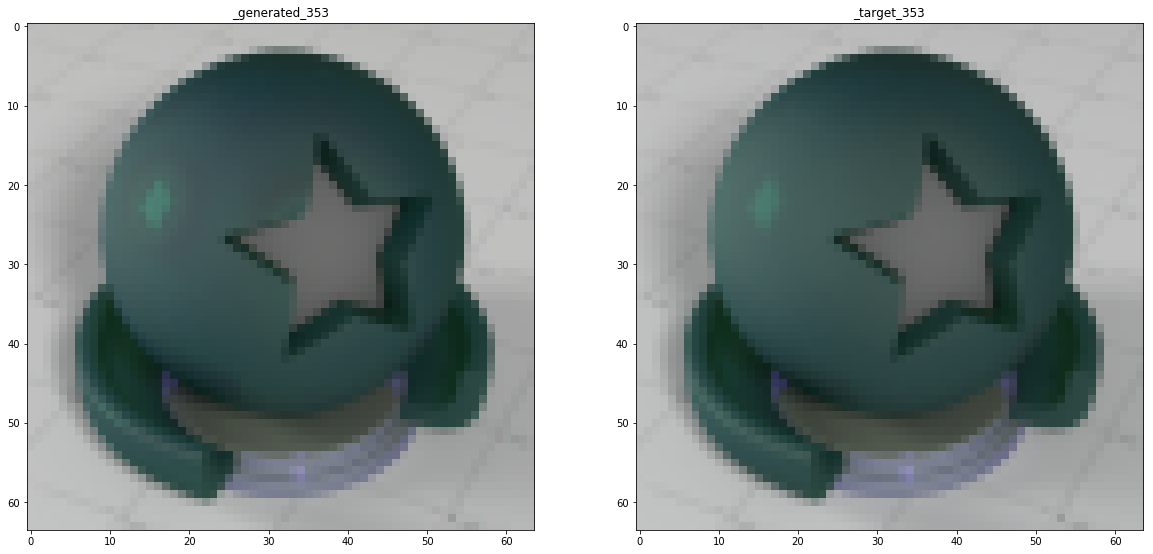

Epoch: 935, Iter: 29000, MSE_loss: 1.969


<Figure size 720x576 with 0 Axes>

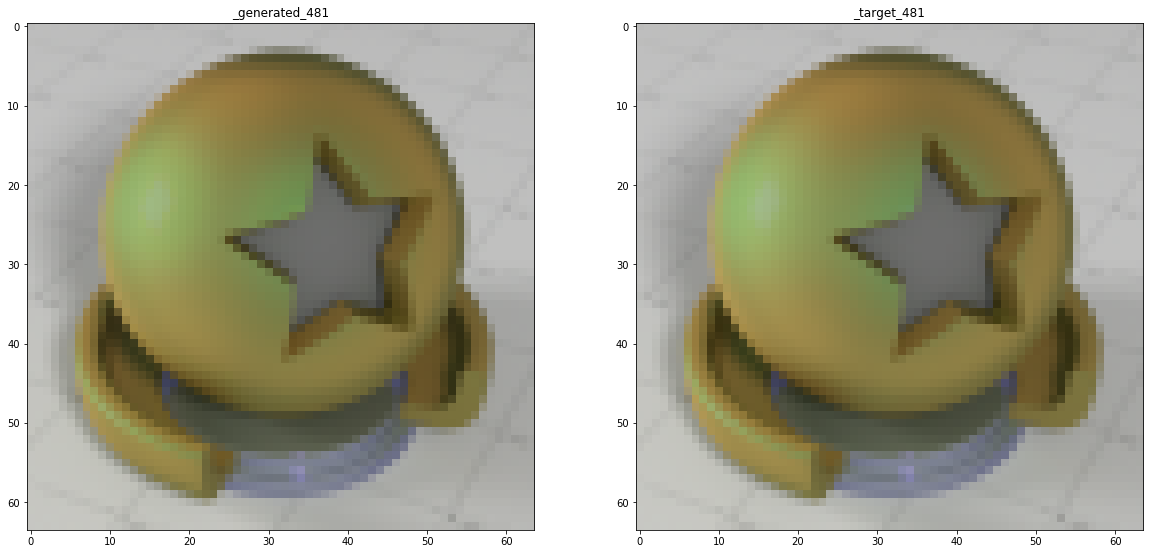

Epoch: 951, Iter: 29500, MSE_loss: 8.505


<Figure size 720x576 with 0 Axes>

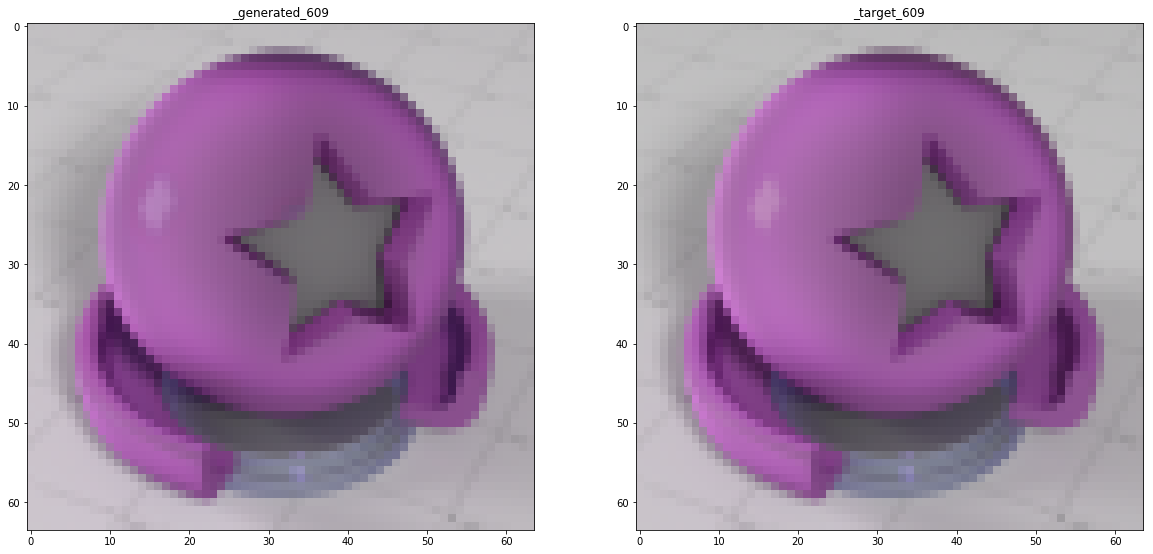

Epoch: 967, Iter: 30000, MSE_loss: 7.275


<Figure size 720x576 with 0 Axes>

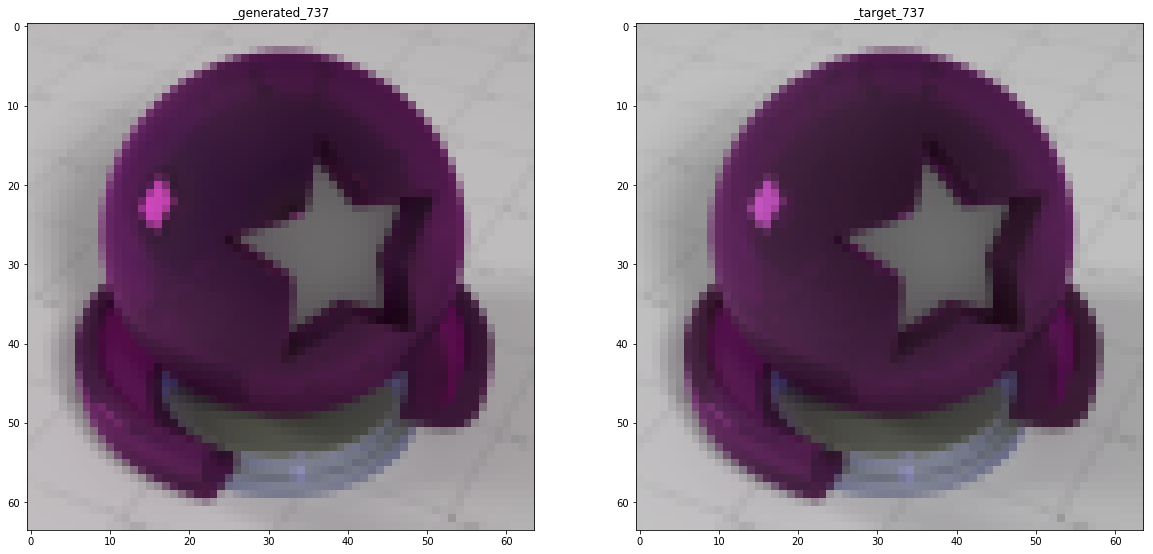

Epoch: 983, Iter: 30500, MSE_loss: 4.025


<Figure size 720x576 with 0 Axes>

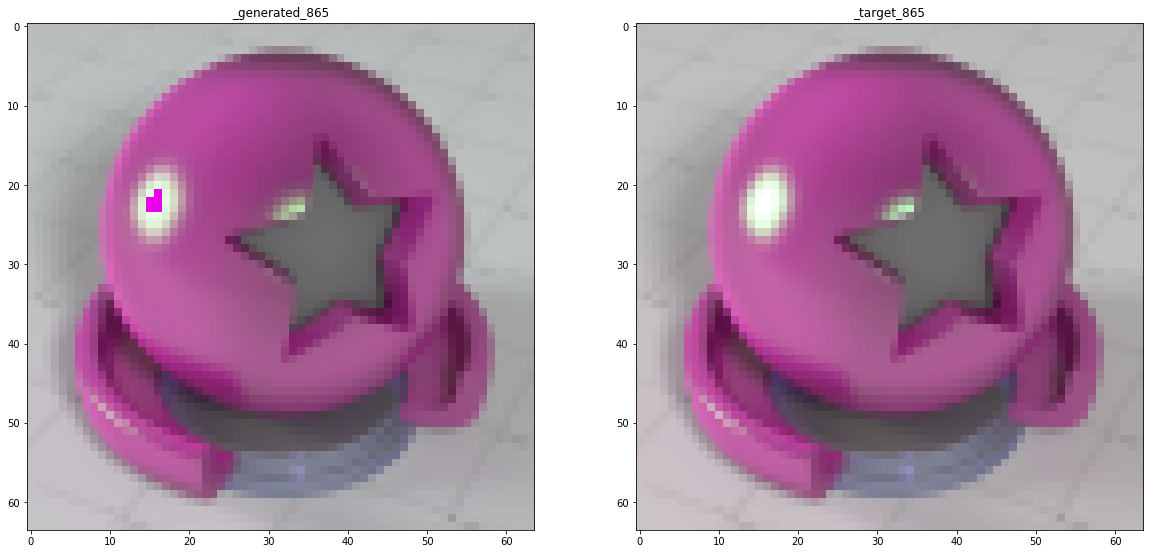

Epoch: 1000, Iter: 31000, MSE_loss: 5.747


<Figure size 720x576 with 0 Axes>

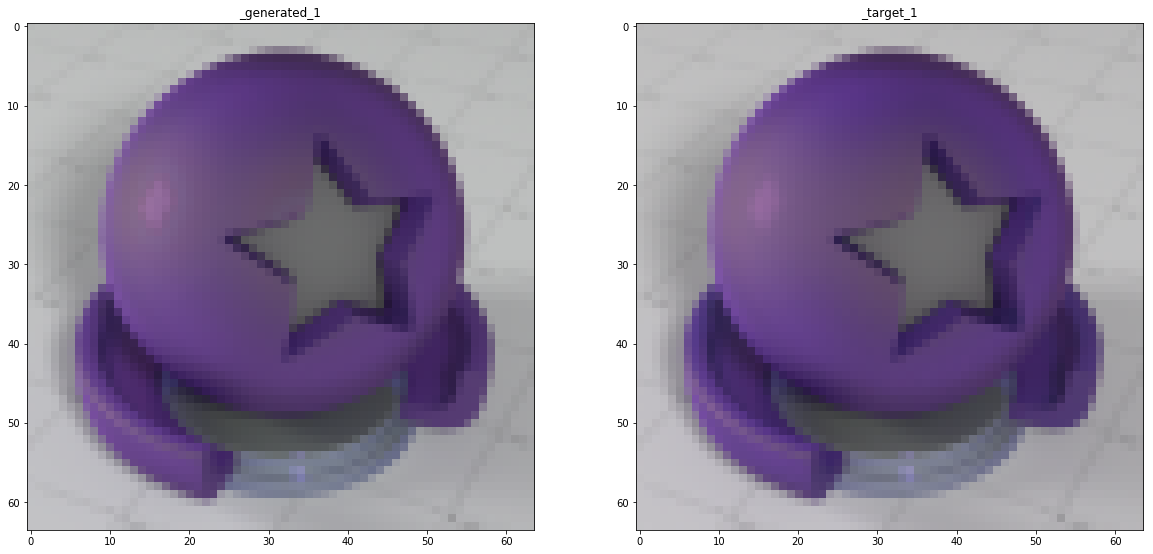

Epoch: 1016, Iter: 31500, MSE_loss: 2.216


<Figure size 720x576 with 0 Axes>

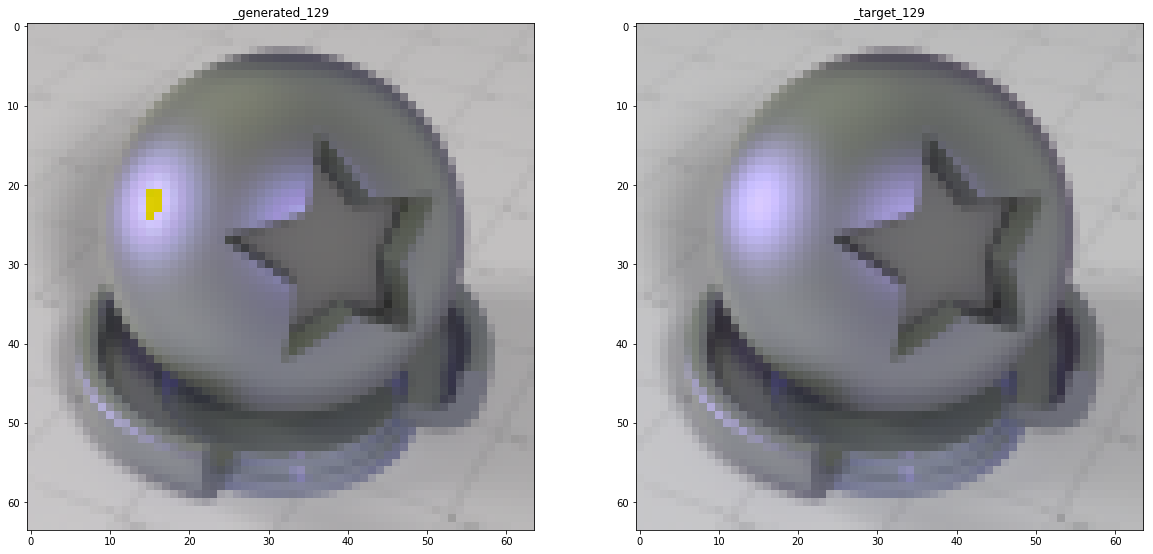

Epoch: 1032, Iter: 32000, MSE_loss: 4.705


<Figure size 720x576 with 0 Axes>

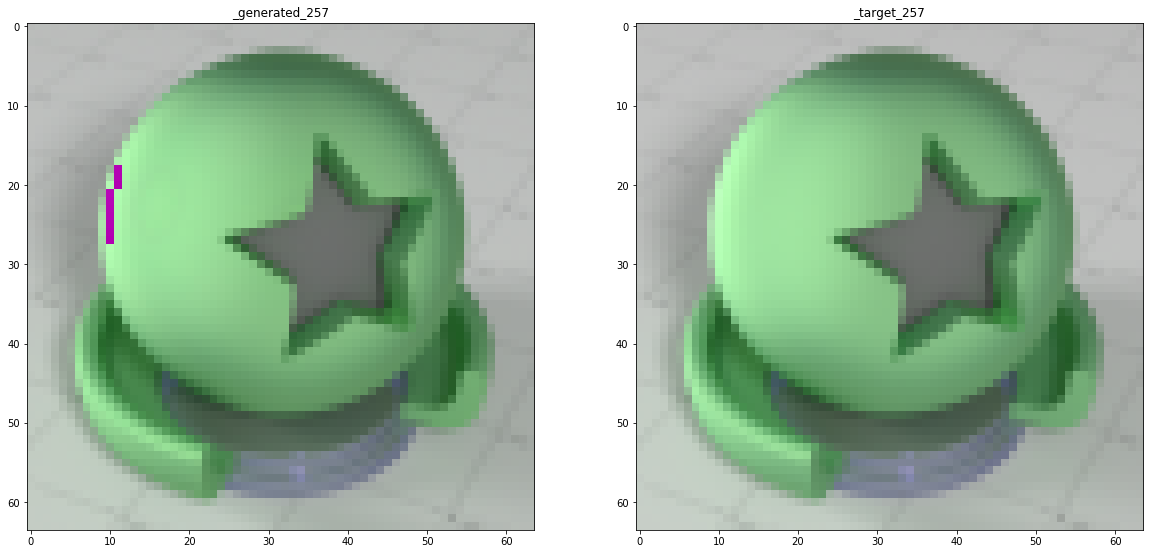

Epoch: 1048, Iter: 32500, MSE_loss: 6.331


<Figure size 720x576 with 0 Axes>

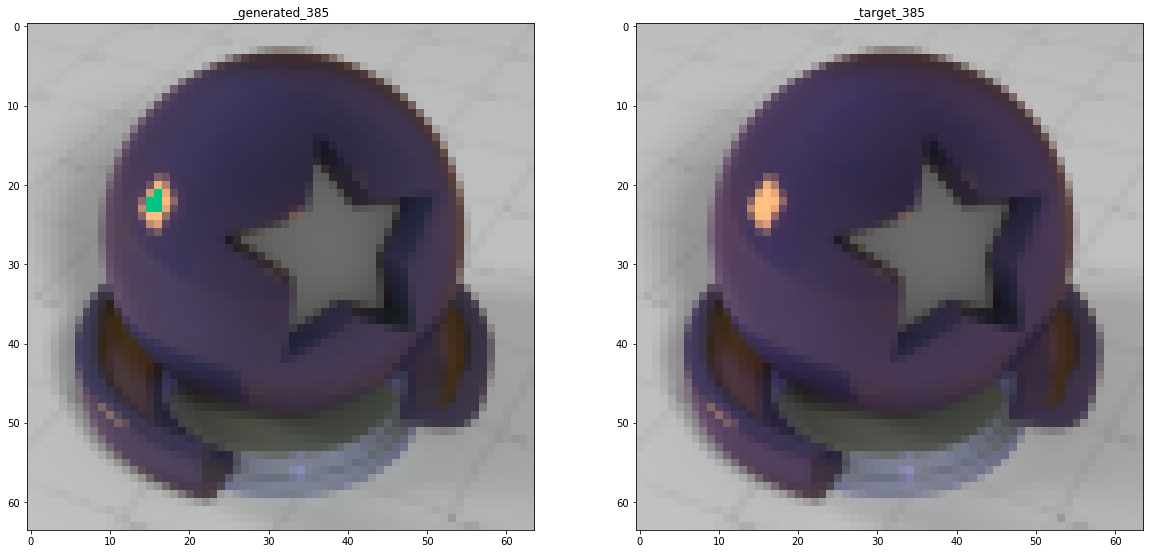

Epoch: 1064, Iter: 33000, MSE_loss: 2.774


<Figure size 720x576 with 0 Axes>

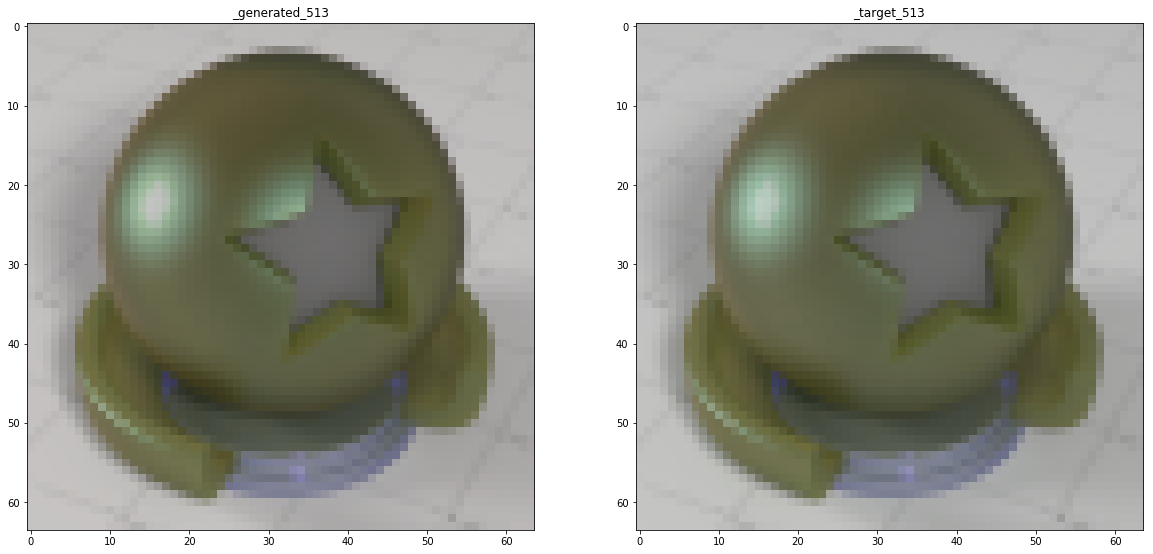

Epoch: 1080, Iter: 33500, MSE_loss: 13.11


<Figure size 720x576 with 0 Axes>

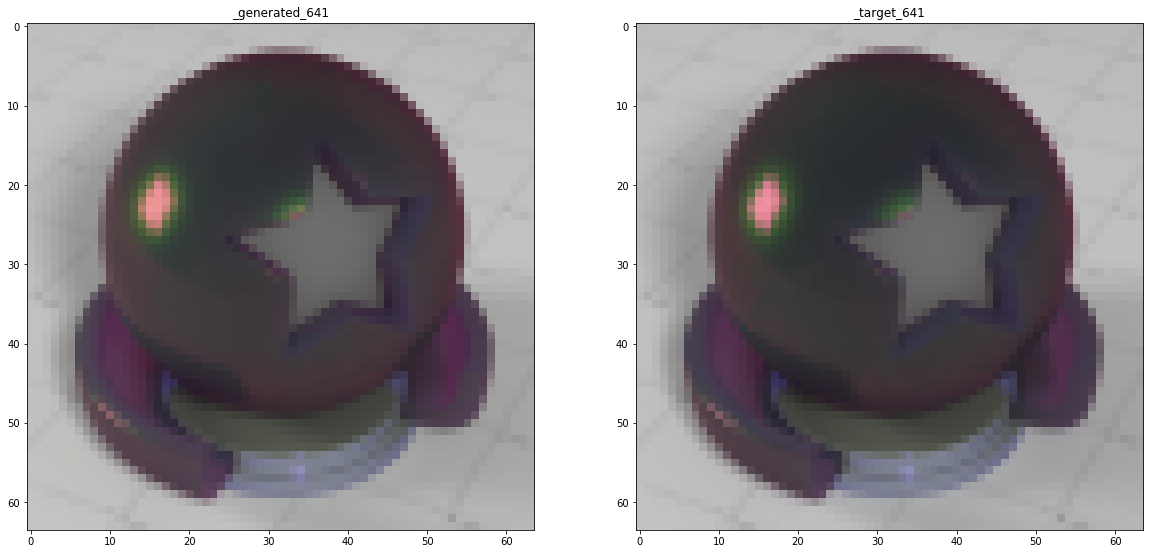

Epoch: 1096, Iter: 34000, MSE_loss: 4.436


<Figure size 720x576 with 0 Axes>

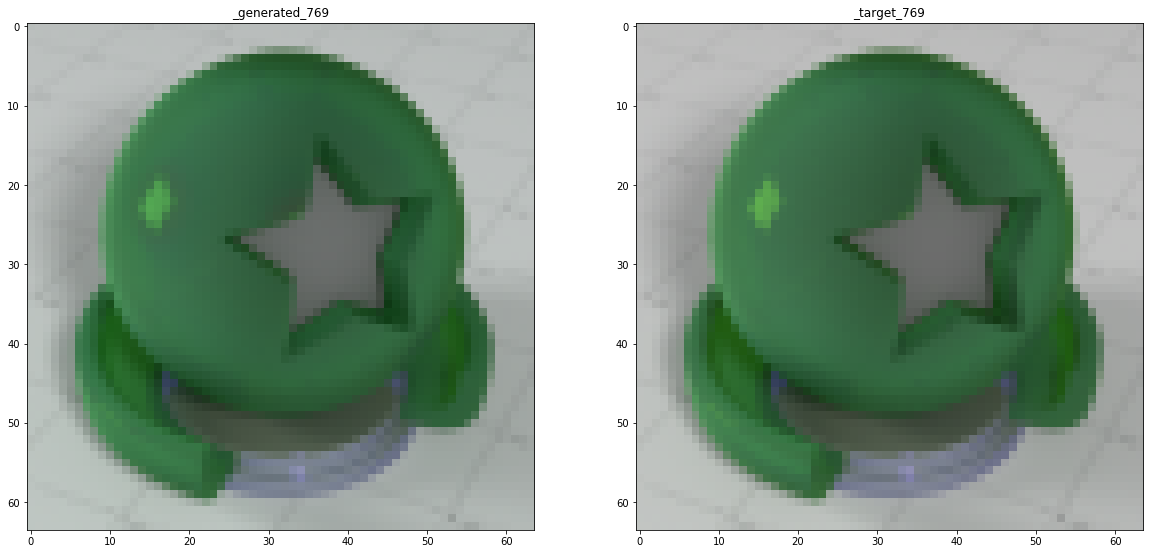

Epoch: 1112, Iter: 34500, MSE_loss: 2.181


<Figure size 720x576 with 0 Axes>

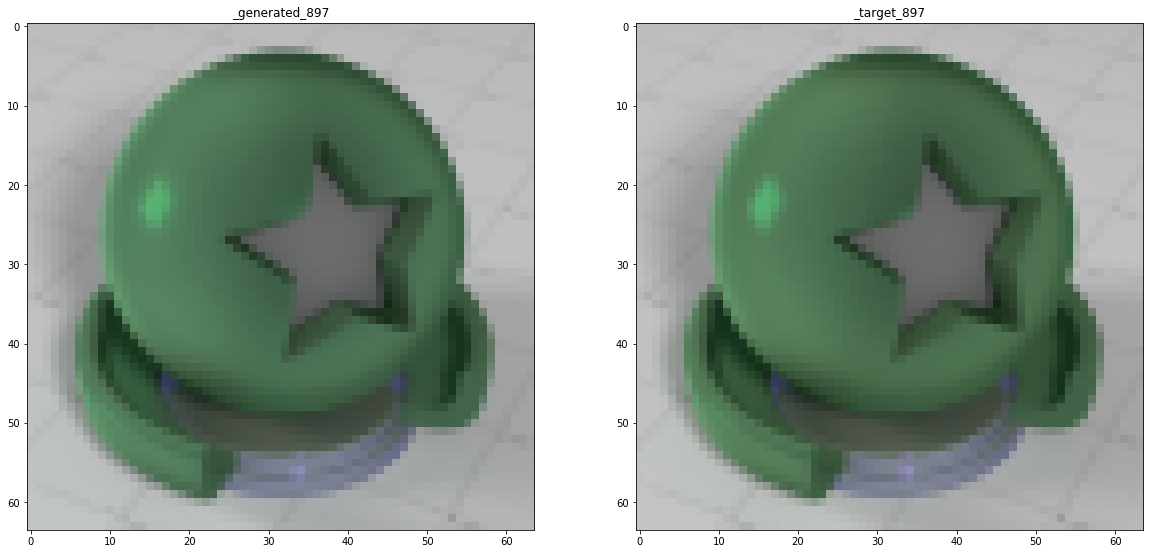

Epoch: 1129, Iter: 35000, MSE_loss: 7.126


<Figure size 720x576 with 0 Axes>

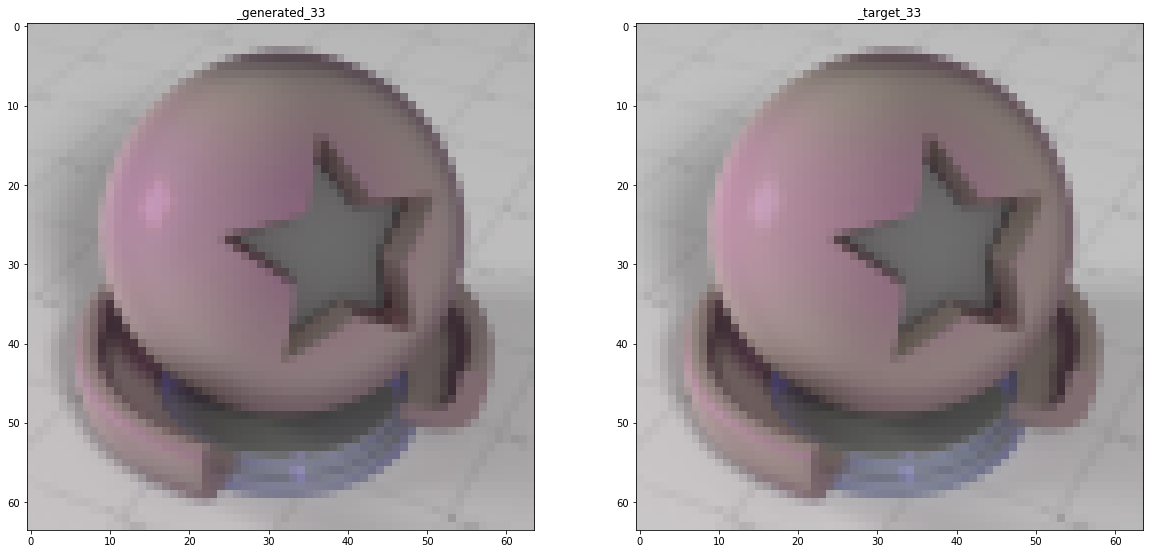

Epoch: 1145, Iter: 35500, MSE_loss: 3.65


<Figure size 720x576 with 0 Axes>

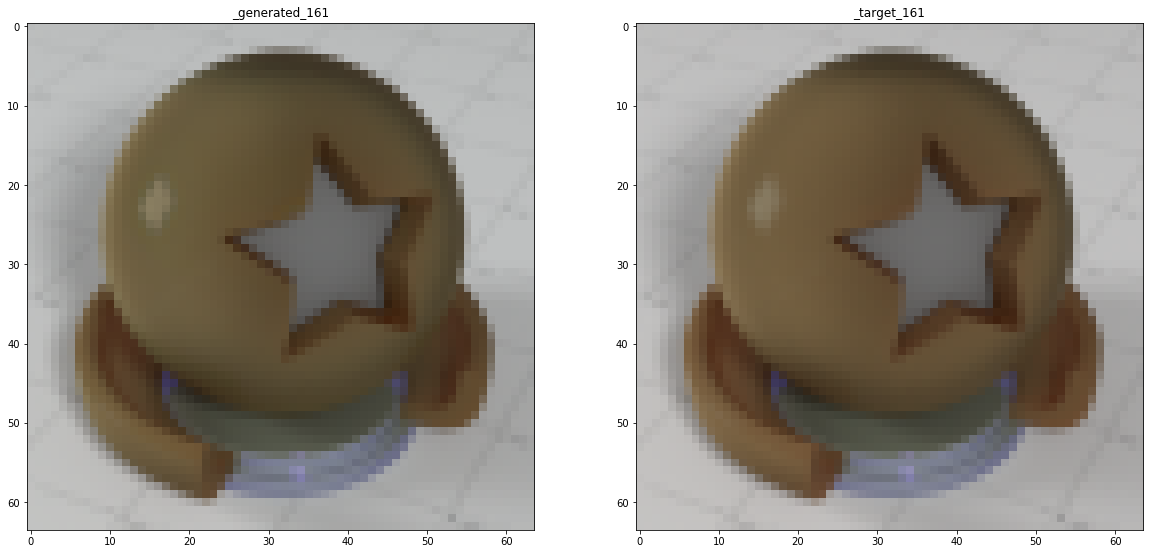

Epoch: 1161, Iter: 36000, MSE_loss: 9.15


<Figure size 720x576 with 0 Axes>

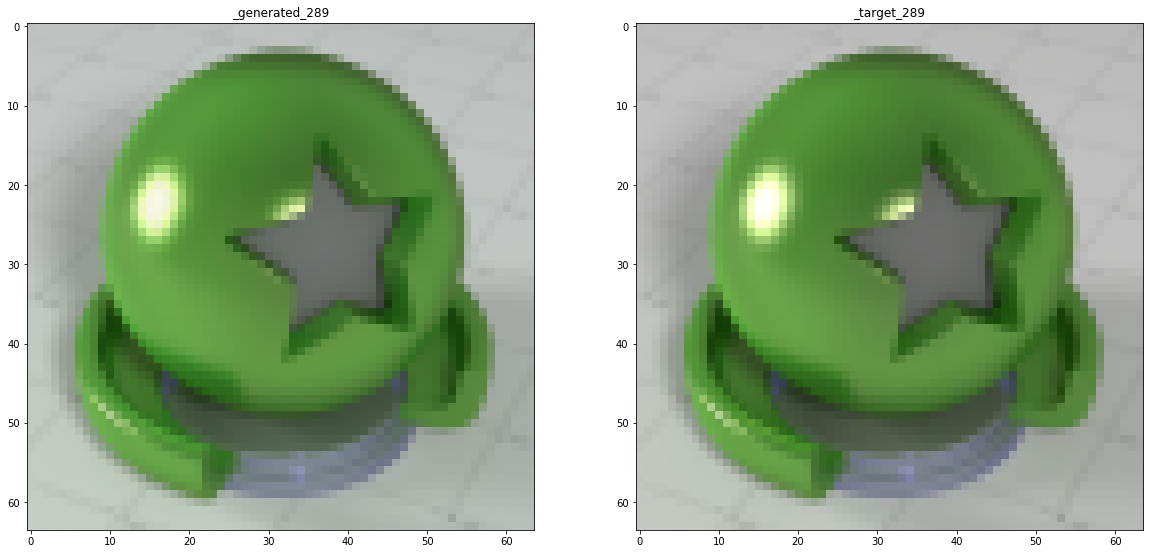

Epoch: 1177, Iter: 36500, MSE_loss: 4.351


<Figure size 720x576 with 0 Axes>

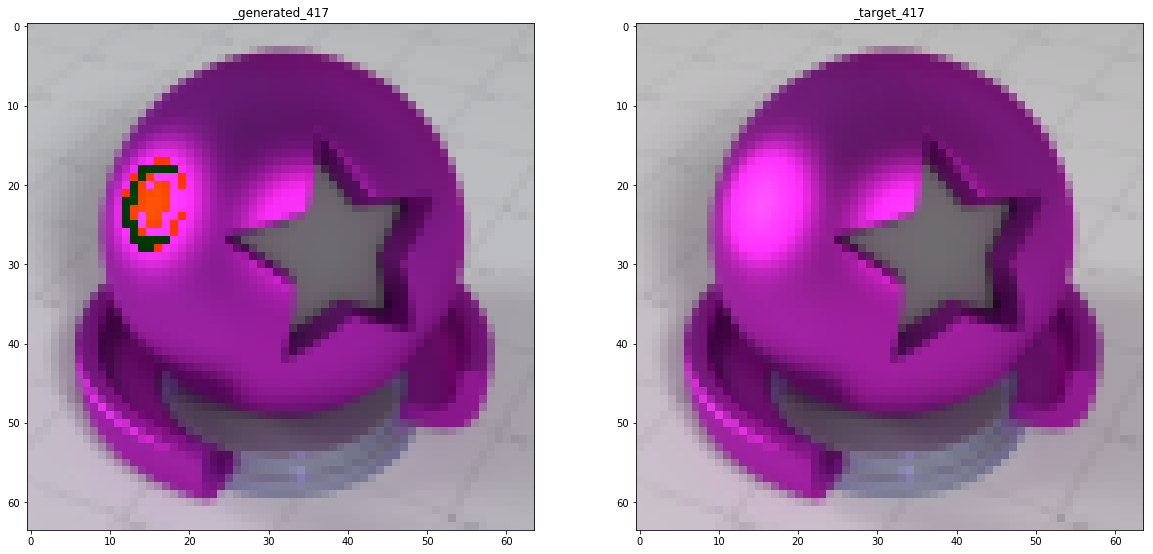

Epoch: 1193, Iter: 37000, MSE_loss: 2.375


<Figure size 720x576 with 0 Axes>

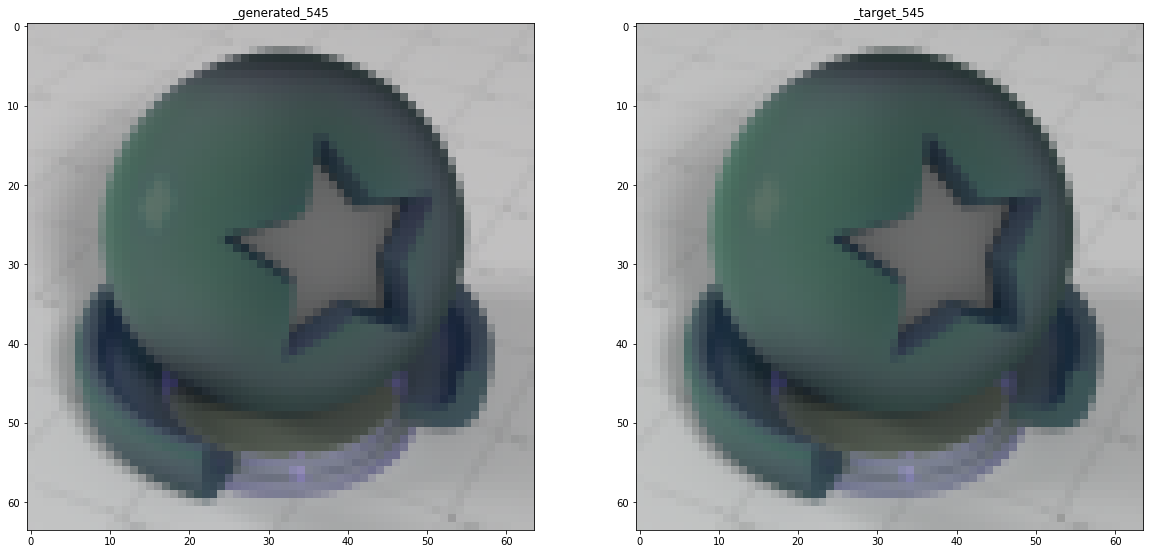

Epoch: 1209, Iter: 37500, MSE_loss: 3.122


<Figure size 720x576 with 0 Axes>

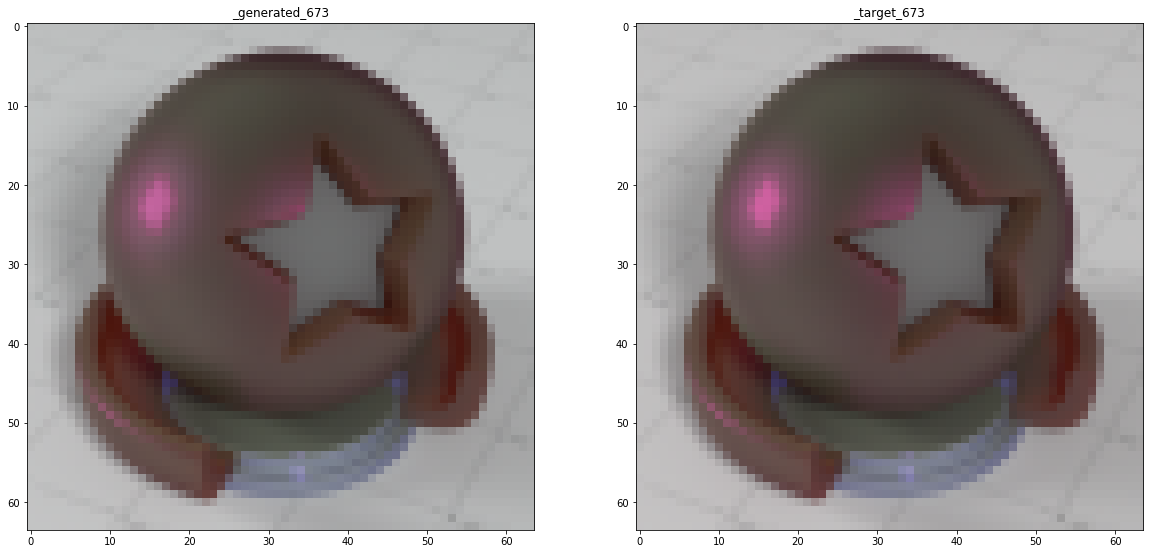

Epoch: 1225, Iter: 38000, MSE_loss: 3.165


<Figure size 720x576 with 0 Axes>

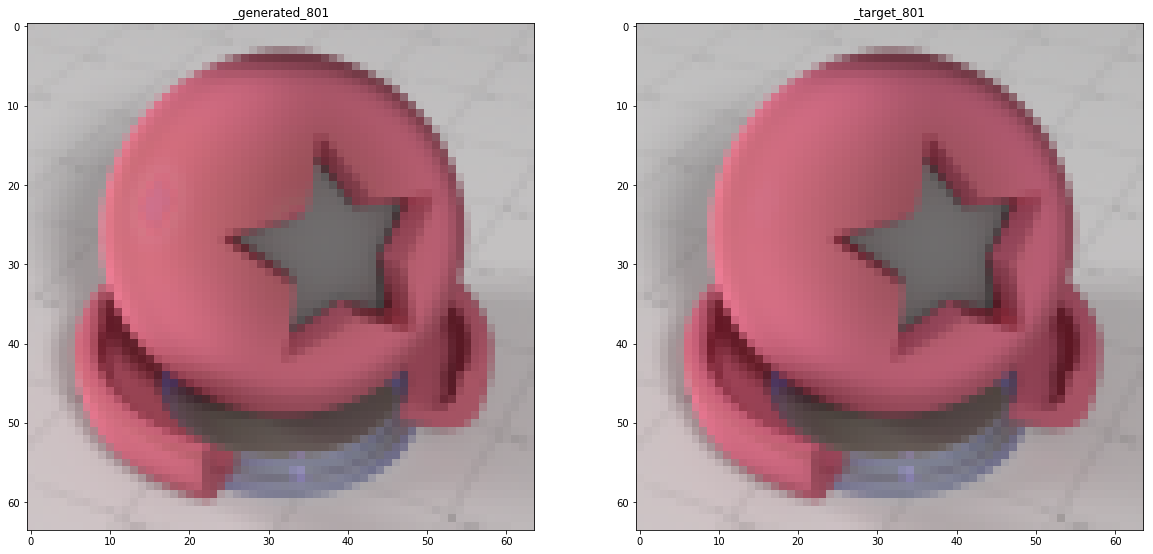

Epoch: 1241, Iter: 38500, MSE_loss: 5.18


<Figure size 720x576 with 0 Axes>

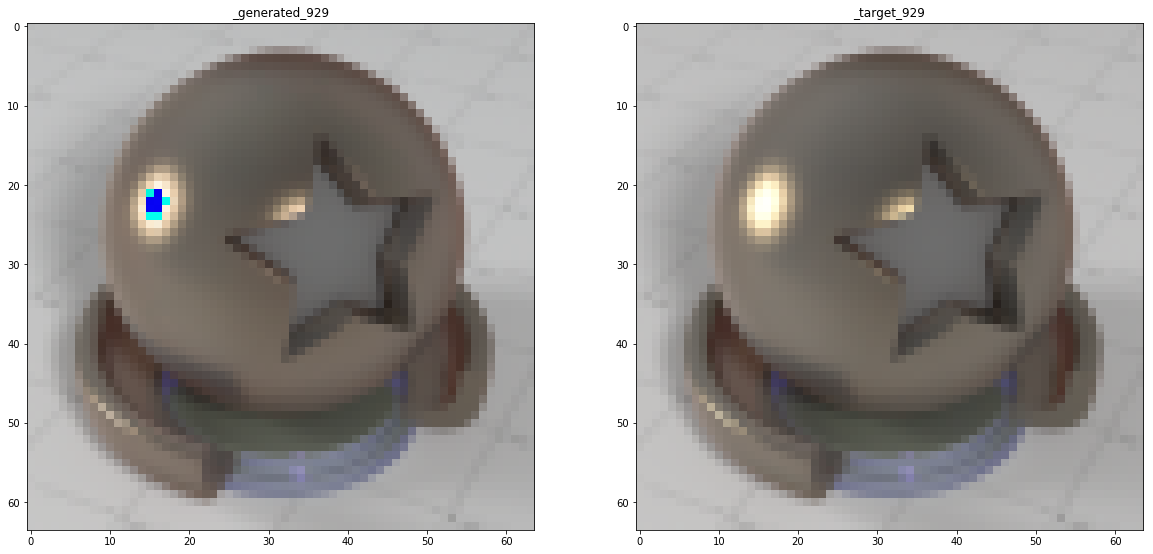

Epoch: 1258, Iter: 39000, MSE_loss: 5.264


<Figure size 720x576 with 0 Axes>

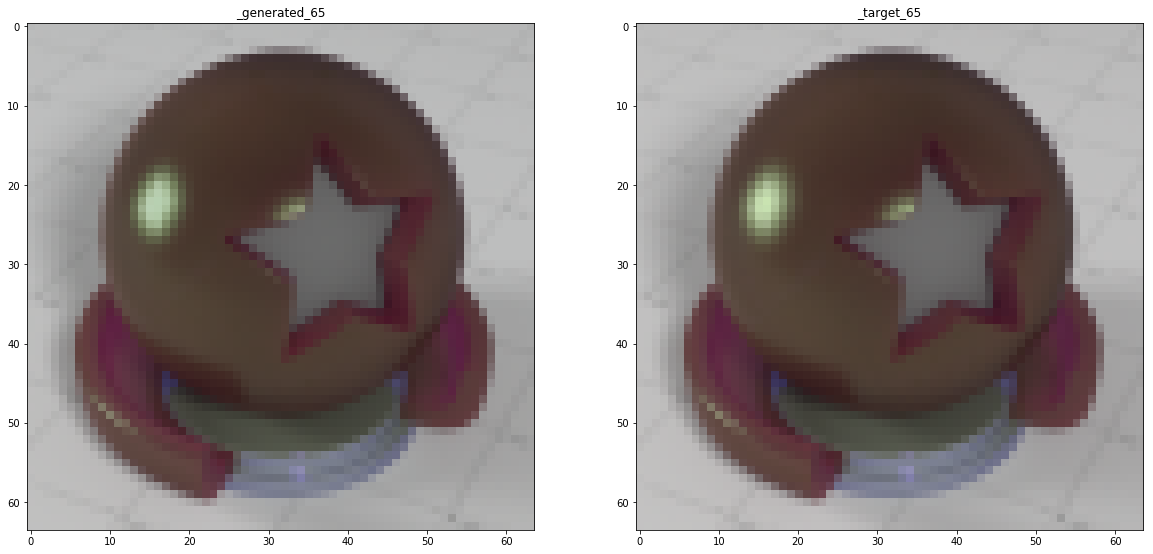

Epoch: 1274, Iter: 39500, MSE_loss: 3.577


<Figure size 720x576 with 0 Axes>

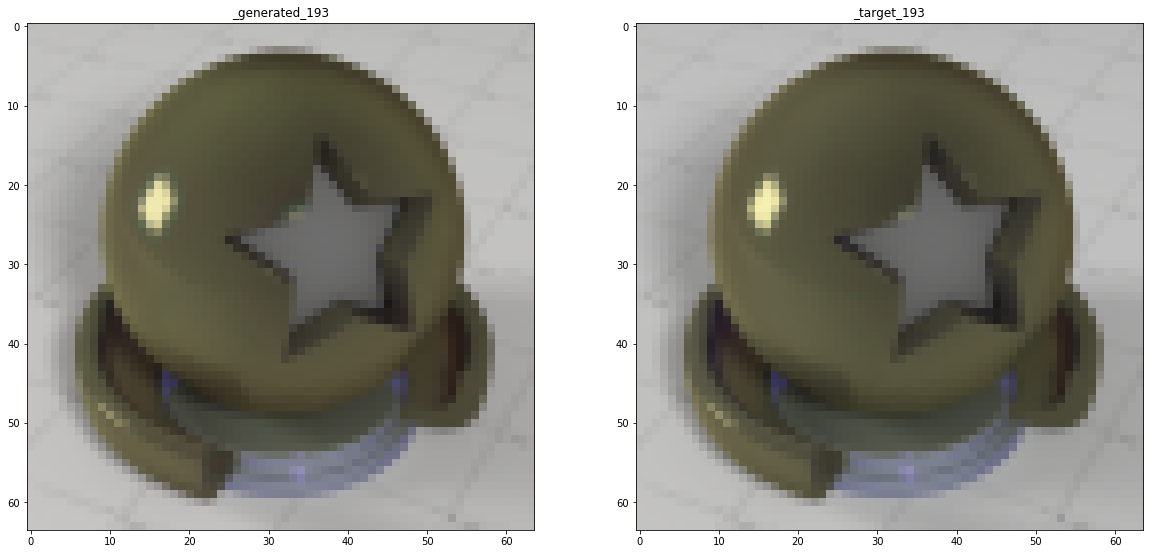

Epoch: 1290, Iter: 40000, MSE_loss: 10.57


<Figure size 720x576 with 0 Axes>

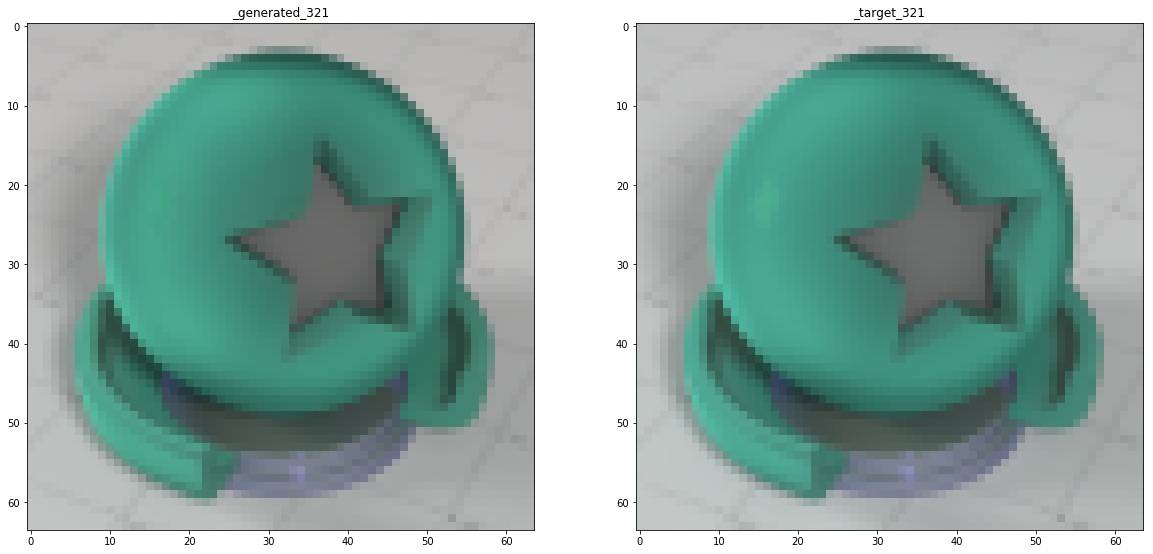

Epoch: 1306, Iter: 40500, MSE_loss: 7.78


<Figure size 720x576 with 0 Axes>

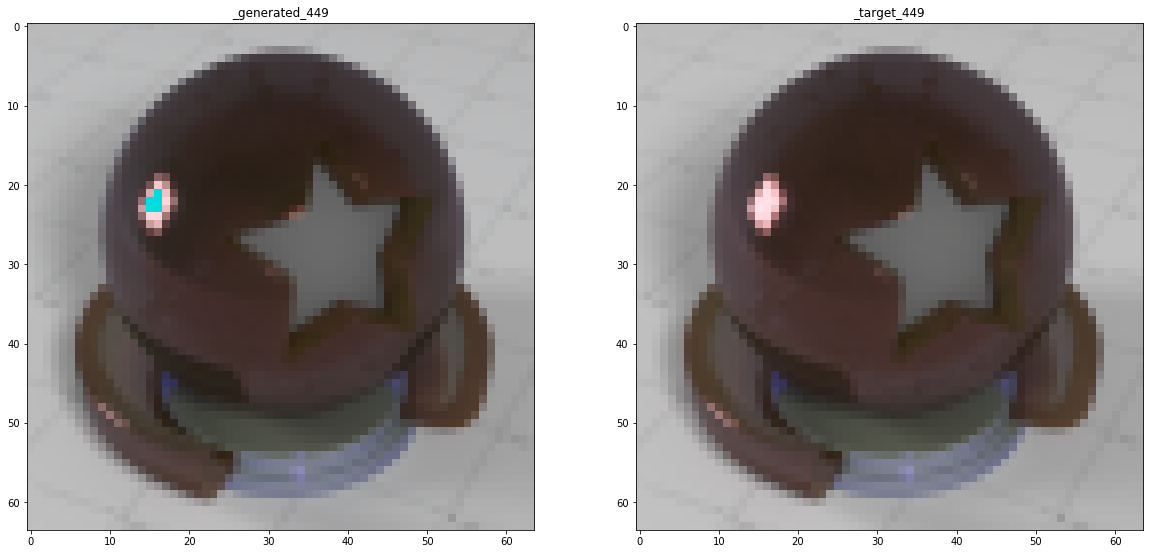

Epoch: 1322, Iter: 41000, MSE_loss: 4.126


<Figure size 720x576 with 0 Axes>

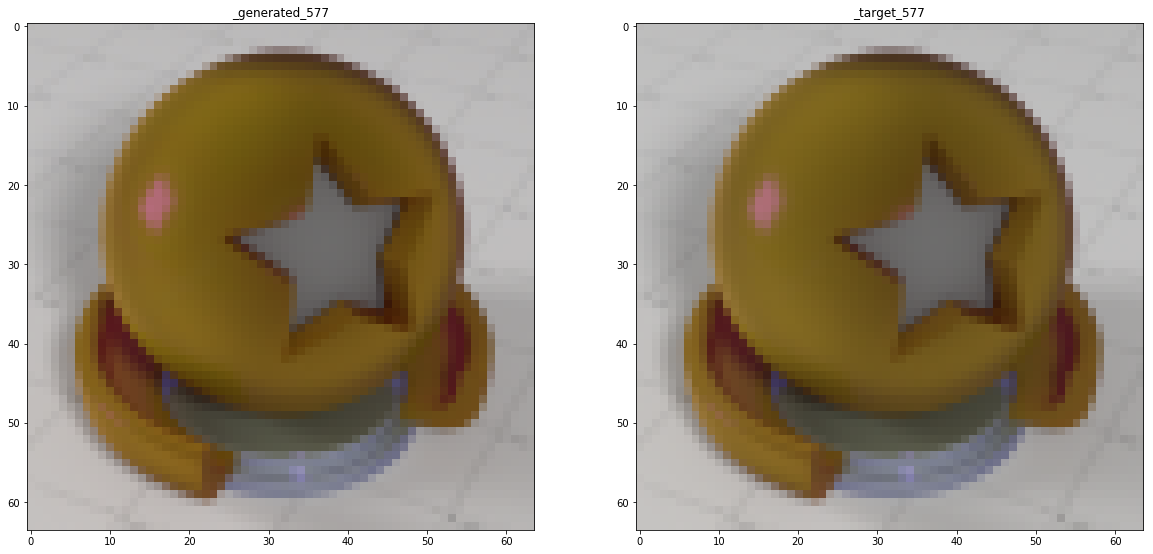

Epoch: 1338, Iter: 41500, MSE_loss: 2.281


<Figure size 720x576 with 0 Axes>

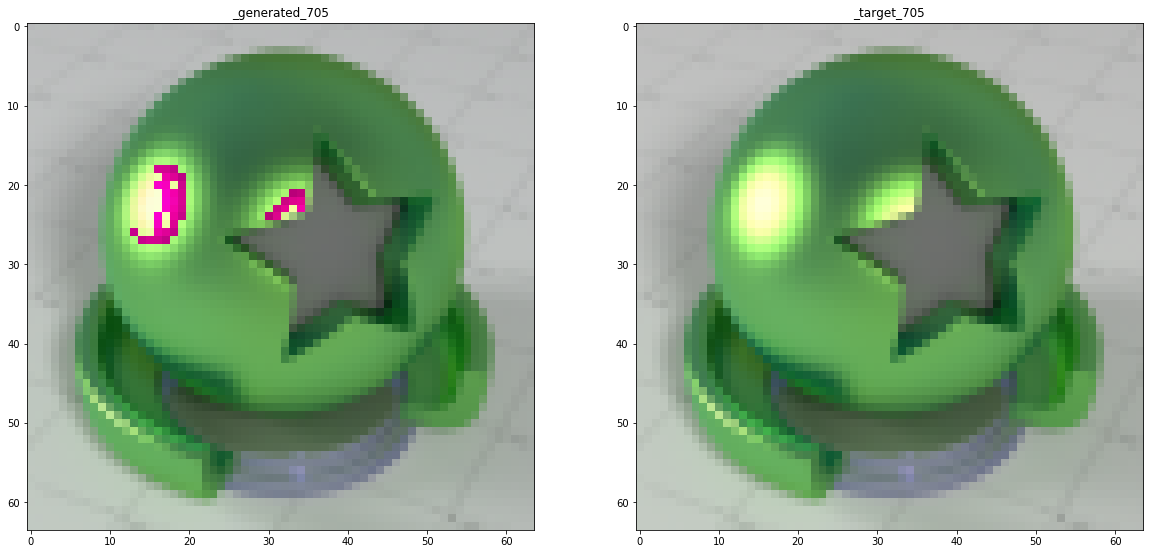

Epoch: 1354, Iter: 42000, MSE_loss: 1.939


<Figure size 720x576 with 0 Axes>

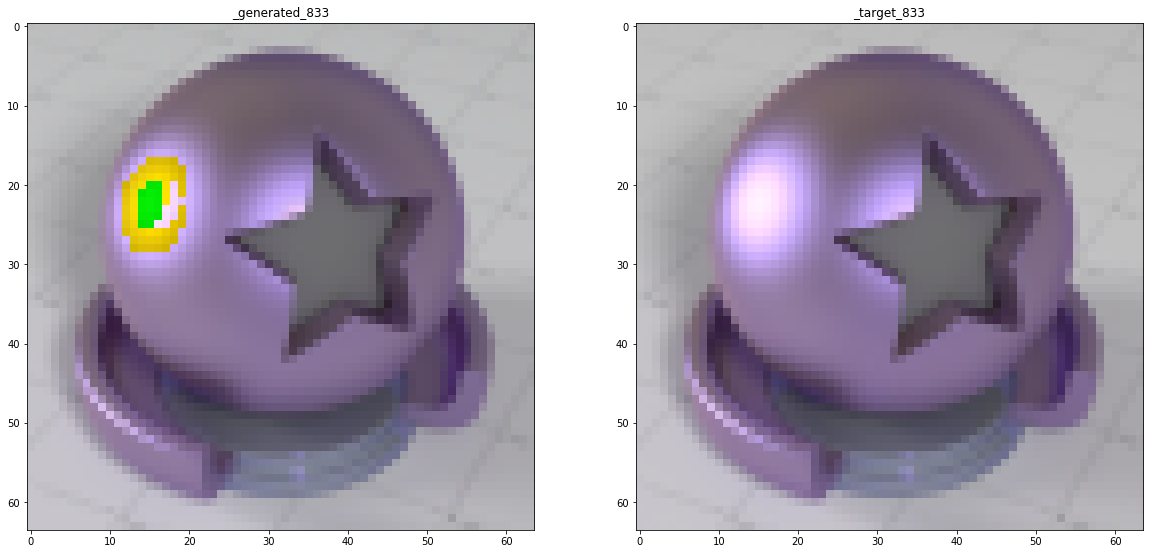

Epoch: 1370, Iter: 42500, MSE_loss: 5.88


<Figure size 720x576 with 0 Axes>

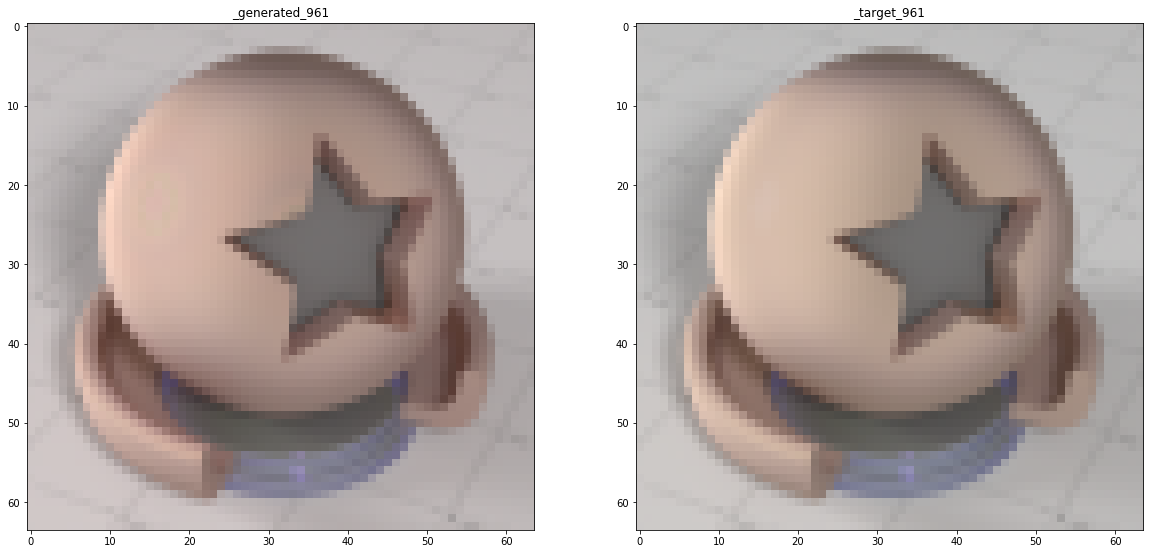

Epoch: 1387, Iter: 43000, MSE_loss: 2.881


<Figure size 720x576 with 0 Axes>

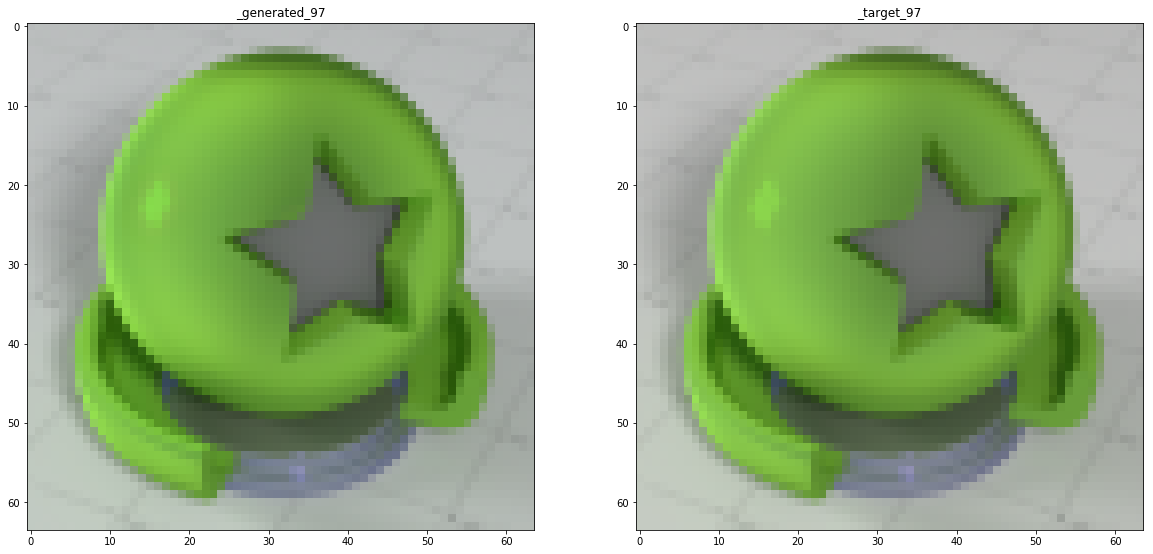

Epoch: 1403, Iter: 43500, MSE_loss: 2.005


<Figure size 720x576 with 0 Axes>

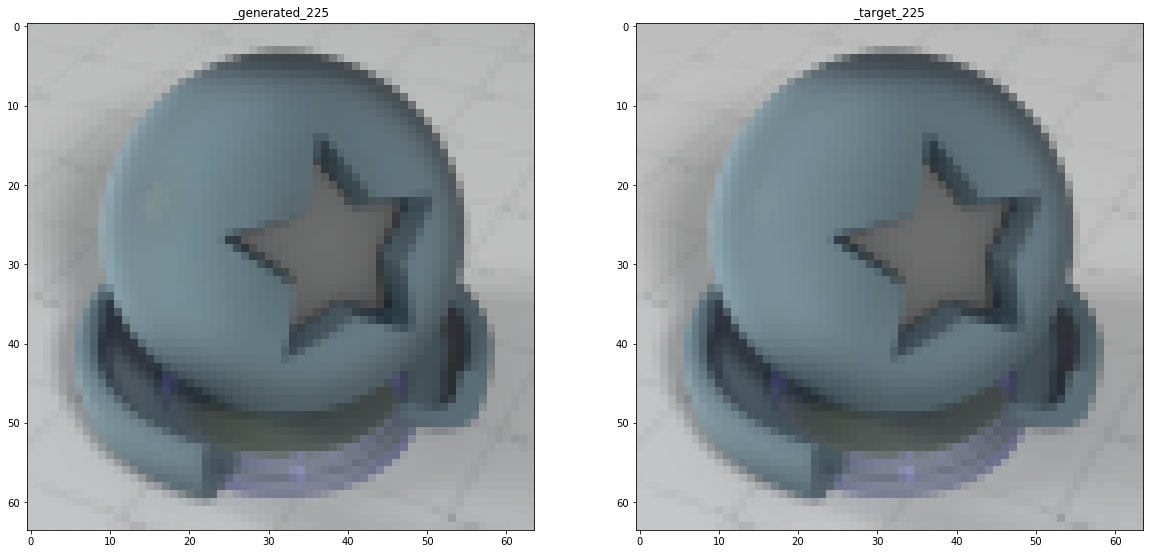

Epoch: 1419, Iter: 44000, MSE_loss: 4.158


<Figure size 720x576 with 0 Axes>

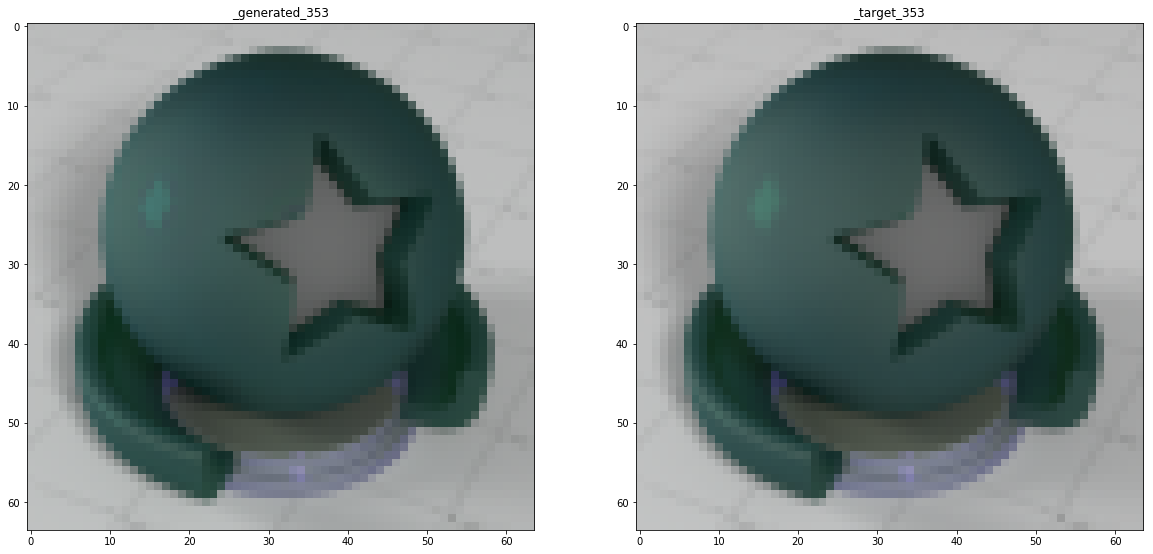

Epoch: 1435, Iter: 44500, MSE_loss: 8.645


<Figure size 720x576 with 0 Axes>

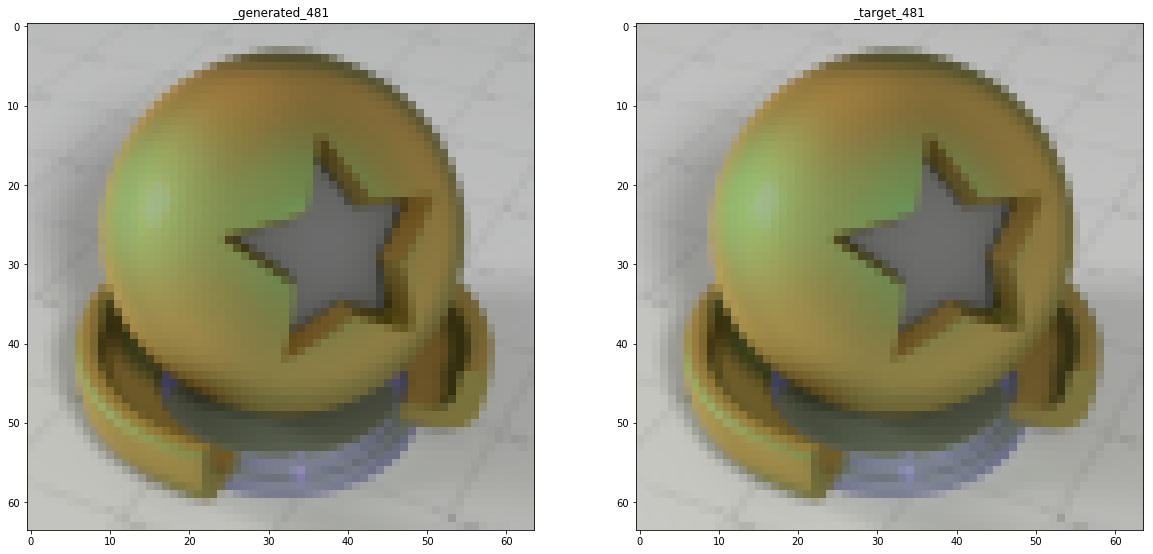

Epoch: 1451, Iter: 45000, MSE_loss: 2.036


<Figure size 720x576 with 0 Axes>

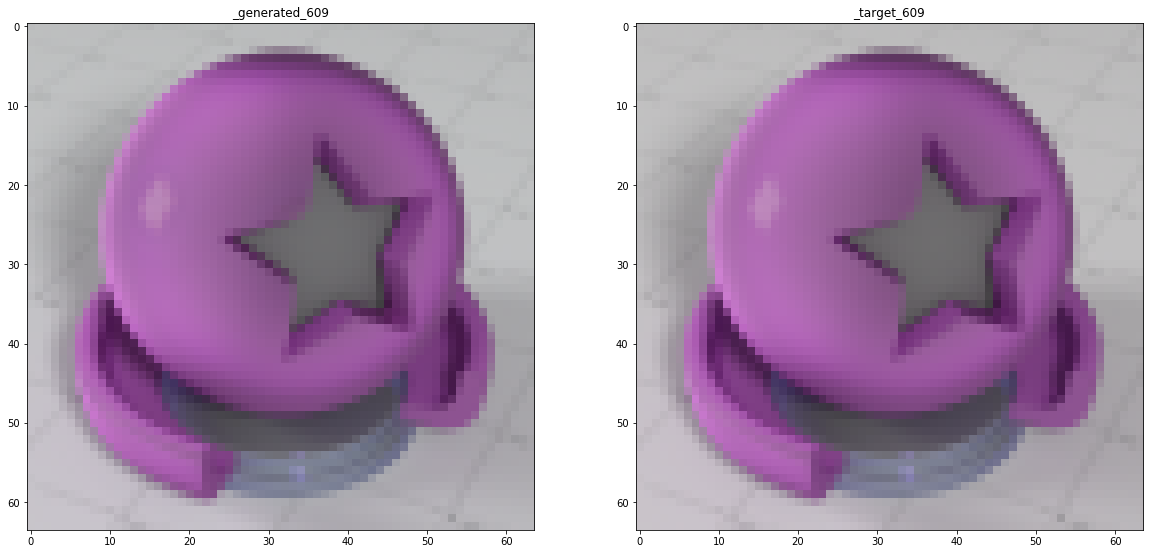

Epoch: 1467, Iter: 45500, MSE_loss: 7.822


<Figure size 720x576 with 0 Axes>

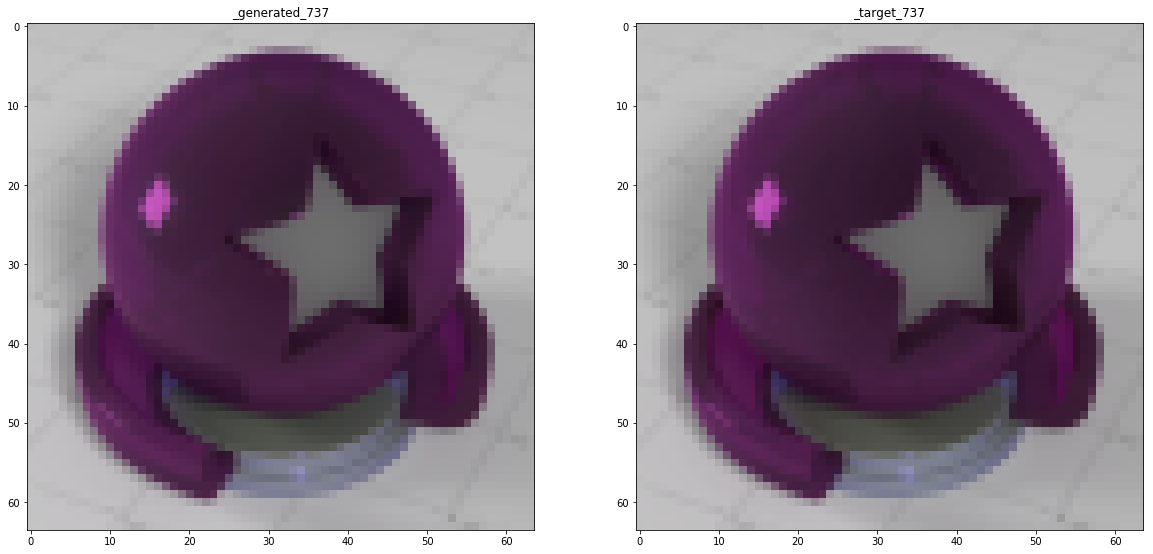

Epoch: 1483, Iter: 46000, MSE_loss: 4.216


<Figure size 720x576 with 0 Axes>

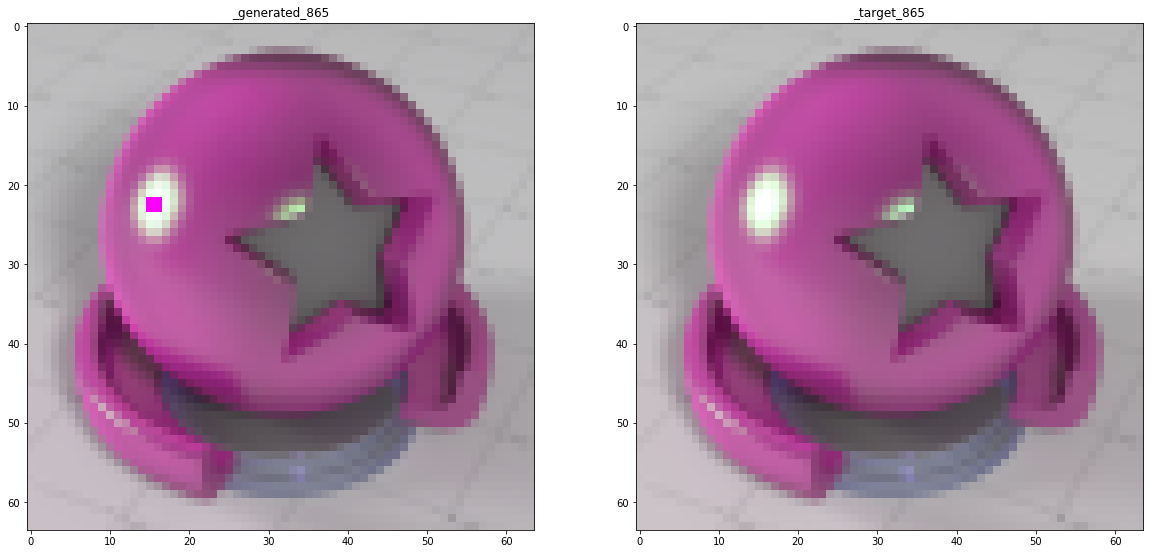

<Figure size 720x576 with 0 Axes>

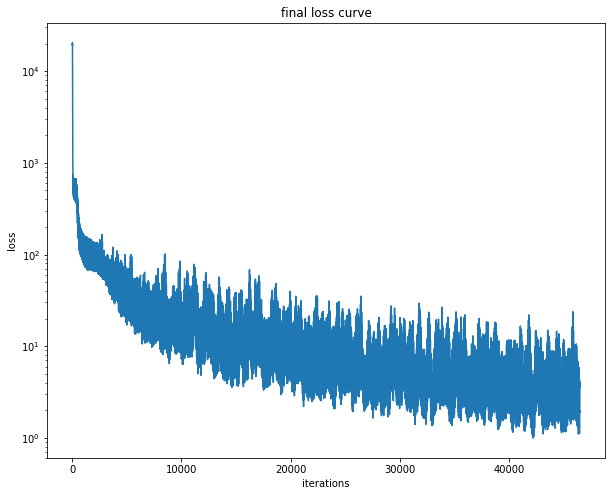

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Unflatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [386]:
# Experiment 2, use understanding of general techniques for normalization layers alongside
# 2d convolutions to help the model learn the spatial relationship between input latent space
# and output. Calling model DCNN for Deep CNN

DCNN_Gen = DCNN_generator().type(dtype)
DCNN_Gen.apply(initialize_weights)

DCNN_Gen_solver = get_optimizer(DCNN_Gen)

loss_hist = run_CNN(DCNN_Gen,
                    DCNN_Gen_solver,
                    loss_fn = nn.MSELoss(),
                    num_epochs=1500,
                    show_every = 500,
                    loss_type = "MSE_loss"
                   )
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.semilogy(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final loss curve")
plt.savefig('./../Models/CNN/DCNN_final_loss_curve.png')
plt.show()
torch.save(DCNN_Gen,"./../Models/CNN/DCNN_Gen")

# Overfit test

In [379]:
def run_CNN_overfit(CNN,CNN_solver,
            loss_fn,
            show_every = 100, 
            batch_size = BATCH_SIZE,
            num_epochs = 5,loss_type = "SmoothL1_loss"):

    iter_count = 0
    for epoch in range(num_epochs):
            x = sphere_model_batch(1,batch_size=batch_size)
            if x[0].shape[0] != batch_size:
                continue     
            CNN_solver.zero_grad()
            images = x[0].type(dtype)
            brdfs  = x[1].type(dtype).unsqueeze(1)
            gen_images = CNN(brdfs)
            
            total_error = loss_fn(gen_images,images)
            
            loss_hist.append(total_error.item())
            total_error.backward()        
            CNN_solver.step()
            
            
            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, {}: {:.4}'.format(epoch,iter_count,loss_type,loss_hist[len(loss_hist)-1]))
                gen_imgs_numpy = gen_images.data.cpu().numpy().transpose(0,2,3,1)
                real_imgs_numpy = images.data.cpu().numpy().transpose(0,2,3,1)
                img_0 = np.uint8(gen_imgs_numpy[0])
                img_1 = np.uint8(real_imgs_numpy[0])
                
                show_images([img_0,img_1], cols = 1, titles = ["_generated_"+str(0),
                                                           '_target_'+str(0)])
                print()
                plt.gcf().clear()
                if not iter_count == 0:
                    pbar.close()
                pbar = tqdm(total=show_every)
            iter_count += 1
            pbar.update(1)
            
    return loss_hist

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0, Iter: 0, MSE_loss: 2.015e+04


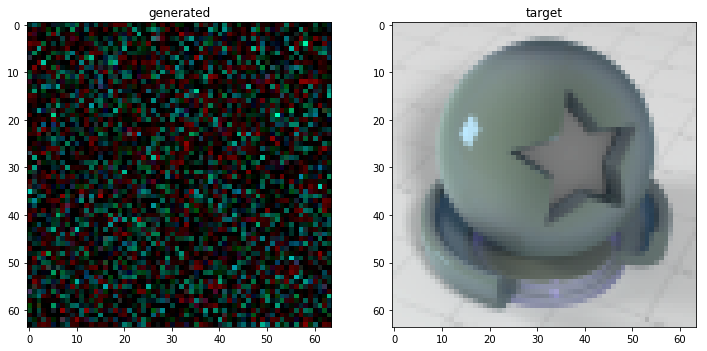

Epoch: 1000, Iter: 1000, MSE_loss: 145.9


<Figure size 432x288 with 0 Axes>

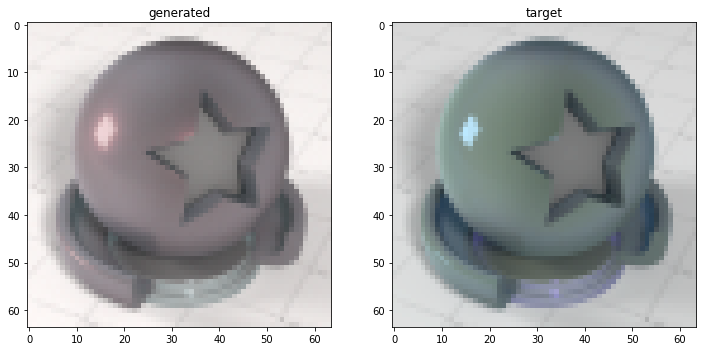

Epoch: 2000, Iter: 2000, MSE_loss: 80.23


<Figure size 432x288 with 0 Axes>

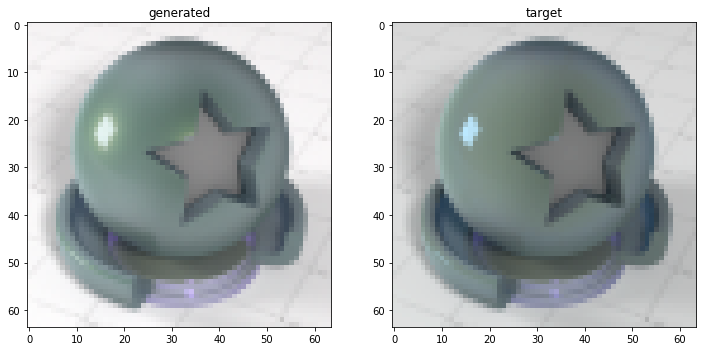

Epoch: 3000, Iter: 3000, MSE_loss: 39.55


<Figure size 432x288 with 0 Axes>

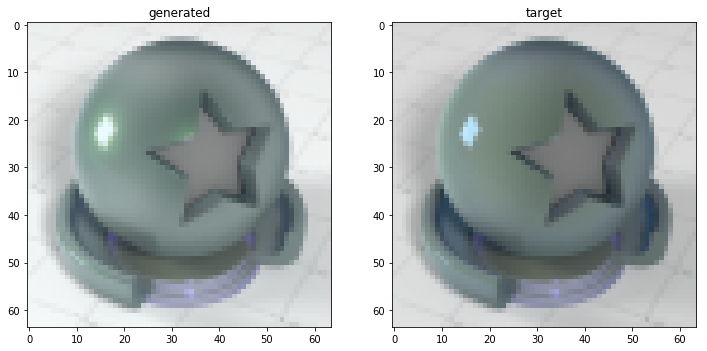

Epoch: 4000, Iter: 4000, MSE_loss: 19.22


<Figure size 432x288 with 0 Axes>

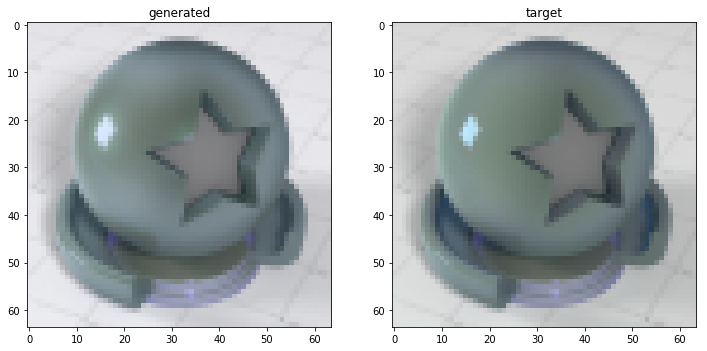

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Unflatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<Figure size 432x288 with 0 Axes>

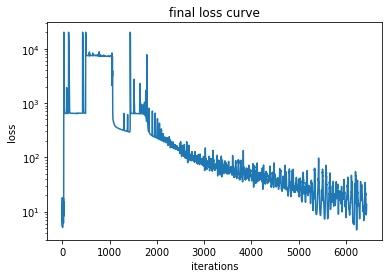

In [178]:

#Experiment 3 overfit model to batch size of 16 images to see if CNN architecture is feasible is feasible

CNN_Gen_overfit = CNN_generator().type(dtype)
CNN_Gen_overfit.apply(initialize_weights)

CNN_Gen_overfit_solver = get_optimizer(CNN_Gen_overfit)

loss_hist = run_CNN_overfit(CNN_Gen_overfit,
                            CNN_Gen_overfit_solver,
                            loss_fn = nn.MSELoss(), 
                            num_epochs=5000,show_every = 1000,loss_type="MSE_loss")

torch.save(CNN_Gen_overfit,"./../Models/CNN/Basemodel_Gen_overfit")
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.semilogy(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final loss curve")
plt.savefig('./../Models/CNN/Basemodel_overfit_final_loss_curve.png')
plt.show()
torch.save(CNN_Gen_overfit,"./../Models/CNN/CNN_Gen_overfit")

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0, Iter: 0, MSE_loss: 2.014e+04


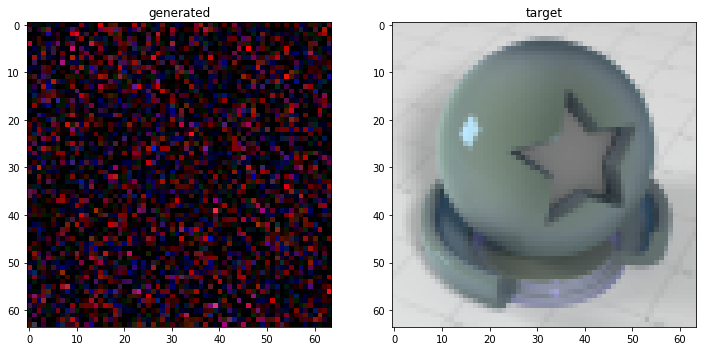

Epoch: 1000, Iter: 1000, MSE_loss: 61.36


<Figure size 432x288 with 0 Axes>

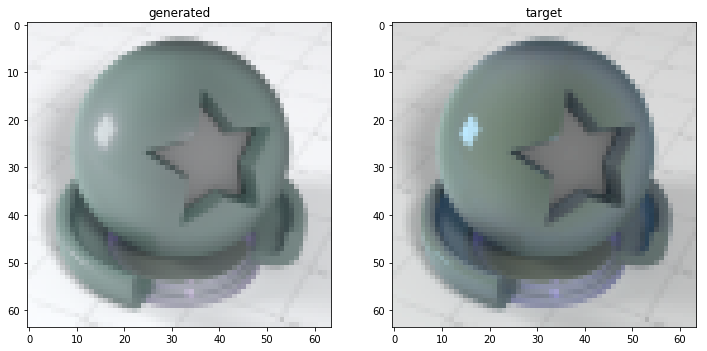

Epoch: 2000, Iter: 2000, MSE_loss: 38.96


<Figure size 432x288 with 0 Axes>

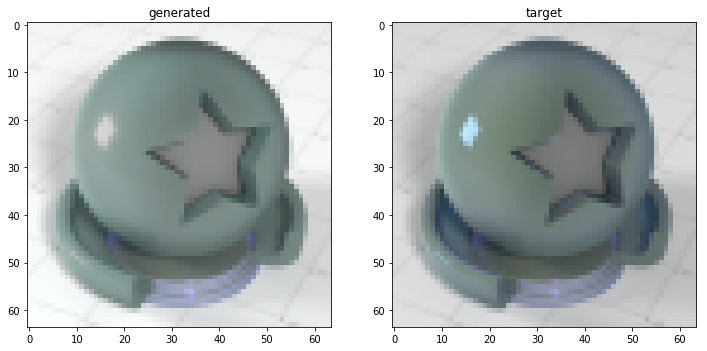

Epoch: 3000, Iter: 3000, MSE_loss: 13.62


<Figure size 432x288 with 0 Axes>

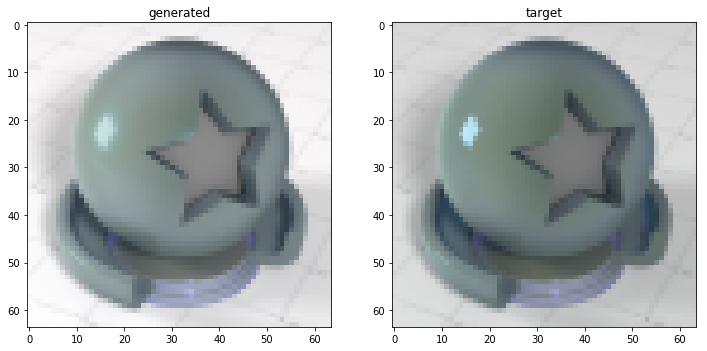

Epoch: 4000, Iter: 4000, MSE_loss: 68.41


<Figure size 432x288 with 0 Axes>

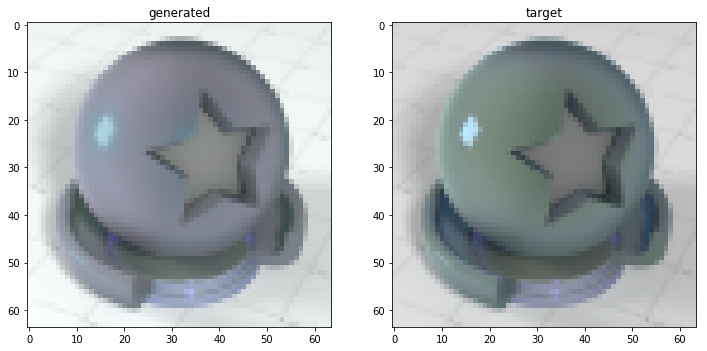

<Figure size 432x288 with 0 Axes>

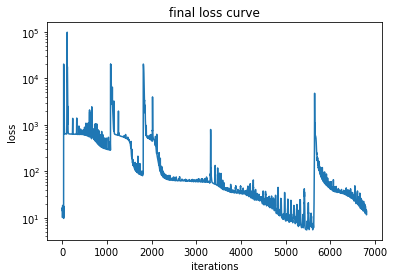

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Unflatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [232]:
# Experiment 4, use understanding of general techniques for normalization layers alongside
# 1d strided transpose convolutions to help the model learn the spatial relationship between input latent space
# and output. Calling model DCNN for Deep CNN. Overfit test

DCNN_Gen_overfit = DCNN_generator().type(dtype)
DCNN_Gen_overfit.apply(initialize_weights)

DCNN_Gen_overfit_solver = get_optimizer(DCNN_Gen_overfit)

loss_hist = run_CNN_overfit(DCNN_Gen_overfit,
                            DCNN_Gen_overfit_solver,
                            loss_fn = nn.MSELoss(),
                            num_epochs=5000,
                            show_every = 1000,
                            loss_type="MSE_loss")
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.semilogy(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final loss curve")
plt.savefig('./../Models/CNN/DCNN_overfit_final_loss_curve.png')
plt.show()
torch.save(DCNN_Gen_overfit,"./../Models/CNN/DCNN_Gen_overfit")

/home/arjunarora/anaconda3/envs/cs248/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Unflatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Evaluate CNN

In [11]:
def EVAL_CNN(CNN,
             eval_metric,
             show_every = 100, 
             batch_size = BATCH_SIZE,SAVE_NAME = " "):
    iter_count = 0
    loss_hist =[]
    for i in range(0,len(sphere_dataset_test),batch_size):
        x = sphere_model_batch(i,batch_size=batch_size,train_or_val='val')
#         print("x[0] shape: ",x[0].shape[0])
#         print("batch shape: ", batch_size)
        if x[0].shape[0] != batch_size:
            continue

        images = x[0].type(dtype)
        brdfs  = x[1].type(dtype).unsqueeze(1)
        gen_images = CNN(brdfs)

        total_error = eval_metric(gen_images,images)

        loss_hist.append(total_error.item())       

        if(iter_count % show_every == 0):
            print('Iter: {}, MSE_metric: {:.4}'.format(iter_count,loss_hist[len(loss_hist)-1]))
            
            batch_sample = np.random.randint(0,batch_size-1)
            
            gen_imgs_numpy = gen_images.data.cpu().numpy().transpose(0,2,3,1)
            real_imgs_numpy = images.data.cpu().numpy().transpose(0,2,3,1)

            img_0 = np.uint8(gen_imgs_numpy[batch_sample])
            img_1 = np.uint8(real_imgs_numpy[batch_sample])
            img_2 = np.uint8(np.abs(gen_imgs_numpy[batch_sample]-real_imgs_numpy[batch_sample]))
            
#             img_0 *= (255.0/img_0.max()) #Normalize to rgb range
#             img_1 *= 255.0/img_1.max() #Normalize to rgb range
            
            cv.imwrite(SAVE_NAME+"_generated_"+str(i+batch_sample+1)+'.png',cv.cvtColor(img_0,cv.COLOR_RGB2BGR))
            cv.imwrite(SAVE_NAME+'_target_'+str(i+batch_sample+1)+'.png',cv.cvtColor(img_1,cv.COLOR_RGB2BGR))
            cv.imwrite(SAVE_NAME+"_residual_"+str(i+batch_sample+1)+'.png',cv.cvtColor(img_2,cv.COLOR_RGB2BGR))
            show_images([img_0,img_1,img_2], cols = 1, titles = ["_generated_"+str(i+batch_sample+1),
                                                           '_target_'+str(i+batch_sample+1),
                                                            "_residual_"+str(i+batch_sample+1)])
            print()
            plt.gcf().clear()
            if not iter_count == 0:
                pbar.close()
            pbar = tqdm(total=show_every)
        iter_count += 1
        pbar.update(1)
            
    return loss_hist



Iter: 0, MSE_metric: 373.1


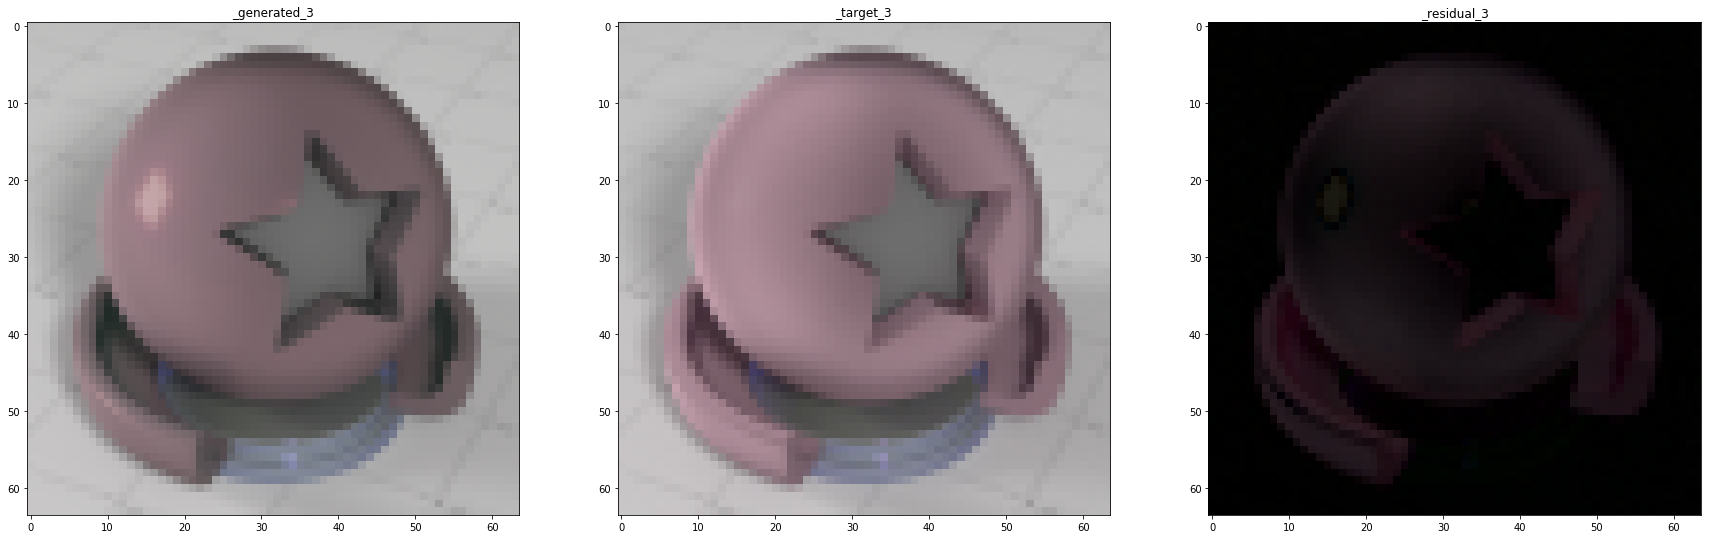

<Figure size 720x576 with 0 Axes>

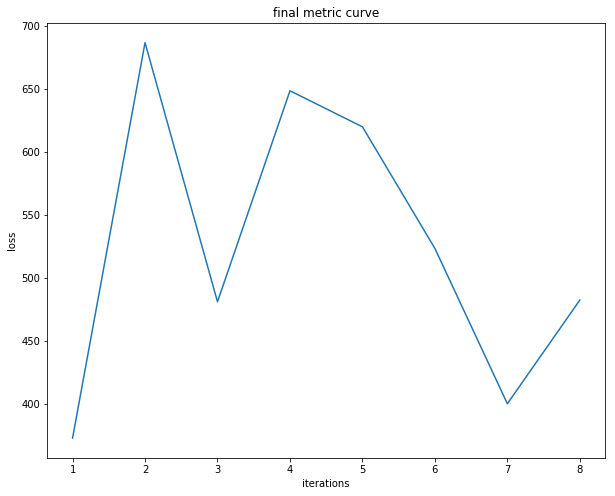

In [390]:
#Run Eval set on overfit DCNN model 

DCNN_overfit_eval = torch.load("./../Models/CNN/DCNN_Gen_overfit").eval()
loss_hist = EVAL_CNN(DCNN_overfit_eval,eval_metric = nn.MSELoss(),show_every = 10,SAVE_NAME = "DCNN_overfit")
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.plot(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final metric curve")
plt.savefig('./../Models/CNN/DCNN_overfit_final_metric_curve_eval.png')
plt.show()


Iter: 0, MSE_metric: 437.2


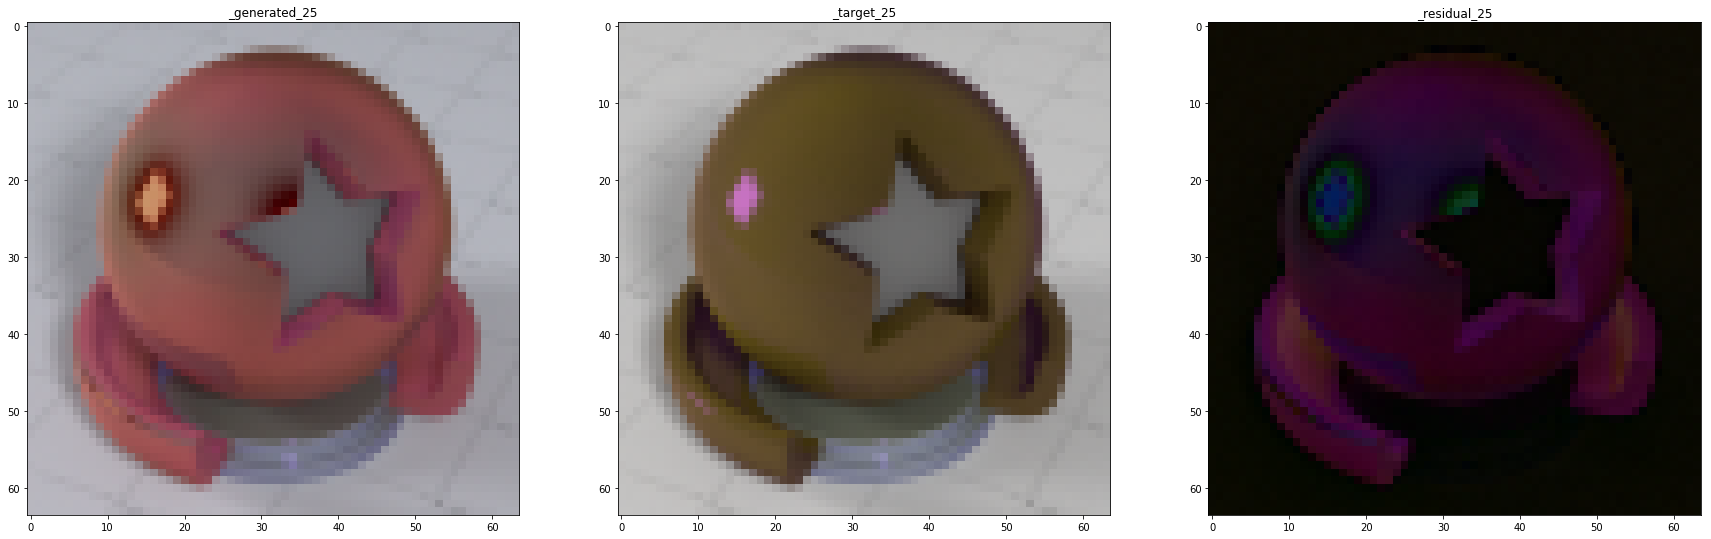

Iter: 5, MSE_metric: 396.2


<Figure size 720x576 with 0 Axes>

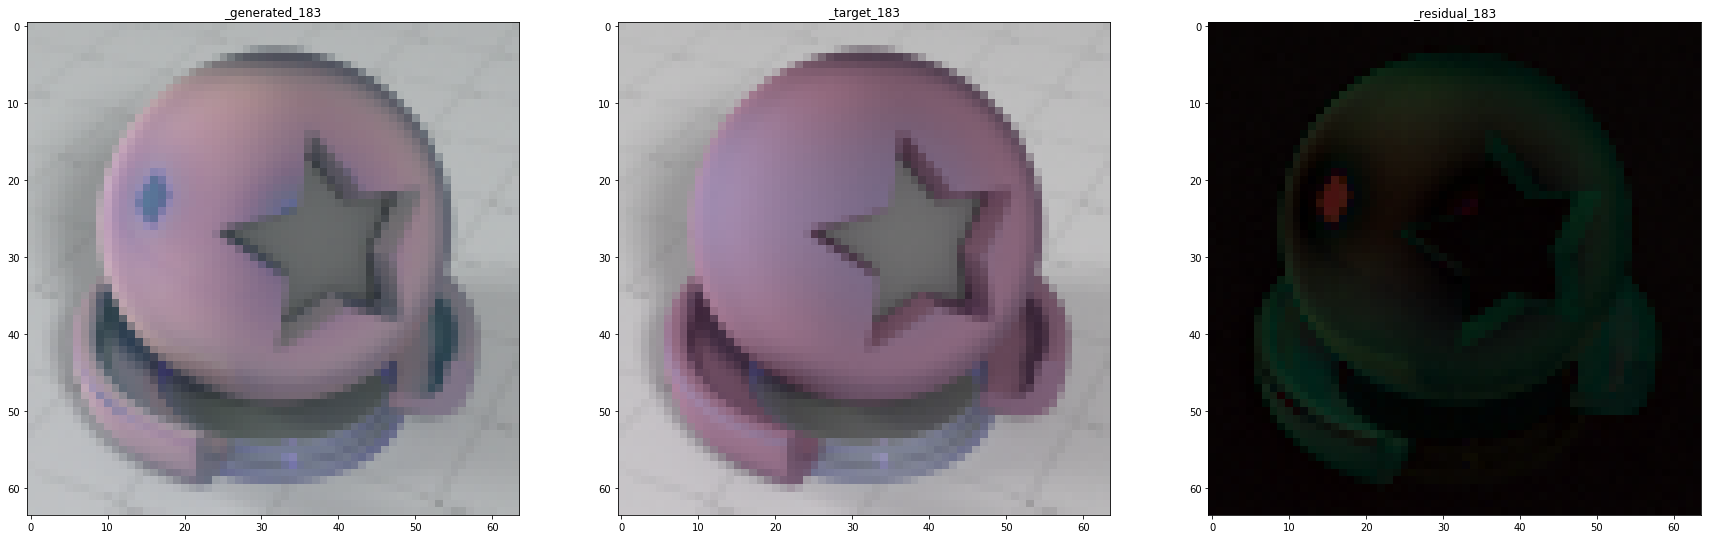

<Figure size 720x576 with 0 Axes>

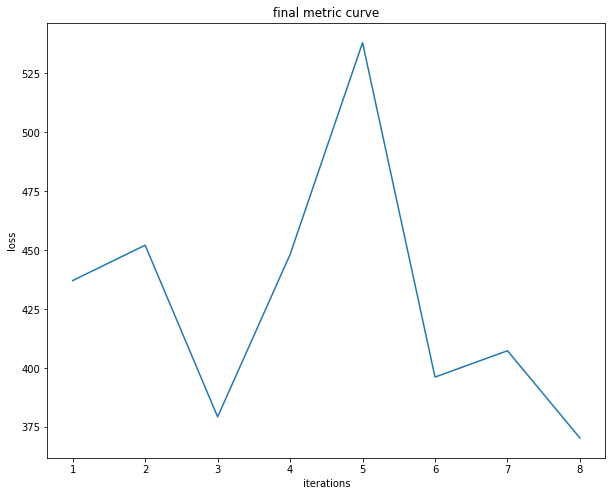

In [392]:
#Run overfit Basemodel
CNN_overfit_eval = torch.load("./../Models/CNN/CNN_Gen_overfit").eval()
loss_hist = EVAL_CNN(CNN_overfit_eval,eval_metric = nn.MSELoss(),show_every = 5,SAVE_NAME = "Basemodel_overfit")
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.plot(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final metric curve")
plt.savefig('./../Models/CNN/CNN_overfit_final_metric_curve_eval.png')
plt.show()


Iter: 0, MSE_metric: 185.4


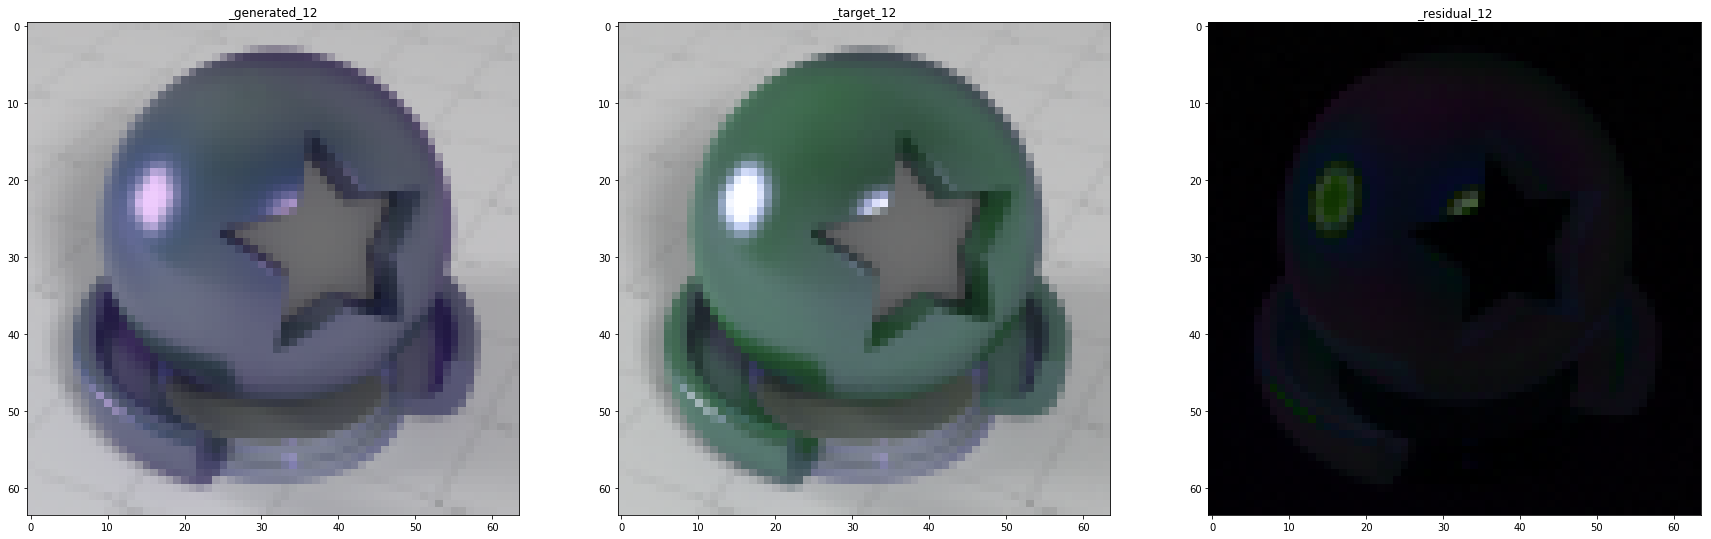

Iter: 5, MSE_metric: 104.1


<Figure size 720x576 with 0 Axes>

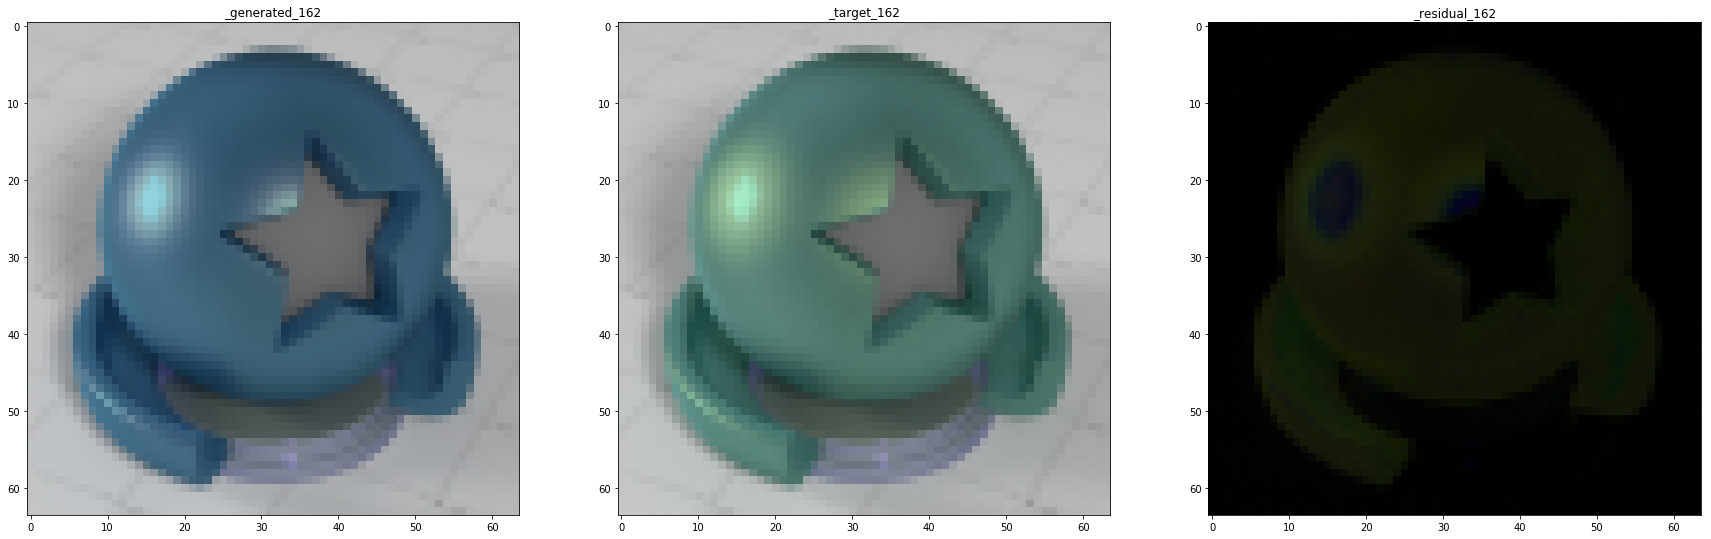

<Figure size 720x576 with 0 Axes>

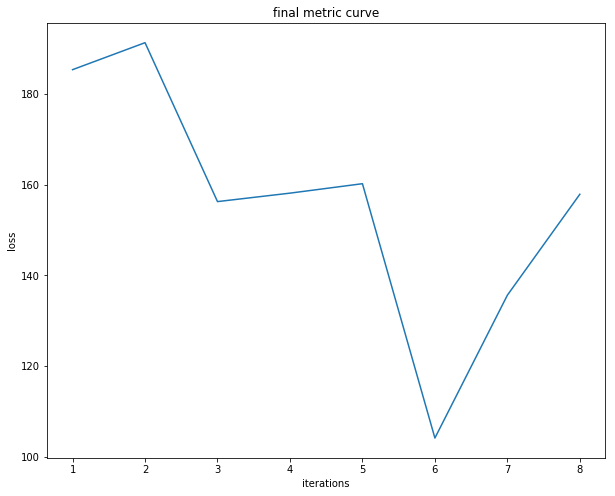

In [397]:
#Eval Set on basemodel

CNN_eval = torch.load("./../Models/CNN/Basemodel_Gen").eval()
loss_hist = EVAL_CNN(CNN_eval,eval_metric = nn.MSELoss(),show_every = 5,SAVE_NAME = "Basemodel_Gen")
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.plot(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final metric curve")
plt.savefig('./../Models/CNN/Basemodel_final_metric_curve_eval.png')
plt.show()

Iter: 0, MSE_metric: 53.47


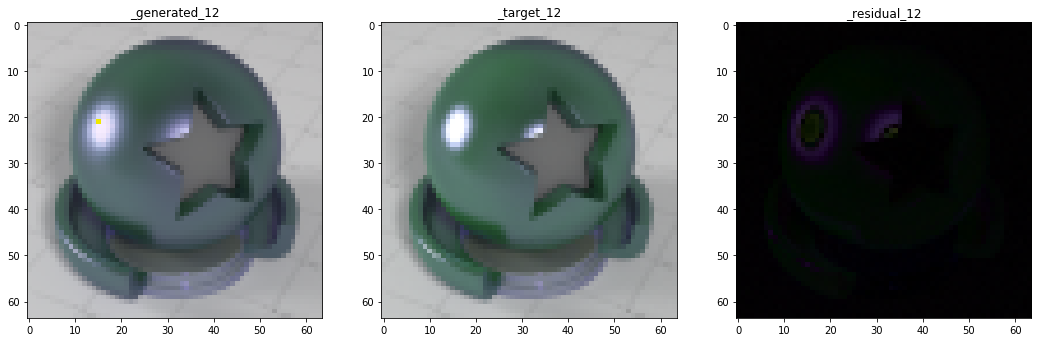

Iter: 5, MSE_metric: 45.79


<Figure size 432x288 with 0 Axes>

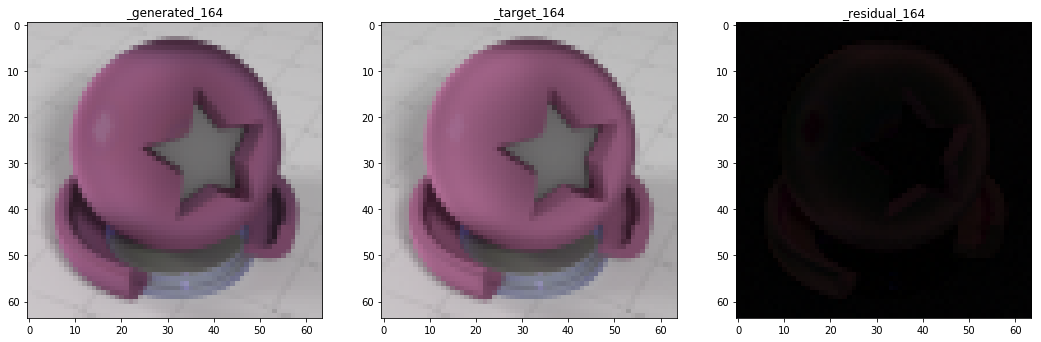

<Figure size 432x288 with 0 Axes>

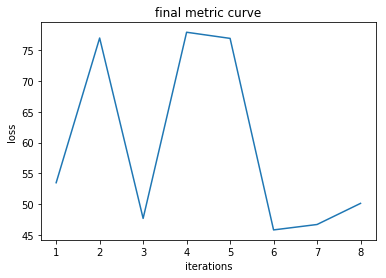

In [14]:
#Eval set on DCNN model 

DCNN_eval = torch.load("./../Models/CNN/DCNN_Gen").eval()
loss_hist = EVAL_CNN(DCNN_eval,eval_metric = nn.MSELoss(),show_every = 5,SAVE_NAME = "DCNN_Gen")
x = np.arange(1,len(loss_hist)+1)
fig = plt.figure()
plt.plot(x,
    loss_hist)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("final metric curve")
plt.savefig('./../Models/CNN/DCNN_final_metric_curve_eval.png')
plt.show()